In [6]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor

In [2]:
# 이거는 자꾸 맷플롯립 그래프에서 한글이 깨지는 문제로 폰트 설치해주는 코드

from matplotlib import font_manager, rc

font = r"C:\Users\thinp\fonts\NanumGothic.ttf"
font = font_manager.FontProperties(fname=font).get_name()
plt.style.use('seaborn-white')
rc('font', family=font)

# 01. Business Understanding

#### 배경

- 신용카드 사용량 분석을 통한 포스트 코로나-19 시대 신용카드 사용량 예측 모델 개발
- 지역 경제 위축 및 중소상공인 경영난 해소를 위한 대책 마련




#### 목표

- 신용카드 사용 내역 데이터를 활용한 지역별, 업종별 월간 카드 사용 총액 예측

#### 평가
- RMSLE
- 제주 지역에 3배 가중치 부여

#### 기타
- 외부데이터는 법적인 제약이 없는 경우에 사용 가능
- 크롤링 시 코드 제출
- 2020.04.30 데이터까지만 사용 가능




▶ 자주 묻는 질문

Q1. 데이터에 이용 고객수가 이용건수보다 많은 경우가 존재합니다. 어떤 경우 인가요?

A1. 카드 승인 후 승인 취소를 하는 고객이 있는 경우 발생합니다.


Q2. 매출 데이터는 온/오프라인 결제를 모두 포함하나요?

A2. 오프라인 결제만 포함합니다. 쇼핑몰, PG사업자 등을 통한 온라인 결제 데이터는 포함하지 않습니다.

# 02. Data Understanding

### Data Describtion

1. REG_YYMM : 년월
2. CARD_SIDO_NM: 카드이용지역_시도 (가맹점 주소 기준)
3. CARD_CCG_NM: 카드이용지역_시군구 (가맹점 주소 기준)
4. STD_CLSS_NM: 업종명
5. HOM_SIDO_NM: 거주지역_시도 (고객 집주소 기준)
6. HOM_CCG_NM: 거주지역_시군구 (고객 집주소 기준)
7. AGE: 연령대
8. SEX_CTGO_CD: 성별 (1: 남성, 2: 여성)
9. FLC: 가구생애주기 (1: 1인가구, 2: 영유아자녀가구, 3: 중고생자녀가구, 4: 성인자녀가구, 5: 노년가구)
10. CSTMR_CNT: 이용고객수 (명)
11. AMT: 이용금액 (원)
12. CNT: 이용건수 (건)




### Submission Data
- id
- REG_YYMM: 년월
- CARD_SIDO_NM: 카드이용지역_시도 (가맹점 주소 기준)
- STD_CLSS_NM: 업종명
- AMT: 이용금액 (원)


In [3]:
df = pd.read_csv(r"C:\Users\thinp\Desktop\Graduate School\Data\jeju_card\201901-202003.csv")
df_april = pd.read_csv(r"C:\Users\thinp\Desktop\Graduate School\Data\jeju_card\202004.csv")
sub = pd.read_csv(r"C:\Users\thinp\Desktop\Graduate School\Data\jeju_card\submission.csv")

In [5]:
df_all = pd.concat([df, df_april])
df_all

,REG_YYMM,CARD_SIDO_NM,CARD_CCG_NM,STD_CLSS_NM,HOM_SIDO_NM,HOM_CCG_NM,AGE,SEX_CTGO_CD,FLC,CSTMR_CNT,AMT,CNT
0,201901,강원,강릉시,건강보조식품 소매업,강원,강릉시,20s,1,1,4,311200,4
1,201901,강원,강릉시,건강보조식품 소매업,강원,강릉시,30s,1,2,7,1374500,8
2,201901,강원,강릉시,건강보조식품 소매업,강원,강릉시,30s,2,2,6,818700,6
3,201901,강원,강릉시,건강보조식품 소매업,강원,강릉시,40s,1,3,4,1717000,5
4,201901,강원,강릉시,건강보조식품 소매업,강원,강릉시,40s,1,4,3,1047300,3
...,...,...,...,...,...,...,...,...,...,...,...,...
1350317,202004,충북,충주시,휴양콘도 운영업,충북,충주시,20s,1,1,5,77000,5
1350318,202004,충북,충주시,휴양콘도 운영업,충북,충주시,30s,1,2,6,92000,6
1350319,202004,충북,충주시,휴양콘도 운영업,충북,충주시,40s,2,3,5,193000,5
1350320,202004,충북,충주시,휴양콘도 운영업,충북,충주시,50s,1,4,5,86000,7


In [12]:
df_all.to_csv("./df_all.csv", index=False)

In [6]:
df = df_all.copy()

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26048114 entries, 0 to 1350321
Data columns (total 12 columns):
 #   Column        Dtype 
---  ------        ----- 
 0   REG_YYMM      int64 
 1   CARD_SIDO_NM  object
 2   CARD_CCG_NM   object
 3   STD_CLSS_NM   object
 4   HOM_SIDO_NM   object
 5   HOM_CCG_NM    object
 6   AGE           object
 7   SEX_CTGO_CD   int64 
 8   FLC           int64 
 9   CSTMR_CNT     int64 
 10  AMT           int64 
 11  CNT           int64 
dtypes: int64(6), object(6)
memory usage: 2.5+ GB


In [8]:
df.head()

,REG_YYMM,CARD_SIDO_NM,CARD_CCG_NM,STD_CLSS_NM,HOM_SIDO_NM,HOM_CCG_NM,AGE,SEX_CTGO_CD,FLC,CSTMR_CNT,AMT,CNT
0,201901,강원,강릉시,건강보조식품 소매업,강원,강릉시,20s,1,1,4,311200,4
1,201901,강원,강릉시,건강보조식품 소매업,강원,강릉시,30s,1,2,7,1374500,8
2,201901,강원,강릉시,건강보조식품 소매업,강원,강릉시,30s,2,2,6,818700,6
3,201901,강원,강릉시,건강보조식품 소매업,강원,강릉시,40s,1,3,4,1717000,5
4,201901,강원,강릉시,건강보조식품 소매업,강원,강릉시,40s,1,4,3,1047300,3


여기서 CSTMR_CNT 는 이용고객수이고, CNT는 이용건수이다. 즉 한 row에 20대 CSMTR_CNT명이 CNT건 만큼 결제를 한 금액이 총 AMT인 것이다.

CSTMR_CNT는 결제 취소가 있더라도 줄어들지 않기 때문에 CNT와의 역전 현상이 일어난다. CNT는 결제 취소시 줄어든다.

In [8]:
df.tail()

,REG_YYMM,CARD_SIDO_NM,CARD_CCG_NM,STD_CLSS_NM,HOM_SIDO_NM,HOM_CCG_NM,AGE,SEX_CTGO_CD,FLC,CSTMR_CNT,AMT,CNT
1350317,202004,충북,충주시,휴양콘도 운영업,충북,충주시,20s,1,1,5,77000,5
1350318,202004,충북,충주시,휴양콘도 운영업,충북,충주시,30s,1,2,6,92000,6
1350319,202004,충북,충주시,휴양콘도 운영업,충북,충주시,40s,2,3,5,193000,5
1350320,202004,충북,충주시,휴양콘도 운영업,충북,충주시,50s,1,4,5,86000,7
1350321,202004,충북,충주시,휴양콘도 운영업,충북,충주시,60s,2,5,3,227000,4


In [9]:
df[df['CARD_CCG_NM']  == '속초시'].head(20)

,REG_YYMM,CARD_SIDO_NM,CARD_CCG_NM,STD_CLSS_NM,HOM_SIDO_NM,HOM_CCG_NM,AGE,SEX_CTGO_CD,FLC,CSTMR_CNT,AMT,CNT
19054,201901,강원,속초시,건강보조식품 소매업,강원,고성군,30s,2,2,3,389000,3
19055,201901,강원,속초시,건강보조식품 소매업,강원,속초시,30s,1,2,4,925600,4
19056,201901,강원,속초시,건강보조식품 소매업,강원,속초시,30s,2,2,15,1348600,15
19057,201901,강원,속초시,건강보조식품 소매업,강원,속초시,40s,2,3,6,575100,6
19058,201901,강원,속초시,건강보조식품 소매업,강원,속초시,50s,1,4,11,3885944,8
19059,201901,강원,속초시,건강보조식품 소매업,강원,속초시,50s,2,4,26,3656777,25
19060,201901,강원,속초시,건강보조식품 소매업,강원,속초시,60s,1,5,4,1661000,10
19061,201901,강원,속초시,건강보조식품 소매업,강원,속초시,60s,2,5,22,2901450,23
19062,201901,강원,속초시,건강보조식품 소매업,강원,속초시,70s,1,5,7,1312020,9
19063,201901,강원,속초시,건강보조식품 소매업,강원,양양군,50s,1,4,3,1055600,2


2019년 1월부터 2020년 3월 까지의 데이터가 있다. 

In [43]:
df['STD_CLSS_NM'].unique(), df['STD_CLSS_NM'].nunique()

(array(['건강보조식품 소매업', '골프장 운영업', '과실 및 채소 소매업', '관광 민예품 및 선물용품 소매업',
        '그외 기타 스포츠시설 운영업', '그외 기타 종합 소매업', '기타 대형 종합 소매업', '기타 외국식 음식점업',
        '기타 주점업', '기타음식료품위주종합소매업', '마사지업', '비알콜 음료점업', '빵 및 과자류 소매업',
        '서양식 음식점업', '수산물 소매업', '슈퍼마켓', '스포츠 및 레크레이션 용품 임대업', '여관업', '욕탕업',
        '육류 소매업', '일반유흥 주점업', '일식 음식점업', '전시 및 행사 대행업', '중식 음식점업',
        '차량용 가스 충전업', '차량용 주유소 운영업', '체인화 편의점', '피자 햄버거 샌드위치 및 유사 음식점업',
        '한식 음식점업', '호텔업', '화장품 및 방향제 소매업', '휴양콘도 운영업', '여행사업', '자동차 임대업',
        '면세점', '버스 운송업', '택시 운송업', '기타 수상오락 서비스업', '내항 여객 운송업',
        '그외 기타 분류안된 오락관련 서비스업', '정기 항공 운송업'], dtype=object),
 41)

In [52]:
df[df['CARD_CCG_NM'] == '고흥군']['STD_CLSS_NM'].unique(), df[df['CARD_CCG_NM'] == '고흥군']['STD_CLSS_NM'].nunique()

(array(['건강보조식품 소매업', '과실 및 채소 소매업', '관광 민예품 및 선물용품 소매업', '그외 기타 종합 소매업',
        '기타 대형 종합 소매업', '기타 외국식 음식점업', '기타 주점업', '기타음식료품위주종합소매업',
        '비알콜 음료점업', '빵 및 과자류 소매업', '서양식 음식점업', '수산물 소매업', '슈퍼마켓',
        '스포츠 및 레크레이션 용품 임대업', '여관업', '욕탕업', '육류 소매업', '일반유흥 주점업',
        '일식 음식점업', '전시 및 행사 대행업', '중식 음식점업', '차량용 가스 충전업', '차량용 주유소 운영업',
        '체인화 편의점', '피자 햄버거 샌드위치 및 유사 음식점업', '한식 음식점업', '화장품 및 방향제 소매업',
        '마사지업'], dtype=object),
 28)

애초에 존재하지 않는 row가 있습니다. 이러한 row 값을 만들어줘야 할 것입니다.

## 제출 양식 확인

In [8]:
sub.shape

(1394, 5)

In [28]:
sub.tail()

,id,REG_YYMM,CARD_SIDO_NM,STD_CLSS_NM,AMT
1389,1389,202007,충북,피자 햄버거 샌드위치 및 유사 음식점업,0
1390,1390,202007,충북,한식 음식점업,0
1391,1391,202007,충북,호텔업,0
1392,1392,202007,충북,화장품 및 방향제 소매업,0
1393,1393,202007,충북,휴양콘도 운영업,0


In [56]:
print(sub['CARD_SIDO_NM'].unique()), print(sub['CARD_SIDO_NM'].nunique())

['강원' '경기' '경남' '경북' '광주' '대구' '대전' '부산' '서울' '세종' '울산' '인천' '전남' '전북'
 '제주' '충남' '충북']
17


(None, None)

In [57]:
print(sub['STD_CLSS_NM'].unique()), print(sub['STD_CLSS_NM'].nunique())

['건강보조식품 소매업' '골프장 운영업' '과실 및 채소 소매업' '관광 민예품 및 선물용품 소매업'
 '그외 기타 분류안된 오락관련 서비스업' '그외 기타 스포츠시설 운영업' '그외 기타 종합 소매업' '기타 대형 종합 소매업'
 '기타 수상오락 서비스업' '기타 외국식 음식점업' '기타 주점업' '기타음식료품위주종합소매업' '내항 여객 운송업' '마사지업'
 '면세점' '버스 운송업' '비알콜 음료점업' '빵 및 과자류 소매업' '서양식 음식점업' '수산물 소매업' '슈퍼마켓'
 '스포츠 및 레크레이션 용품 임대업' '여관업' '여행사업' '욕탕업' '육류 소매업' '일반유흥 주점업' '일식 음식점업'
 '자동차 임대업' '전시 및 행사 대행업' '정기 항공 운송업' '중식 음식점업' '차량용 가스 충전업' '차량용 주유소 운영업'
 '체인화 편의점' '택시 운송업' '피자 햄버거 샌드위치 및 유사 음식점업' '한식 음식점업' '호텔업'
 '화장품 및 방향제 소매업' '휴양콘도 운영업']
41


(None, None)

In [59]:
41 * 17

697

In [20]:
sub['REG_YYMM'].value_counts()

202007    697
202004    697
Name: REG_YYMM, dtype: int64

결국 SIDO x 업종명 의 형식으로 4월과 7월 예상 매출액을 예측하라는 문제이다.

## EDA

In [14]:
# 시도별 카드 사용액을 확인해봅시다.

df.groupby(['CARD_SIDO_NM'])['AMT'].sum()

CARD_SIDO_NM
강원     1682729605366
경기    15096441319891
경남     3702068649712
경북     2931500855626
광주     1816454607103
대구     3183846194619
대전     1197766282786
부산     4732276090626
서울    15477668822187
세종      217033001408
울산     1329937315162
인천     3222094053814
전남     1957749500932
전북     2080887284830
제주     1416974517498
충남     2234736614208
충북     1558401703310
Name: AMT, dtype: int64

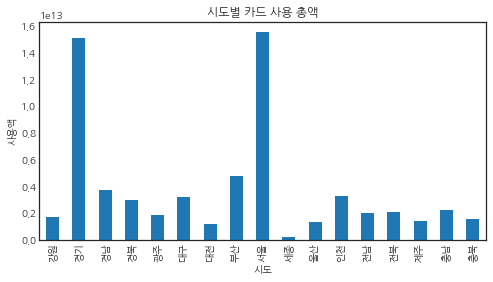

In [30]:
df.groupby(['CARD_SIDO_NM'])['AMT'].sum().plot(kind='bar', figsize=(8,4))
plt.xlabel('시도')
plt.ylabel('사용액')
plt.title('시도별 카드 사용 총액')
plt.show()

In [15]:
# 월별 전국 카드 사용량입니다.

df.groupby(['REG_YYMM'])['AMT'].sum()

REG_YYMM
201901    4052317259025
201902    3634345832156
201903    4105409759731
201904    4006698507386
201905    4345471235813
201906    4122105394194
201907    4187299694709
201908    4268655968810
201909    4123348058794
201910    4176583723584
201911    4047721898575
201912    4292549731776
202001    4124940612820
202002    3370694945536
202003    3437884426097
202004    3542539370072
Name: AMT, dtype: int64

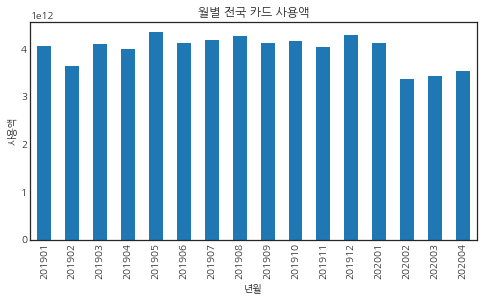

In [31]:
df.groupby(['REG_YYMM'])['AMT'].sum().plot(kind='bar', figsize=(8,4))
plt.xlabel('년월')
plt.ylabel('사용액')
plt.title('월별 전국 카드 사용액')
plt.show()

In [16]:
# 월별 제주 카드 사용량입니다.

df[df['CARD_SIDO_NM']=='제주'].groupby(['REG_YYMM'])['AMT'].sum()

REG_YYMM
201901     91789319740
201902     82004797730
201903     89420874275
201904     90108511963
201905     97084802656
201906     92624250758
201907     95549689709
201908    103389371548
201909     88220834270
201910     94126410878
201911     90968159937
201912     94185684769
202001     93467525597
202002     69580895083
202003     71061095855
202004     73392292730
Name: AMT, dtype: int64

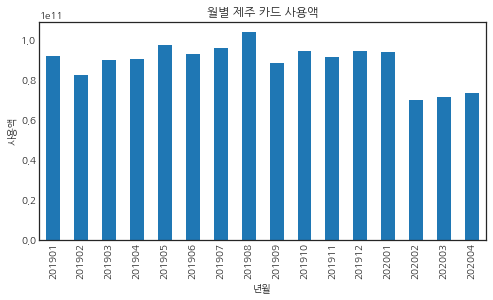

In [32]:
df[df['CARD_SIDO_NM']=='제주'].groupby(['REG_YYMM'])['AMT'].sum().plot(kind='bar', figsize=(8,4))
plt.xlabel('년월')
plt.ylabel('사용액')
plt.title('월별 제주 카드 사용액')
plt.show()

In [17]:
# 월별 서울 카드 사용량입니다.

df[df['CARD_SIDO_NM']=='서울'].groupby(['REG_YYMM'])['AMT'].sum()

REG_YYMM
201901    1008669894795
201902     887162863285
201903    1012627085366
201904     986259775631
201905    1057879226251
201906    1014410284692
201907    1037150538702
201908    1011825174305
201909     992187139385
201910    1015079007773
201911     986146232089
201912    1075946191707
202001     991578224067
202002     810412676550
202003     789796734433
202004     800537773156
Name: AMT, dtype: int64

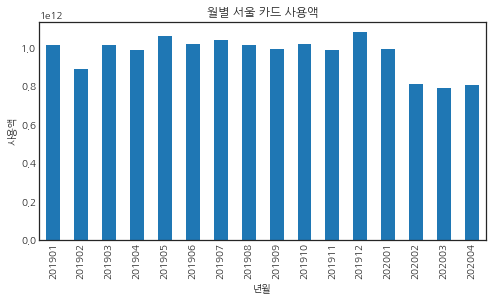

In [33]:
df[df['CARD_SIDO_NM']=='서울'].groupby(['REG_YYMM'])['AMT'].sum().plot(kind='bar', figsize=(8,4))
plt.xlabel('년월')
plt.ylabel('사용액')
plt.title('월별 서울 카드 사용액')
plt.show()

### 서울/제주 업종별 카드 사용액 비교

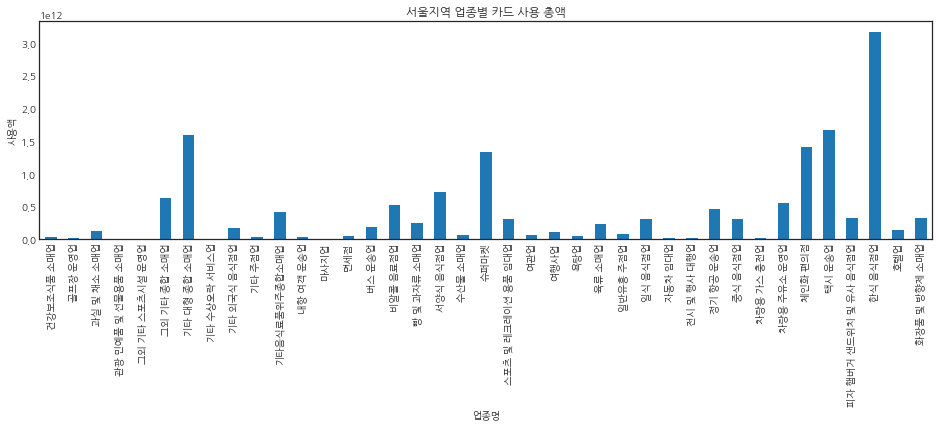

In [11]:
df[df['CARD_SIDO_NM']== '서울'].groupby(['STD_CLSS_NM'])['AMT'].sum().plot(kind='bar', figsize=(16,4))
plt.xlabel('업종명')
plt.ylabel('사용액')
plt.title('서울지역 업종별 카드 사용 총액')
plt.show()

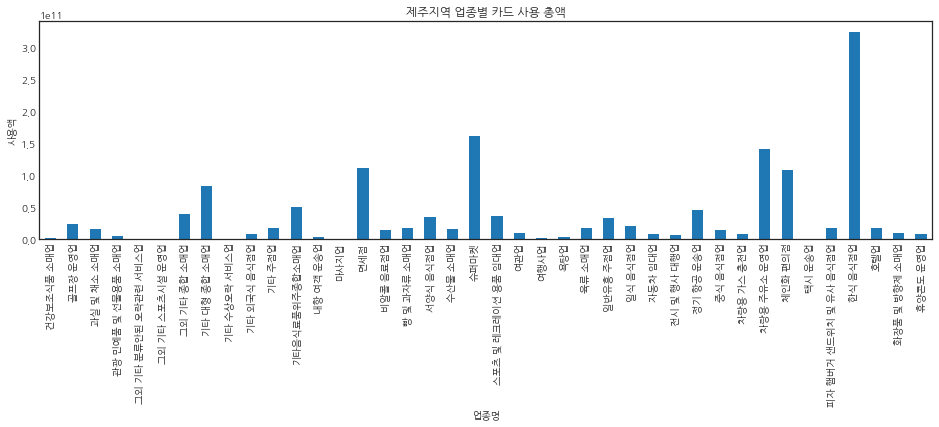

In [12]:
df[df['CARD_SIDO_NM']== '제주'].groupby(['STD_CLSS_NM'])['AMT'].sum().plot(kind='bar', figsize=(16,4))
plt.xlabel('업종명')
plt.ylabel('사용액')
plt.title('제주지역 업종별 카드 사용 총액')
plt.show()

### 제주지역 연도별 카드 사용액 비교

In [7]:
df_201903 = df[df['REG_YYMM'] == 201903]
df_202003 = df[df['REG_YYMM'] == 202003]

In [8]:
df_201903_jeju = df_201903[df_201903['CARD_SIDO_NM'] == '제주']
df_202003_jeju = df_202003[df_202003['CARD_SIDO_NM'] == '제주']

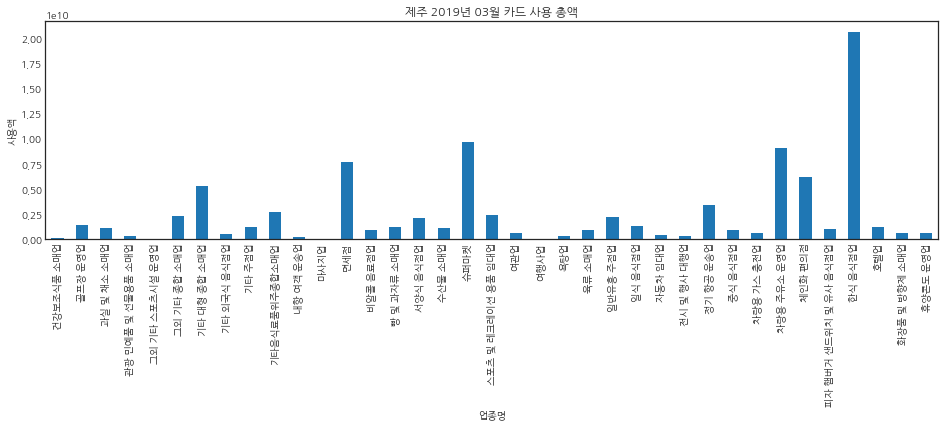

In [12]:
df_201903[df_201903['CARD_SIDO_NM']== '제주'].groupby(['STD_CLSS_NM'])['AMT'].sum().plot(kind='bar', figsize=(16,4))
plt.xlabel('업종명')
plt.ylabel('사용액')
plt.title('제주 2019년 03월 카드 사용 총액')
plt.show()

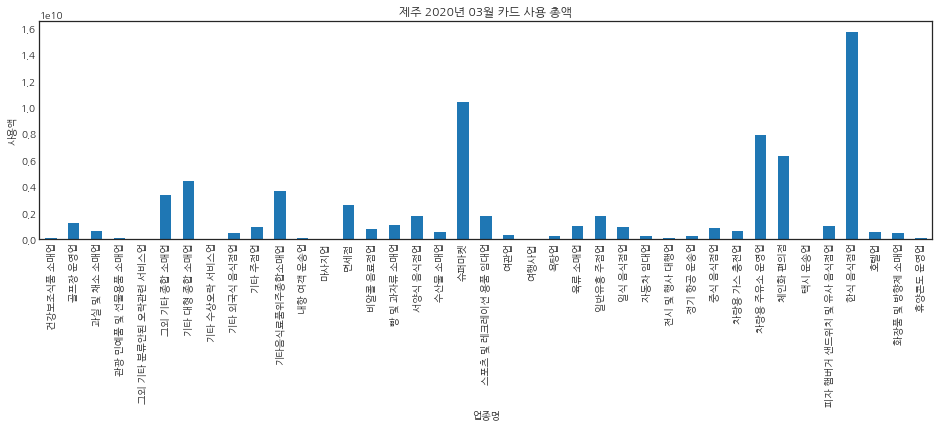

In [16]:
df_202003[df_202003['CARD_SIDO_NM']== '제주'].groupby(['STD_CLSS_NM'])['AMT'].sum().plot(kind='bar', figsize=(16,4))
plt.xlabel('업종명')
plt.ylabel('사용액')
plt.title('제주 2020년 03월 카드 사용 총액')
plt.show()

In [15]:
df_201903[df_201903['CARD_SIDO_NM']== '제주'].groupby(['STD_CLSS_NM'])['AMT'].sum()

STD_CLSS_NM
건강보조식품 소매업                  93076378
골프장 운영업                   1415478900
과실 및 채소 소매업               1073210801
관광 민예품 및 선물용품 소매업          317364690
그외 기타 스포츠시설 운영업             10513000
그외 기타 종합 소매업              2225449200
기타 대형 종합 소매업              5202216930
기타 외국식 음식점업                492990058
기타 주점업                    1210881958
기타음식료품위주종합소매업             2693599666
내항 여객 운송업                  173681100
마사지업                         6330000
면세점                       7585380787
비알콜 음료점업                   851943000
빵 및 과자류 소매업               1138990533
서양식 음식점업                  2078699535
수산물 소매업                   1057152001
슈퍼마켓                      9649136698
스포츠 및 레크레이션 용품 임대업        2383985965
여관업                        577251470
여행사업                        25522820
욕탕업                        249226132
육류 소매업                     873726656
일반유흥 주점업                  2213526140
일식 음식점업                   1306221228
자동차 임대업                    369335471
전시 및 행사 대행업               

In [14]:
df_202003[df_202003['CARD_SIDO_NM']== '제주'].groupby(['STD_CLSS_NM'])['AMT'].sum()

STD_CLSS_NM
건강보조식품 소매업                  80401810
골프장 운영업                   1227910031
과실 및 채소 소매업                612861477
관광 민예품 및 선물용품 소매업           51733910
그외 기타 분류안된 오락관련 서비스업          313500
그외 기타 종합 소매업              3282513600
기타 대형 종합 소매업              4391495540
기타 수상오락 서비스업                 1606700
기타 외국식 음식점업                412219149
기타 주점업                     891112022
기타음식료품위주종합소매업             3616119943
내항 여객 운송업                   66432400
마사지업                         2660000
면세점                       2590699901
비알콜 음료점업                   769358749
빵 및 과자류 소매업               1052147937
서양식 음식점업                  1712389156
수산물 소매업                    552245270
슈퍼마켓                     10327678507
스포츠 및 레크레이션 용품 임대업        1752880768
여관업                        267271952
여행사업                         3933600
욕탕업                        240490900
육류 소매업                    1000851231
일반유흥 주점업                  1707254256
일식 음식점업                    885288520
자동차 임대업                   

### 제주 지역 관외/관내인 카드 사용액 비교

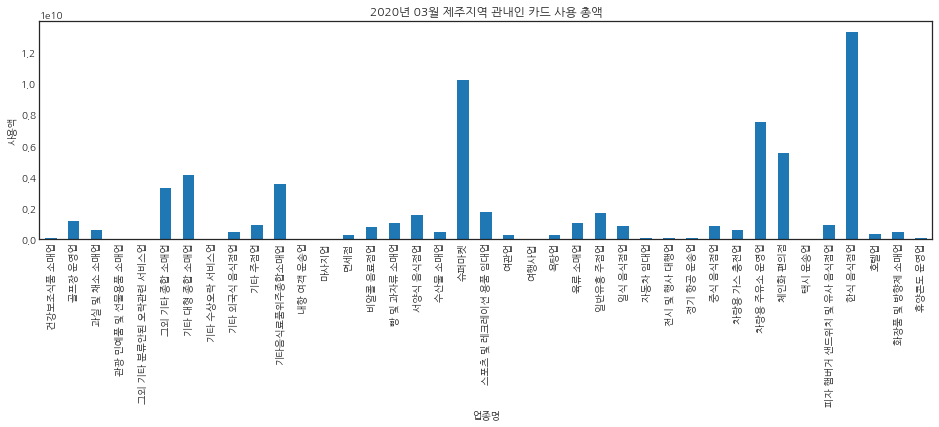

In [26]:
df_202003_jeju[df_202003_jeju['HOM_SIDO_NM']== '제주'].groupby(['STD_CLSS_NM'])['AMT'].sum().plot(kind='bar', figsize=(16,4))
plt.xlabel('업종명')
plt.ylabel('사용액')
plt.title('2020년 03월 제주지역 관내인 카드 사용 총액')
plt.show()

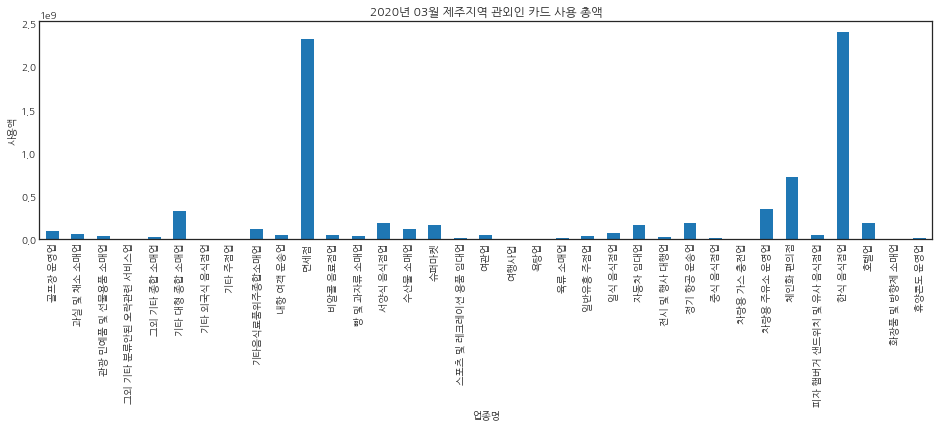

In [27]:
df_202003_jeju[df_202003_jeju['HOM_SIDO_NM']!= '제주'].groupby(['STD_CLSS_NM'])['AMT'].sum().plot(kind='bar', figsize=(16,4))
plt.xlabel('업종명')
plt.ylabel('사용액')
plt.title('2020년 03월 제주지역 관외인 카드 사용 총액')
plt.show()

In [22]:
df_202003_jeju[df_202003_jeju['HOM_SIDO_NM']== '제주'].groupby(['STD_CLSS_NM'])['AMT'].sum()

STD_CLSS_NM
건강보조식품 소매업                  80401810
골프장 운영업                   1139866983
과실 및 채소 소매업                562505477
관광 민예품 및 선물용품 소매업           15076310
그외 기타 분류안된 오락관련 서비스업          251500
그외 기타 종합 소매업              3255975900
기타 대형 종합 소매업              4066069720
기타 수상오락 서비스업                 1606700
기타 외국식 음식점업                411684649
기타 주점업                     888715022
기타음식료품위주종합소매업             3501973763
내항 여객 운송업                   18888500
마사지업                         2660000
면세점                        274008180
비알콜 음료점업                   728669204
빵 및 과자류 소매업               1014643237
서양식 음식점업                  1524153901
수산물 소매업                    443089395
슈퍼마켓                     10170573373
스포츠 및 레크레이션 용품 임대업        1748324468
여관업                        223888537
여행사업                         2480440
욕탕업                        238777540
육류 소매업                     994233501
일반유흥 주점업                  1680299756
일식 음식점업                    818944910
자동차 임대업                   

In [23]:
df_202003_jeju[df_202003_jeju['HOM_SIDO_NM']!= '제주'].groupby(['STD_CLSS_NM'])['AMT'].sum()

STD_CLSS_NM
골프장 운영업                    88043048
과실 및 채소 소매업                50356000
관광 민예품 및 선물용품 소매업          36657600
그외 기타 분류안된 오락관련 서비스업          62000
그외 기타 종합 소매업               26537700
기타 대형 종합 소매업              325425820
기타 외국식 음식점업                  534500
기타 주점업                      2397000
기타음식료품위주종합소매업             114146180
내항 여객 운송업                  47543900
면세점                      2316691721
비알콜 음료점업                   40689545
빵 및 과자류 소매업                37504700
서양식 음식점업                  188235255
수산물 소매업                   109155875
슈퍼마켓                      157105134
스포츠 및 레크레이션 용품 임대업          4556300
여관업                        43383415
여행사업                        1453160
욕탕업                         1713360
육류 소매업                      6617730
일반유흥 주점업                   26954500
일식 음식점업                    66343610
자동차 임대업                   155377274
전시 및 행사 대행업                18956120
정기 항공 운송업                 177510407
중식 음식점업                     5350100
차량용 가스 충전업      

In [9]:
df_201903_jeju[df_201903_jeju['HOM_SIDO_NM']== '제주'].groupby(['STD_CLSS_NM'])['AMT'].sum()

STD_CLSS_NM
건강보조식품 소매업                  83046378
골프장 운영업                   1163410186
과실 및 채소 소매업                624401692
관광 민예품 및 선물용품 소매업           27787600
그외 기타 스포츠시설 운영업              9918000
그외 기타 종합 소매업              2204440300
기타 대형 종합 소매업              4728727860
기타 외국식 음식점업                491253124
기타 주점업                    1207305958
기타음식료품위주종합소매업             2563872436
내항 여객 운송업                   32301900
마사지업                         6330000
면세점                       1100731245
비알콜 음료점업                   732299307
빵 및 과자류 소매업               1067391753
서양식 음식점업                  1666674603
수산물 소매업                    541900447
슈퍼마켓                      9434347421
스포츠 및 레크레이션 용품 임대업        2376549665
여관업                        398422373
여행사업                         5431540
욕탕업                        241412492
육류 소매업                     863028856
일반유흥 주점업                  2102649940
일식 음식점업                   1107242328
자동차 임대업                     60949550
전시 및 행사 대행업               

In [10]:
df_201903_jeju[df_201903_jeju['HOM_SIDO_NM']!= '제주'].groupby(['STD_CLSS_NM'])['AMT'].sum()

STD_CLSS_NM
건강보조식품 소매업                 10030000
골프장 운영업                   252068714
과실 및 채소 소매업               448809109
관광 민예품 및 선물용품 소매업         289577090
그외 기타 스포츠시설 운영업              595000
그외 기타 종합 소매업               21008900
기타 대형 종합 소매업              473489070
기타 외국식 음식점업                 1736934
기타 주점업                      3576000
기타음식료품위주종합소매업             129727230
내항 여객 운송업                 141379200
면세점                      6484649542
비알콜 음료점업                  119643693
빵 및 과자류 소매업                71598780
서양식 음식점업                  412024932
수산물 소매업                   515251554
슈퍼마켓                      214789277
스포츠 및 레크레이션 용품 임대업          7436300
여관업                       178829097
여행사업                       20091280
욕탕업                         7813640
육류 소매업                     10697800
일반유흥 주점업                  110876200
일식 음식점업                   198978900
자동차 임대업                   308385921
전시 및 행사 대행업               176820700
정기 항공 운송업                3098451148
중식 음식점업         

## 결측치 확인

In [19]:
df.isnull().sum()

REG_YYMM             0
CARD_SIDO_NM         0
CARD_CCG_NM      92371
STD_CLSS_NM          0
HOM_SIDO_NM          0
HOM_CCG_NM      155234
AGE                  0
SEX_CTGO_CD          0
FLC                  0
CSTMR_CNT            0
AMT                  0
CNT                  0
dtype: int64

In [41]:
df[df['CARD_CCG_NM'].isnull()]['CARD_SIDO_NM'].value_counts()

세종    92371
Name: CARD_SIDO_NM, dtype: int64

In [42]:
df[df['HOM_CCG_NM'].isnull()]['HOM_SIDO_NM'].value_counts()

세종    155234
Name: HOM_SIDO_NM, dtype: int64

결측치는 전부 세종시였습니다.

# 03. Dacon Baseline

## 03.1 Data Cleansing & Pre-Processing

In [7]:
def grap_year(data):
    data = str(data)
    return int(data[:4])

def grap_month(data):
    data = str(data)
    return int(data[4:])

In [4]:
# 날짜 처리

df = df.fillna('세종시')
df['year'] = df['REG_YYMM'].apply(lambda x: grap_year(x))
df['month'] = df['REG_YYMM'].apply(lambda x: grap_month(x))
df = df.drop(['REG_YYMM'], axis=1)

In [71]:
df.head()

,CARD_SIDO_NM,CARD_CCG_NM,STD_CLSS_NM,HOM_SIDO_NM,HOM_CCG_NM,AGE,SEX_CTGO_CD,FLC,CSTMR_CNT,AMT,CNT,year,month
0,강원,강릉시,건강보조식품 소매업,강원,강릉시,20s,1,1,4,311200,4,2019,1
1,강원,강릉시,건강보조식품 소매업,강원,강릉시,30s,1,2,7,1374500,8,2019,1
2,강원,강릉시,건강보조식품 소매업,강원,강릉시,30s,2,2,6,818700,6,2019,1
3,강원,강릉시,건강보조식품 소매업,강원,강릉시,40s,1,3,4,1717000,5,2019,1
4,강원,강릉시,건강보조식품 소매업,강원,강릉시,40s,1,4,3,1047300,3,2019,1


In [31]:
# 데이터 정제

df = df.copy()
df = df.drop(['CARD_CCG_NM', 'HOM_CCG_NM'], axis=1)

columns = ['CARD_SIDO_NM', 'STD_CLSS_NM', 'HOM_SIDO_NM', 'AGE', 'SEX_CTGO_CD', 'FLC', 'year', 'month']
df = df.groupby(columns).sum().reset_index(drop=False)

In [32]:
# 인코딩

dtypes = df.dtypes
encoders = {}
for column in df.columns:
    if str(dtypes[column]) == 'object':
        encoder = LabelEncoder()
        encoder.fit(df[column])
        encoders[column] = encoder
        
df_num = df.copy()
for column in encoders.keys():
    encoder = encoders[column]
    df_num[column] = encoder.transform(df[column])

## 03.2 Feature Engineering & Initial Modeling

In [33]:
# feature, target 설정
train_num = df_num.sample(frac=1, random_state=0)
train_features = train_num.drop(['CSTMR_CNT', 'AMT', 'CNT'], axis=1)
train_target = np.log1p(train_num['AMT'])

## 03.3 Model Tuning & Evaluation

#### RF

In [61]:
model = RandomForestRegressor(n_jobs=1, random_state=42)
model.fit(train_features, train_target)

RandomForestRegressor(n_jobs=1, random_state=42)

## 03.4 Conclusion

In [41]:
# 예측 템플릿 만들기
CARD_SIDO_NMs = df_num['CARD_SIDO_NM'].unique()
STD_CLSS_NMs  = df_num['STD_CLSS_NM'].unique()
HOM_SIDO_NMs  = df_num['HOM_SIDO_NM'].unique()
AGEs          = df_num['AGE'].unique()
SEX_CTGO_CDs  = df_num['SEX_CTGO_CD'].unique()
FLCs          = df_num['FLC'].unique()
years         = [2020]
months        = [4, 7]

temp = []
for CARD_SIDO_NM in CARD_SIDO_NMs:
    for STD_CLSS_NM in STD_CLSS_NMs:
        for HOM_SIDO_NM in HOM_SIDO_NMs:
            for AGE in AGEs:
                for SEX_CTGO_CD in SEX_CTGO_CDs:
                    for FLC in FLCs:
                        for year in years:
                            for month in months:
                                temp.append([CARD_SIDO_NM,
                                             STD_CLSS_NM,
                                             HOM_SIDO_NM,
                                             AGE,
                                             SEX_CTGO_CD,
                                             FLC,
                                             year,
                                             month])
temp = np.array(temp)
temp = pd.DataFrame(data=temp, columns=train_features.columns)

In [42]:
temp.to_csv('./temp.csv',index=False) # temp를 따로 저장합니다. 계속 꺼내 쓸 수 있기 때문에.

In [62]:
# 예측
pred = model.predict(temp)
pred = np.expm1(pred)
temp['AMT'] = np.round(pred, 0)
temp['REG_YYMM'] = temp['year']*100 + temp['month']
temp = temp[['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM', 'AMT']]
temp = temp.groupby(['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM']).sum().reset_index(drop=False)

In [63]:
# 디코딩 
temp['CARD_SIDO_NM'] = encoders['CARD_SIDO_NM'].inverse_transform(temp['CARD_SIDO_NM'])
temp['STD_CLSS_NM'] = encoders['STD_CLSS_NM'].inverse_transform(temp['STD_CLSS_NM'])

In [65]:
# 제출 파일 만들기
submission = pd.read_csv(r"C:\Users\thinp\Desktop\Graduate School\Data\jeju_card\submission.csv",index_col=0)
submission = submission.drop(['AMT'], axis=1)
submission = submission.merge(temp,
                              left_on=['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM'],
                              right_on=['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM'],
                              how='left')
submission.index.name = 'id'
submission.to_csv('./submission/submission_baseline_RF1.csv', encoding='utf-8-sig')
submission.head()

,REG_YYMM,CARD_SIDO_NM,STD_CLSS_NM,AMT
id,,,,
0,202004,강원,건강보조식품 소매업,4.959178e+08
1,202004,강원,골프장 운영업,6.951267e+09
2,202004,강원,과실 및 채소 소매업,1.818448e+09
3,202004,강원,관광 민예품 및 선물용품 소매업,1.011042e+08
4,202004,강원,그외 기타 분류안된 오락관련 서비스업,9.810176e+07


# 05. 분석 방법의 변주

현재 과제는 4월까지의 데이터로 7월을 예측하는 것이다. 여기에는 네 가지 방법이 있다.

1. Recurrent Model: 5월, 6월을 예측하고 그걸 활용해 7월까지 예측한다.
2. Jump Over Model: 4월까지의 데이터로 7월을 예측한다. 즉, 세 달 뒤를 예측한다.
3. General Model: 그냥 뭉뚱그려서 Null Data를 최대한 채우고 제너럴하게 예측을 하면..?
4. Split Model: 제너럴 모델보다 더 Null Data를 채우기 위해 시군구별로 따로 분석해서 예측을 하면?

### 05.1. Recurrent Model: 과대적합으로 기각

In [4]:
df_re = df.copy()

In [5]:
df_re = df_re[df_re.REG_YYMM <= 202001]

In [6]:
df_re

,REG_YYMM,CARD_SIDO_NM,CARD_CCG_NM,STD_CLSS_NM,HOM_SIDO_NM,HOM_CCG_NM,AGE,SEX_CTGO_CD,FLC,CSTMR_CNT,AMT,CNT
0,201901,강원,강릉시,건강보조식품 소매업,강원,강릉시,20s,1,1,4,311200,4
1,201901,강원,강릉시,건강보조식품 소매업,강원,강릉시,30s,1,2,7,1374500,8
2,201901,강원,강릉시,건강보조식품 소매업,강원,강릉시,30s,2,2,6,818700,6
3,201901,강원,강릉시,건강보조식품 소매업,강원,강릉시,40s,1,3,4,1717000,5
4,201901,강원,강릉시,건강보조식품 소매업,강원,강릉시,40s,1,4,3,1047300,3
...,...,...,...,...,...,...,...,...,...,...,...,...
22098299,202001,충북,충주시,휴양콘도 운영업,충북,충주시,40s,1,4,8,108000,9
22098300,202001,충북,충주시,휴양콘도 운영업,충북,충주시,40s,2,3,8,219000,13
22098301,202001,충북,충주시,휴양콘도 운영업,충북,충주시,50s,1,4,17,923000,21
22098302,202001,충북,충주시,휴양콘도 운영업,충북,충주시,50s,2,4,15,432600,21


In [8]:
# 날짜 처리

df_re['year'] = df_re['REG_YYMM'].apply(lambda x: grap_year(x))
df_re['month'] = df_re['REG_YYMM'].apply(lambda x: grap_month(x))
df_re = df_re.drop(['REG_YYMM'], axis=1)

In [10]:
# 데이터 정제
df = df_re.copy()
df = df.drop(['CARD_CCG_NM', 'HOM_CCG_NM'], axis=1)

columns = ['CARD_SIDO_NM', 'STD_CLSS_NM', 'HOM_SIDO_NM', 'AGE', 'SEX_CTGO_CD', 'FLC', 'year', 'month']
df = df.groupby(columns).sum().reset_index(drop=False)

In [11]:
# 인코딩
dtypes = df.dtypes
encoders = {}
for column in df.columns:
    if str(dtypes[column]) == 'object':
        encoder = LabelEncoder()
        encoder.fit(df[column])
        encoders[column] = encoder
        
df_num = df.copy()        
for column in encoders.keys():
    encoder = encoders[column]
    df_num[column] = encoder.transform(df[column])

In [12]:
# feature, target 설정
train_num = df_num.sample(frac=1, random_state=0)
train_features = train_num.drop(['CSTMR_CNT', 'AMT', 'CNT'], axis=1)
train_target = np.log1p(train_num['AMT'])

In [13]:
# 훈련
model = RandomForestRegressor(n_jobs=-1, random_state=0)
model.fit(train_features, train_target)

RandomForestRegressor(n_jobs=-1, random_state=0)

In [14]:
# 예측 템플릿 만들기
CARD_SIDO_NMs = df_num['CARD_SIDO_NM'].unique()
STD_CLSS_NMs  = df_num['STD_CLSS_NM'].unique()
HOM_SIDO_NMs  = df_num['HOM_SIDO_NM'].unique()
AGEs          = df_num['AGE'].unique()
SEX_CTGO_CDs  = df_num['SEX_CTGO_CD'].unique()
FLCs          = df_num['FLC'].unique()
years         = [2020]
months        = [2]

temp = []
for CARD_SIDO_NM in CARD_SIDO_NMs:
    for STD_CLSS_NM in STD_CLSS_NMs:
        for HOM_SIDO_NM in HOM_SIDO_NMs:
            for AGE in AGEs:
                for SEX_CTGO_CD in SEX_CTGO_CDs:
                    for FLC in FLCs:
                        for year in years:
                            for month in months:
                                temp.append([CARD_SIDO_NM, STD_CLSS_NM, HOM_SIDO_NM, AGE, SEX_CTGO_CD, FLC, year, month])
temp = np.array(temp)
temp = pd.DataFrame(data=temp, columns=train_features.columns)

In [15]:
# 예측
pred = model.predict(temp)
pred = np.expm1(pred)
temp['AMT'] = np.round(pred, 0)
temp['REG_YYMM'] = temp['year']*100 + temp['month']
temp

,CARD_SIDO_NM,STD_CLSS_NM,HOM_SIDO_NM,AGE,SEX_CTGO_CD,FLC,year,month,AMT,REG_YYMM
0,0,0,0,1,1,1,2020,2,359616.0,202002
1,0,0,0,1,1,2,2020,2,420384.0,202002
2,0,0,0,1,1,3,2020,2,383701.0,202002
3,0,0,0,1,1,4,2020,2,2325287.0,202002
4,0,0,0,1,1,5,2020,2,2325287.0,202002
...,...,...,...,...,...,...,...,...,...,...
829425,16,30,14,0,2,1,2020,2,129950.0,202002
829426,16,30,14,0,2,2,2020,2,140701.0,202002
829427,16,30,14,0,2,3,2020,2,140701.0,202002
829428,16,30,14,0,2,4,2020,2,140701.0,202002


In [19]:
temp = temp.drop(['REG_YYMM'], axis=1)

In [17]:
train_num_2 = train_num.drop(['CSTMR_CNT', 'CNT'], axis=1)

In [18]:
train_num_2

,CARD_SIDO_NM,STD_CLSS_NM,HOM_SIDO_NM,AGE,SEX_CTGO_CD,FLC,year,month,AMT
103548,1,29,16,2,1,1,2019,11,545200
738982,13,29,3,1,2,1,2020,1,30000
537169,8,38,9,0,1,1,2019,3,29400
718440,13,9,5,2,1,2,2020,1,236000
488805,8,23,6,5,2,5,2019,7,5824500
...,...,...,...,...,...,...,...,...,...
882371,15,34,10,2,2,2,2019,3,550080
152315,2,22,7,5,1,5,2019,7,2262000
117952,1,36,5,1,2,1,2019,8,1948530
435829,8,7,2,4,2,4,2019,4,153105910


In [20]:
train_num_2 = pd.concat([train_num_2, temp])

In [24]:
# feature, target 설정
train_num_2 = train_num_2.sample(frac=1, random_state=0)
train_features = train_num_2.drop(['AMT'], axis=1)
train_target = np.log1p(train_num_2['AMT'])

In [ ]:
# 훈련
model = RandomForestRegressor(n_jobs=-1, random_state=2)
model.fit(train_features, train_target)

In [ ]:
# 예측 템플릿 만들기
CARD_SIDO_NMs = df_num['CARD_SIDO_NM'].unique()
STD_CLSS_NMs  = df_num['STD_CLSS_NM'].unique()
HOM_SIDO_NMs  = df_num['HOM_SIDO_NM'].unique()
AGEs          = df_num['AGE'].unique()
SEX_CTGO_CDs  = df_num['SEX_CTGO_CD'].unique()
FLCs          = df_num['FLC'].unique()
years         = [2020]
months        = [3]

temp = []
for CARD_SIDO_NM in CARD_SIDO_NMs:
    for STD_CLSS_NM in STD_CLSS_NMs:
        for HOM_SIDO_NM in HOM_SIDO_NMs:
            for AGE in AGEs:
                for SEX_CTGO_CD in SEX_CTGO_CDs:
                    for FLC in FLCs:
                        for year in years:
                            for month in months:
                                temp.append([CARD_SIDO_NM, STD_CLSS_NM, HOM_SIDO_NM, AGE, SEX_CTGO_CD, FLC, year, month])
temp = np.array(temp)
temp = pd.DataFrame(data=temp, columns=train_features.columns)

In [ ]:
# 예측
pred = model.predict(temp)
pred = np.expm1(pred)
temp['AMT'] = np.round(pred, 0)
temp

In [ ]:
temp = temp[['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM', 'AMT']]
temp = temp.groupby(['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM']).sum().reset_index(drop=False)

In [ ]:
# 디코딩 
temp['CARD_SIDO_NM'] = encoders['CARD_SIDO_NM'].inverse_transform(temp['CARD_SIDO_NM'])
temp['STD_CLSS_NM'] = encoders['STD_CLSS_NM'].inverse_transform(temp['STD_CLSS_NM'])

자꾸 뻑이나서 다른 곳에서 진행했습니다.<br>
그 결과 제너럴 모델보다 약 0.1~0.2 포인트가 차이납니다.<br>
점프오버 모델보다는 살짝 좋지만 역시나 제너럴 모델이 더 고성능을 보입니다.<br>
제주 가중치 적용 전 스코어입니다.
- General:7.325582731001321
- Recurrent:7.462976901303662(+0.14)
- JumpOver: 7.5308433680497515(+0.21)

베이스라인 코드로 진행한 스코어이며,<br>
참고로 전처리와 피쳐엔지니어링이 모두 끝난 모델로 돌렸을 때,<br>
제주 가중치를 적용한 값과 그렇지 않은 값이 0.08 포인트 차이가 났습니다.(1.71, 1.63) 

### 05.2. JumpOver Model: 과소적합으로 기각

In [27]:
df3 = df.copy()

In [29]:
df3 = df3[df3['REG_YYMM'] >= 201903]

In [30]:
# 날짜 처리
df3 = df3.fillna('')
df3['year'] = df3['REG_YYMM'].apply(lambda x: grap_year(x))
df3['month'] = df3['REG_YYMM'].apply(lambda x: grap_month(x))
df3 = df3.drop(['REG_YYMM'], axis=1)

# 데이터 정제
df3 = df3.drop(['CARD_CCG_NM', 'HOM_CCG_NM'], axis=1)
columns = ['CARD_SIDO_NM', 'STD_CLSS_NM', 'HOM_SIDO_NM', 'AGE', 'SEX_CTGO_CD', 'FLC', 'year', 'month']
df3 = df3.groupby(columns).sum().reset_index(drop=False)

# 인코딩
dtypes = df3.dtypes
encoders = {}
for column in df3.columns:
    if str(dtypes[column]) == 'object':
        encoder = LabelEncoder()
        encoder.fit(df3[column])
        encoders[column] = encoder

for column in encoders.keys():
    encoder = encoders[column]
    df3[column] = encoder.transform(df3[column])
    
# feature, target 설정
train_num = df3.sample(frac=1, random_state=0)
train_features = train_num.drop(['CSTMR_CNT', 'AMT', 'CNT'], axis=1)
train_target = np.log1p(train_num['AMT'])

In [31]:
model = RandomForestRegressor(n_jobs=-1, random_state=42)
model.fit(train_features, train_target)

RandomForestRegressor(n_jobs=-1, random_state=42)

In [39]:
temp = pd.read_csv('./temp.csv')

In [34]:
# 예측
pred = model.predict(temp)
pred = np.expm1(pred)
temp['AMT'] = np.round(pred, 0)
temp['REG_YYMM'] = temp['year']*100 + temp['month']
temp = temp[['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM', 'AMT']]
temp = temp.groupby(['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM']).sum().reset_index(drop=False)

# 디코딩 
temp['CARD_SIDO_NM'] = encoders['CARD_SIDO_NM'].inverse_transform(temp['CARD_SIDO_NM'])
temp['STD_CLSS_NM'] = encoders['STD_CLSS_NM'].inverse_transform(temp['STD_CLSS_NM'])

# 제출 파일 만들기
submission = pd.read_csv(r"C:\Users\thinp\Desktop\Graduate School\Data\jeju_card\submission.csv",index_col=0)
submission = submission.drop(['AMT'], axis=1)
submission = submission.merge(temp,
                              left_on=['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM'],
                              right_on=['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM'],
                              how='left')
submission.index.name = 'id'
submission.to_csv('./submission/submission_12month_RF2.csv', encoding='utf-8-sig')
submission.head()

,REG_YYMM,CARD_SIDO_NM,STD_CLSS_NM,AMT
id,,,,
0,202004,강원,건강보조식품 소매업,5.399899e+08
1,202004,강원,골프장 운영업,6.281520e+09
2,202004,강원,과실 및 채소 소매업,1.856472e+09
3,202004,강원,관광 민예품 및 선물용품 소매업,1.002198e+08
4,202004,강원,그외 기타 분류안된 오락관련 서비스업,1.001884e+08


2019년 3월 ~ 2020년 3월 의 데이터로 2020년 4월을 예측했습니다.<br>
7.099 입니다. 제너럴 모델보다 0.003 높습니다.

In [35]:
df4 = df.copy()

In [36]:
df4 = df4[df4['REG_YYMM'] <= 202001]

In [37]:
# 날짜 처리
df4 = df4.fillna('')
df4['year'] = df4['REG_YYMM'].apply(lambda x: grap_year(x))
df4['month'] = df4['REG_YYMM'].apply(lambda x: grap_month(x))
df4 = df4.drop(['REG_YYMM'], axis=1)

# 데이터 정제
df4 = df4.drop(['CARD_CCG_NM', 'HOM_CCG_NM'], axis=1)
columns = ['CARD_SIDO_NM', 'STD_CLSS_NM', 'HOM_SIDO_NM', 'AGE', 'SEX_CTGO_CD', 'FLC', 'year', 'month']
df4 = df4.groupby(columns).sum().reset_index(drop=False)

# 인코딩
dtypes = df4.dtypes
encoders = {}
for column in df4.columns:
    if str(dtypes[column]) == 'object':
        encoder = LabelEncoder()
        encoder.fit(df4[column])
        encoders[column] = encoder

for column in encoders.keys():
    encoder = encoders[column]
    df4[column] = encoder.transform(df4[column])
    
# feature, target 설정
train_num = df4.sample(frac=1, random_state=0)
train_features = train_num.drop(['CSTMR_CNT', 'AMT', 'CNT'], axis=1)
train_target = np.log1p(train_num['AMT'])

In [42]:
temp_one = temp[temp['month'] == 4]
temp_one

,CARD_SIDO_NM,STD_CLSS_NM,HOM_SIDO_NM,AGE,SEX_CTGO_CD,FLC,year,month
0,0,0,0,1,1,1,2020,4
2,0,0,0,1,1,2,2020,4
4,0,0,0,1,1,3,2020,4
6,0,0,0,1,1,4,2020,4
8,0,0,0,1,1,5,2020,4
...,...,...,...,...,...,...,...,...
1658850,16,30,14,0,2,1,2020,4
1658852,16,30,14,0,2,2,2020,4
1658854,16,30,14,0,2,3,2020,4
1658856,16,30,14,0,2,4,2020,4


2019년 1월부터 2020년 1월의 데이터로 2020년 4월을 예측했습니다.<br>
7.3 이 나왔습니다. 제너럴 모델보다 0.3이 높습니다.<br>
점프오버 모델은 확실히 과소적합되는 경향이 있습니다.

### 05.3. General Model

이 방법을 써보는 이유는

1. Null Data를 채울 수 있다.
2. 제너럴한 모델을 만들 수 있다.

이다. 그래서 제출 템플릿이랑 똑같이 만들어서 결측치를 모조리 채워넣고 분석을 돌려보자. 어떻게 되는지.

일단 결과 템플릿은

1. REG_YYMM
2. CARD_SIDO_NM
3. STD_CLSS_NM

으로 이루어져 있는데, 그럼에도 불구하고 CARD_CCG_NM은 들어가야 한다고 본다. 그리고 HOM_SIDO_NM, HOM_CCG_NM은 버린다. AGE, SEX, FLC, CSTMR, CNT도 버리자.

In [107]:
df.head()

,REG_YYMM,CARD_SIDO_NM,CARD_CCG_NM,STD_CLSS_NM,HOM_SIDO_NM,HOM_CCG_NM,AGE,SEX_CTGO_CD,FLC,CSTMR_CNT,AMT,CNT
0,201901,강원,강릉시,건강보조식품 소매업,강원,강릉시,20s,1,1,4,311200,4
1,201901,강원,강릉시,건강보조식품 소매업,강원,강릉시,30s,1,2,7,1374500,8
2,201901,강원,강릉시,건강보조식품 소매업,강원,강릉시,30s,2,2,6,818700,6
3,201901,강원,강릉시,건강보조식품 소매업,강원,강릉시,40s,1,3,4,1717000,5
4,201901,강원,강릉시,건강보조식품 소매업,강원,강릉시,40s,1,4,3,1047300,3


In [108]:
# 사본을 만들어서 진행한다.

df_group = df.copy()

In [109]:
# 위에서 말한 컬럼들을 버린다.

df_group.drop(['HOM_SIDO_NM','HOM_CCG_NM', 'AGE', 'SEX_CTGO_CD', 'FLC', 'CSTMR_CNT', 'CNT'], axis=1, inplace=True)

In [110]:
# 찢어져 있는 AMT를 모아준다.

df_group_by = df_group.groupby(['REG_YYMM', 'CARD_SIDO_NM', 'CARD_CCG_NM', 'STD_CLSS_NM'])['AMT'].sum().reset_index()

In [111]:
# 결측치를 채우기 위해 전체 값이 들어 있는 템플릿을 만든다.
columns = ['REG_YYMM', 'CARD_SIDO_NM', 'CARD_CCG_NM', 'STD_CLSS_NM']

REG_YYMMs = df_group['REG_YYMM'].unique()
CARD_SIDO_NMs = df_group['CARD_SIDO_NM'].unique()
CARD_CCG_NMs = df_group['CARD_CCG_NM'].unique()
STD_CLSS_NMs  = df_group['STD_CLSS_NM'].unique()

temp = []
for REG_YYMM in REG_YYMMs:
    for CARD_SIDO_NM in CARD_SIDO_NMs:
        for CARD_CCG_NM in CARD_CCG_NMs:
            for STD_CLSS_NM in STD_CLSS_NMs:
                temp.append([REG_YYMM, CARD_SIDO_NM, CARD_CCG_NM, STD_CLSS_NM])

temp = np.array(temp)
temp = pd.DataFrame(data=temp, columns=columns)
temp.head()

,REG_YYMM,CARD_SIDO_NM,CARD_CCG_NM,STD_CLSS_NM
0,201901,강원,강릉시,건강보조식품 소매업
1,201901,강원,강릉시,골프장 운영업
2,201901,강원,강릉시,과실 및 채소 소매업
3,201901,강원,강릉시,관광 민예품 및 선물용품 소매업
4,201901,강원,강릉시,그외 기타 스포츠시설 운영업


In [112]:
temp.shape

(2373285, 4)

In [114]:
df_group_by['REG_YYMM'] = df_group_by['REG_YYMM'].astype(str)
temp['REG_YYMM'] = temp['REG_YYMM'].astype(str)

# 결측치를 null값으로 두기 위해 outer join 을 시킨다.
df_new = pd.merge(temp, df_group_by, on=['REG_YYMM', 'CARD_SIDO_NM', 'CARD_CCG_NM', 'STD_CLSS_NM'], how='outer')

In [115]:
# 결측치를 0으로 채운다.
df_new = df_new.fillna(0)

In [116]:
# year 변수와 month 변수로 찢어준다.

df_new['year'] = df_new['REG_YYMM'].apply(lambda x: grap_year(x))
df_new['month'] = df_new['REG_YYMM'].apply(lambda x: grap_month(x))
df_new = df_new.drop(['REG_YYMM'], axis=1)

In [117]:
# 인코딩
dtypes = df_new.dtypes
encoders = {}
for column in df_new.columns:
    if str(dtypes[column]) == 'object':
        encoder = LabelEncoder()
        encoder.fit(df_new[column])
        encoders[column] = encoder

for column in encoders.keys():
    encoder = encoders[column]
    df_new[column] = encoder.transform(df_new[column])
    
# feature, target 설정
train_num = df_new.sample(frac=1, random_state=0)
train_features = train_num.drop(['AMT'], axis=1)
train_target = np.log1p(train_num['AMT'])

In [118]:
model = RandomForestRegressor(n_jobs=-1, random_state=42)
model.fit(train_features, train_target)

RandomForestRegressor(n_jobs=-1, random_state=42)

In [119]:
# 예측 템플릿 만들기

df_temp = df_new.loc[:, df_new.columns !='AMT']

CARD_SIDO_NMs = df_temp['CARD_SIDO_NM'].unique()
CARD_CCG_NMs = df_temp['CARD_CCG_NM'].unique()
STD_CLSS_NMs  = df_temp['STD_CLSS_NM'].unique()
years = [2020]
months = [4, 7]

temp = []
for CARD_SIDO_NM in CARD_SIDO_NMs:
    for CARD_CCG_NM in CARD_CCG_NMs:
        for STD_CLSS_NM in STD_CLSS_NMs:
            for year in years:
                for month in months:
                    temp.append([CARD_SIDO_NM, CARD_CCG_NM, STD_CLSS_NM, year, month])

temp = np.array(temp)
temp = pd.DataFrame(data=temp, columns=df_temp.columns)
temp.head()

,CARD_SIDO_NM,CARD_CCG_NM,STD_CLSS_NM,year,month
0,0,4,0,2020,4
1,0,4,0,2020,7
2,0,4,1,2020,4
3,0,4,1,2020,7
4,0,4,2,2020,4


In [120]:
pred = model.predict(temp)
pred = np.expm1(pred)
temp['AMT'] = np.round(pred, 0)
temp['REG_YYMM'] = temp['year']*100 + temp['month']

In [ ]:
pd.merge(temp, pre_ccg_temp_1, on=['REG_YYMM', 'CARD_SIDO_NM', 'CARD_CCG_NM'])

In [139]:
temp.loc[(temp['CARD_SIDO_NM'] == 0) & (temp['CARD_CCG_NM'] == 3 )]

,CARD_SIDO_NM,CARD_CCG_NM,STD_CLSS_NM,year,month,AMT,REG_YYMM
10496,0,3,0,2020,4,0.0,202004
10497,0,3,0,2020,7,0.0,202007
10498,0,3,1,2020,4,0.0,202004
10499,0,3,1,2020,7,0.0,202007
10500,0,3,2,2020,4,0.0,202004
...,...,...,...,...,...,...,...
10573,0,3,12,2020,7,0.0,202007
10574,0,3,4,2020,4,0.0,202004
10575,0,3,4,2020,7,0.0,202007
10576,0,3,30,2020,4,0.0,202004


In [141]:
pre_ccg_temp_1['CARD_SIDO_NM'] = 0
pre_ccg_temp_1['CARD_CCG_NM'] = 3
pre_ccg_temp_1

,REG_YYMM,STD_CLSS_NM,AMT,CARD_SIDO_NM,CARD_CCG_NM
0,202004,0,13539340.0,0,3
1,202004,1,44119510.0,0,3
2,202004,2,30798786.0,0,3
3,202004,3,1391984.0,0,3
4,202004,4,0.0,0,3
...,...,...,...,...,...
77,202007,36,29915118.0,0,3
78,202007,37,175854730.0,0,3
79,202007,38,246346.0,0,3
80,202007,39,58546384.0,0,3


In [43]:
# 예측
pred = model.predict(temp)
pred = np.expm1(pred)
temp['AMT'] = np.round(pred, 0)
temp['REG_YYMM'] = temp['year']*100 + temp['month']
temp = temp[['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM', 'AMT']]
temp = temp.groupby(['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM']).sum().reset_index(drop=False)

# 디코딩 
temp['CARD_SIDO_NM'] = encoders['CARD_SIDO_NM'].inverse_transform(temp['CARD_SIDO_NM'])
temp['STD_CLSS_NM'] = encoders['STD_CLSS_NM'].inverse_transform(temp['STD_CLSS_NM'])

# 제출 파일 만들기
submission = pd.read_csv(r"C:\Users\thinp\Desktop\Graduate School\Data\jeju_card\submission.csv",index_col=0)
submission = submission.drop(['AMT'], axis=1)
submission = submission.merge(temp,
                              left_on=['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM'],
                              right_on=['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM'],
                              how='left')
submission.index.name = 'id'
submission.to_csv('./submission/submission_groupby_RF1.csv', encoding='utf-8-sig')
submission.head()

,REG_YYMM,CARD_SIDO_NM,STD_CLSS_NM,AMT
id,,,,
0,202004,강원,건강보조식품 소매업,9.662931e+07
1,202004,강원,골프장 운영업,3.180077e+09
2,202004,강원,과실 및 채소 소매업,8.754247e+08
3,202004,강원,관광 민예품 및 선물용품 소매업,1.461911e+07
4,202004,강원,그외 기타 분류안된 오락관련 서비스업,0.000000e+00


7.09 에서 3.81 로 급상승 했습니다. 역시 결측치를 채워주는 것이 엄청난 정확도 상승을 보였네요!

그렇다면...변수를 늘리기 위해... CCG별로 분석을 찢어서 하면 어떨까..?

### 05.4. Split Model

이 아이디어를 쓰는 이유는..Null Data를 채우는 것만으로도 월등한 성능을 보인다는 것을 알아냈기 때문이다. 변수를 줄여도 이정도인데, 변수를 늘려주면 더 좋은 성과를 보일 수 있을 것 같다.

다만 변수를 늘리면 데이터 크기가 너무 커지기 때문에 컴퓨터가 감당을 못한다. 때문에 CCG별로 나눠서 227개의 DF로 분석을 돌리고 concat 해주는 것이다.

CCG로 찢은 이유는 가장 중요한 변수이기 때문이다. 같은 강원도라도 춘천이나 강릉이 매우 성격이 다르고, 전남에서도 목포와 여수, 영광 등등 성격이 매우 다를 것이다. 그런데 이것을 SIDO로 한꺼번에 분석하는 것은 정확도가 다소 떨어질 수 있을 것이다.

In [124]:
len(df['REG_YYMM'].unique()), len(df['CARD_SIDO_NM'].unique()), len(df['CARD_CCG_NM'].unique()), len(df['STD_CLSS_NM'].unique()), len(df['AGE'].unique()), len(df['FLC'].unique())

(15, 17, 227, 41, 7, 5)

In [148]:
15*41*221*7*5*2

# 연월, CLSS, CCG, 

9514050

템플릿은 위와 같이 CARD_CCG, STD_CLSS, HOM_CCG, AGE, FLC, SEX 이렇게 곱연산으로 갈거고, 한개의 CCG마다 950만개의 DF가 나옵니다. 이걸 227개 만들어서 for문으로 돌리고, groupby해서 concat 하는 전략이지요. 역시 문제는 컴퓨팅 파워입니다.

안되네요, 수정합니다. 어레이 할당을 못하네요.. HOM_CCG를 CCG로 하지 않고 SIDO로 할게요.

In [98]:
# CCG를 위해선 null 값인 세종시를 채워줘야 합니다.

df[df['CARD_CCG_NM'].isnull()]

,REG_YYMM,CARD_SIDO_NM,CARD_CCG_NM,STD_CLSS_NM,HOM_SIDO_NM,HOM_CCG_NM,AGE,SEX_CTGO_CD,FLC,CSTMR_CNT,AMT,CNT
1243710,201901,세종,NaN,건강보조식품 소매업,세종,NaN,30s,1,2,14,2737050,17
1243711,201901,세종,NaN,건강보조식품 소매업,세종,NaN,30s,2,2,14,2595350,14
1243712,201901,세종,NaN,건강보조식품 소매업,세종,NaN,40s,1,3,13,2531950,11
1243713,201901,세종,NaN,건강보조식품 소매업,세종,NaN,40s,2,3,11,2118425,12
1243714,201901,세종,NaN,건강보조식품 소매업,세종,NaN,50s,1,4,21,3025500,23
...,...,...,...,...,...,...,...,...,...,...,...,...
24409418,202003,세종,NaN,화장품 및 방향제 소매업,충북,청주시 흥덕구,40s,2,3,5,88700,5
24409419,202003,세종,NaN,화장품 및 방향제 소매업,충북,청주시 흥덕구,50s,1,4,3,62400,3
24409420,202003,세종,NaN,화장품 및 방향제 소매업,충북,청주시 흥덕구,50s,2,4,10,494800,11
24409421,202003,세종,NaN,화장품 및 방향제 소매업,충북,청주시 흥덕구,60s,2,5,10,623100,10


In [48]:
df_ccg = df.fillna('세종시')
df_ccg[df_ccg['CARD_SIDO_NM'] == '세종']

,REG_YYMM,CARD_SIDO_NM,CARD_CCG_NM,STD_CLSS_NM,HOM_SIDO_NM,HOM_CCG_NM,AGE,SEX_CTGO_CD,FLC,CSTMR_CNT,AMT,CNT
1243710,201901,세종,세종시,건강보조식품 소매업,세종,세종시,30s,1,2,14,2737050,17
1243711,201901,세종,세종시,건강보조식품 소매업,세종,세종시,30s,2,2,14,2595350,14
1243712,201901,세종,세종시,건강보조식품 소매업,세종,세종시,40s,1,3,13,2531950,11
1243713,201901,세종,세종시,건강보조식품 소매업,세종,세종시,40s,2,3,11,2118425,12
1243714,201901,세종,세종시,건강보조식품 소매업,세종,세종시,50s,1,4,21,3025500,23
...,...,...,...,...,...,...,...,...,...,...,...,...
24409418,202003,세종,세종시,화장품 및 방향제 소매업,충북,청주시 흥덕구,40s,2,3,5,88700,5
24409419,202003,세종,세종시,화장품 및 방향제 소매업,충북,청주시 흥덕구,50s,1,4,3,62400,3
24409420,202003,세종,세종시,화장품 및 방향제 소매업,충북,청주시 흥덕구,50s,2,4,10,494800,11
24409421,202003,세종,세종시,화장품 및 방향제 소매업,충북,청주시 흥덕구,60s,2,5,10,623100,10


In [53]:
# 인코딩
dtypes = df_ccg.dtypes
encoders = {}
for column in df_ccg.columns:
    if str(dtypes[column]) == 'object':
        encoder = LabelEncoder()
        encoder.fit(df_ccg[column])
        encoders[column] = encoder

for column in encoders.keys():
    encoder = encoders[column]
    df_ccg[column] = encoder.transform(df_ccg[column])

In [55]:
ccg_list = df_ccg['CARD_CCG_NM'].unique().tolist()
len(ccg_list), print(ccg_list[0])

3


(227, None)

In [56]:
sido_list = df_ccg['CARD_SIDO_NM'].unique().tolist()
sido_list

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]

In [143]:
kw = df_ccg[df_ccg['CARD_SIDO_NM'] == sido_list[0]]['CARD_CCG_NM'].unique().tolist()
gk = df_ccg[df_ccg['CARD_SIDO_NM'] == sido_list[1]]['CARD_CCG_NM'].unique().tolist()
gn = df_ccg[df_ccg['CARD_SIDO_NM'] == sido_list[2]]['CARD_CCG_NM'].unique().tolist()
gb = df_ccg[df_ccg['CARD_SIDO_NM'] == sido_list[3]]['CARD_CCG_NM'].unique().tolist()
gj = df_ccg[df_ccg['CARD_SIDO_NM'] == sido_list[4]]['CARD_CCG_NM'].unique().tolist()
dg = df_ccg[df_ccg['CARD_SIDO_NM'] == sido_list[5]]['CARD_CCG_NM'].unique().tolist()
dj = df_ccg[df_ccg['CARD_SIDO_NM'] == sido_list[6]]['CARD_CCG_NM'].unique().tolist()
bs = df_ccg[df_ccg['CARD_SIDO_NM'] == sido_list[7]]['CARD_CCG_NM'].unique().tolist()
su = df_ccg[df_ccg['CARD_SIDO_NM'] == sido_list[8]]['CARD_CCG_NM'].unique().tolist()
sj = df_ccg[df_ccg['CARD_SIDO_NM'] == sido_list[9]]['CARD_CCG_NM'].unique().tolist()
us = df_ccg[df_ccg['CARD_SIDO_NM'] == sido_list[10]]['CARD_CCG_NM'].unique().tolist()
ic = df_ccg[df_ccg['CARD_SIDO_NM'] == sido_list[11]]['CARD_CCG_NM'].unique().tolist()
jn = df_ccg[df_ccg['CARD_SIDO_NM'] == sido_list[12]]['CARD_CCG_NM'].unique().tolist()
jb = df_ccg[df_ccg['CARD_SIDO_NM'] == sido_list[13]]['CARD_CCG_NM'].unique().tolist()
jj = df_ccg[df_ccg['CARD_SIDO_NM'] == sido_list[14]]['CARD_CCG_NM'].unique().tolist()
cn = df_ccg[df_ccg['CARD_SIDO_NM'] == sido_list[15]]['CARD_CCG_NM'].unique().tolist()
cb = df_ccg[df_ccg['CARD_SIDO_NM'] == sido_list[16]]['CARD_CCG_NM'].unique().tolist()
kw[0]

KeyError: 'CARD_SIDO_NM'

In [58]:
columns = ['REG_YYMM', 'STD_CLSS_NM', 'HOM_SIDO_NM', 'AGE', 'FLC', 'SEX_CTGO_CD']

REG_YYMMs = df_ccg['REG_YYMM'].unique().tolist()
STD_CLSSs = df_ccg['STD_CLSS_NM'].unique().tolist()
HOM_SIDOs = df_ccg['HOM_SIDO_NM'].unique().tolist()
AGEs = df_ccg['AGE'].unique().tolist()
FLCs = df_ccg['FLC'].unique().tolist()
SEXs = df_ccg['SEX_CTGO_CD'].unique().tolist()

ccg_temp = []

for YYMM in REG_YYMMs:
    for CLSS in STD_CLSSs:
        for HOM_SIDO in HOM_SIDOs:
            for AGE in AGEs:
                for FLC in FLCs:
                    for SEX in SEXs:
                        ccg_temp.append([YYMM, CLSS, HOM_SIDO, AGE, FLC, SEX])

#ccg_temp = np.array(ccg_temp)
ccg_temp = pd.DataFrame(data = ccg_temp, columns = columns)
print(ccg_temp.head())
print(ccg_temp.shape)

   REG_YYMM  STD_CLSS_NM  HOM_SIDO_NM  AGE  FLC  SEX_CTGO_CD
0    201901            0            0    1    1            1
1    201901            0            0    1    1            2
2    201901            0            0    1    2            1
3    201901            0            0    1    2            2
4    201901            0            0    1    3            1
(731850, 6)


In [59]:
ccg_temp.to_csv('./ccg_temp.csv', index=False)

In [61]:
# 쓰지 않을 컬럼을 삭제하겠습니다.
df_ccg = df_ccg.drop(['CARD_SIDO_NM', 'HOM_CCG_NM', 'CSTMR_CNT', 'CNT'], axis=1)

df_ccg[df_ccg['CARD_CCG_NM'] == ccg_list[0]]

,REG_YYMM,CARD_CCG_NM,STD_CLSS_NM,HOM_SIDO_NM,AGE,SEX_CTGO_CD,FLC,AMT
0,201901,3,0,0,1,1,1,311200
1,201901,3,0,0,2,1,2,1374500
2,201901,3,0,0,2,2,2,818700
3,201901,3,0,0,3,1,3,1717000
4,201901,3,0,0,3,1,4,1047300
...,...,...,...,...,...,...,...,...
23445071,202003,3,40,15,4,1,4,123000
23445072,202003,3,40,15,2,1,2,466350
23445073,202003,3,40,15,4,1,4,402800
23445074,202003,3,40,15,4,2,4,589000


In [128]:
temp_1 = pd.merge(ccg_temp, df_ccg[df_ccg['CARD_CCG_NM'] == ccg_list[0]], how='left', on=['REG_YYMM', 'STD_CLSS_NM', 'HOM_SIDO_NM', 'AGE','FLC', 'SEX_CTGO_CD'])
temp_1['CARD_CCG_NM'] = temp_1['CARD_CCG_NM'].fillna('3')
temp_1['AMT'] = temp_1['AMT'].fillna(0)
temp_1

,REG_YYMM,STD_CLSS_NM,HOM_SIDO_NM,AGE,FLC,SEX_CTGO_CD,CARD_CCG_NM,AMT
0,201901,0,0,1,1,1,3,311200.0
1,201901,0,0,1,1,2,3,0.0
2,201901,0,0,1,2,1,3,0.0
3,201901,0,0,1,2,2,3,0.0
4,201901,0,0,1,3,1,3,0.0
...,...,...,...,...,...,...,...,...
860264,202003,30,14,0,3,2,3,0.0
860265,202003,30,14,0,4,1,3,0.0
860266,202003,30,14,0,4,2,3,0.0
860267,202003,30,14,0,5,1,3,0.0


In [129]:
# year 변수와 month 변수로 찢어준다.

temp_1['year'] = temp_1['REG_YYMM'].apply(lambda x: grap_year(x))
temp_1['month'] = temp_1['REG_YYMM'].apply(lambda x: grap_month(x))
temp_1 = temp_1.drop(['REG_YYMM'], axis=1)
  
# feature, target 설정
train_num = temp_1.sample(frac=1, random_state=0)
train_features = train_num.drop(['AMT'], axis=1)
train_target = np.log1p(train_num['AMT'])

In [130]:
model = RandomForestRegressor(n_jobs=-1, random_state=42)
model.fit(train_features, train_target)

RandomForestRegressor(n_jobs=-1, random_state=42)

In [131]:
columns = ['STD_CLSS_NM', 'HOM_SIDO_NM', 'AGE', 'FLC', 'SEX_CTGO_CD', 'CARD_CCG_NM', 'year', 'month']

STD_CLSSs = temp_1['STD_CLSS_NM'].unique().tolist()
HOM_SIDOs = temp_1['HOM_SIDO_NM'].unique().tolist()
AGEs = temp_1['AGE'].unique().tolist()
FLCs = temp_1['FLC'].unique().tolist()
SEXs = temp_1['SEX_CTGO_CD'].unique().tolist()
CARD_CCG_NMs = temp_1['CARD_CCG_NM'].unique().tolist()
years = [2020]
months = [4, 7]

pre_ccg_temp = []

for CLSS in STD_CLSSs:
    for HOM_SIDO in HOM_SIDOs:
        for AGE in AGEs:
            for FLC in FLCs:
                for SEX in SEXs:
                    for CARD_CCG_NM in CARD_CCG_NMs:
                        for year in years:
                            for month in months:
                                pre_ccg_temp.append([CLSS, HOM_SIDO, AGE, FLC, SEX, CARD_CCG_NM, year, month])

#ccg_temp = np.array(ccg_temp)
pre_ccg_temp = pd.DataFrame(data = pre_ccg_temp, columns = columns)
print(pre_ccg_temp.head())
print(pre_ccg_temp.shape)

   STD_CLSS_NM  HOM_SIDO_NM  AGE  FLC  SEX_CTGO_CD CARD_CCG_NM  year  month
0            0            0    1    1            1           3  2020      4
1            0            0    1    1            1           3  2020      7
2            0            0    1    1            1           3  2020      4
3            0            0    1    1            1           3  2020      7
4            0            0    1    1            2           3  2020      4
(195160, 8)


In [147]:
pre_ccg_temp.to_csv('./pre_ccg_temp.csv', index=False)

In [144]:
# 예측
pre_ccg_temp_1 = pre_ccg_temp.copy()

pred = model.predict(pre_ccg_temp_1)
pred = np.expm1(pred)
pre_ccg_temp_1['AMT'] = np.round(pred, 0)
pre_ccg_temp_1['REG_YYMM'] = pre_ccg_temp_1['year']*100 + pre_ccg_temp_1['month']
pre_ccg_temp_1 = pre_ccg_temp_1[['REG_YYMM', 'STD_CLSS_NM', 'AMT']]
pre_ccg_temp_1 = pre_ccg_temp_1.groupby(['REG_YYMM', 'STD_CLSS_NM']).sum().reset_index(drop=False)
pre_ccg_temp_1['CARD_SIDO_NM'] = sido_list[0]
pre_ccg_temp_1['CARD_CCG_NM'] = kw[0]

# 디코딩 
# pre_ccg_temp_1['STD_CLSS_NM'] = encoders['STD_CLSS_NM'].inverse_transform(pre_ccg_temp_1['STD_CLSS_NM'])

pre_ccg_temp_1

,REG_YYMM,STD_CLSS_NM,AMT,CARD_SIDO_NM,CARD_CCG_NM
0,202004,0,13539340.0,0,3
1,202004,1,44119510.0,0,3
2,202004,2,30798786.0,0,3
3,202004,3,1391984.0,0,3
4,202004,4,0.0,0,3
...,...,...,...,...,...
77,202007,36,29915118.0,0,3
78,202007,37,175854730.0,0,3
79,202007,38,246346.0,0,3
80,202007,39,58546384.0,0,3


함수로 만들어서 for문 돌려야겠습니다.

 - df_ccg : 원본 데이터(df)
 - ccg_temp : 결측치 채우는 템플릿(X_train)
 - pre_ccg_temp : 예측용 템플릿(X_test)
 
아키텍쳐

1. df_ccg(원본 데이터)를 ccg_list를 통해 일부 뽑아낸다.
2. ccg_temp에 끼워 넣는다.
3. ccg_temp에 전처리를 한다.
4. 트레이닝 시킨다.
5. pre_ccg_temp로 프리딕트 시킨다.
6. 결과물을  sub에 어펜드 한다.
7. ccg에 맞게 sido를 넣는다.
8. 디코딩 후 제출

In [168]:
def predict_by_ccg(df_ccg, ccg_temp, pre_ccg_temp, ccg_list_number):

    # 1. df_ccg를 ccg_list를 통해 순차적으로 뽑아낸다.
    # ccg_list는 총 227개 있다. 그러나 순서대로 있지는 않다
    
    df_ccg_ = df_ccg[df_ccg['CARD_CCG_NM'] == ccg_list_number]

    # 2. ccg_temp에 끼워 넣는다.

    temp_1 = pd.merge(ccg_temp, df_ccg_[df_ccg_['CARD_CCG_NM'] == ccg_list_number], how='left', on=['REG_YYMM', 'STD_CLSS_NM', 'HOM_SIDO_NM', 'AGE','FLC', 'SEX_CTGO_CD'])
    temp_1['CARD_CCG_NM'] = temp_1['CARD_CCG_NM'].fillna(str(ccg_list_number))
    temp_1['AMT'] = temp_1['AMT'].fillna(0)
    temp_1

    # 3. temp를 전처리 한다.
    # year 변수와 month 변수로 찢어준다.
    temp_1['year'] = temp_1['REG_YYMM'].apply(lambda x: grap_year(x))
    temp_1['month'] = temp_1['REG_YYMM'].apply(lambda x: grap_month(x))
    temp_1 = temp_1.drop(['REG_YYMM'], axis=1)
  
    # feature, target 설정
    train_num = temp_1.sample(frac=1, random_state=0)
    train_features = train_num.drop(['AMT'], axis=1)
    train_target = np.log1p(train_num['AMT'])

    # 4. 트레이닝 시킨다.
    model = RandomForestRegressor(n_jobs=2, random_state=42)
    model.fit(train_features, train_target)

    # 5. pre_ccg_temp로 프리딕트 한다.
    # 예측
    pre_ccg_temp_1 = pre_ccg_temp.copy()

    pred = model.predict(pre_ccg_temp_1)
    pred = np.expm1(pred)
    pre_ccg_temp_1['AMT'] = np.round(pred, 0)
    pre_ccg_temp_1['REG_YYMM'] = pre_ccg_temp_1['year']*100 + pre_ccg_temp_1['month']
    pre_ccg_temp_1 = pre_ccg_temp_1[['REG_YYMM', 'STD_CLSS_NM', 'AMT']]
    pre_ccg_temp_1 = pre_ccg_temp_1.groupby(['REG_YYMM', 'STD_CLSS_NM']).sum().reset_index(drop=False)
    pre_ccg_temp_1['CARD_CCG_NM'] = ccg_list_number
    
    return pre_ccg_temp_1

In [171]:
test = pd.DataFrame()
n = 0

for c in ccg_list:
    test_ = predict_by_ccg(df_ccg, ccg_temp, pre_ccg_temp, c)
    test = test.append(test_)
    n +=1
    print(n, time.asctime(time.localtime(time.time())))

1 Fri Jul 17 11:19:25 2020
2 Fri Jul 17 11:21:38 2020
3 Fri Jul 17 11:24:07 2020
4 Fri Jul 17 11:26:31 2020
5 Fri Jul 17 11:31:05 2020
6 Fri Jul 17 11:35:18 2020
7 Fri Jul 17 11:38:53 2020
8 Fri Jul 17 11:41:10 2020
9 Fri Jul 17 11:43:47 2020
10 Fri Jul 17 11:45:49 2020
11 Fri Jul 17 11:47:50 2020
12 Fri Jul 17 11:49:29 2020
13 Fri Jul 17 11:51:40 2020
14 Fri Jul 17 11:53:47 2020
15 Fri Jul 17 11:56:10 2020
16 Fri Jul 17 11:58:41 2020
17 Fri Jul 17 12:01:06 2020
18 Fri Jul 17 12:03:51 2020
19 Fri Jul 17 12:07:00 2020
20 Fri Jul 17 12:10:34 2020
21 Fri Jul 17 12:13:39 2020
22 Fri Jul 17 12:16:16 2020
23 Fri Jul 17 12:18:26 2020
24 Fri Jul 17 12:20:49 2020
25 Fri Jul 17 12:23:08 2020
26 Fri Jul 17 12:25:20 2020
27 Fri Jul 17 12:27:43 2020
28 Fri Jul 17 12:30:17 2020
29 Fri Jul 17 12:32:53 2020
30 Fri Jul 17 12:34:57 2020
31 Fri Jul 17 12:38:04 2020
32 Fri Jul 17 12:41:33 2020
33 Fri Jul 17 12:44:08 2020
34 Fri Jul 17 12:46:38 2020
35 Fri Jul 17 12:49:26 2020
36 Fri Jul 17 12:52:06 2020
3

In [172]:
test

,REG_YYMM,STD_CLSS_NM,AMT,CARD_CCG_NM
0,202004,0,13539340.0,3
1,202004,1,44119510.0,3
2,202004,2,30798786.0,3
3,202004,3,1391984.0,3
4,202004,4,0.0,3
...,...,...,...,...
77,202007,36,34286838.0,202
78,202007,37,162248012.0,202
79,202007,38,4554764.0,202
80,202007,39,74787610.0,202


In [173]:
test.to_csv('./test.csv', index=False)

In [174]:
# 디코딩 
test['CARD_CCG_NM'] = encoders['CARD_CCG_NM'].inverse_transform(test['CARD_CCG_NM'])
test['STD_CLSS_NM'] = encoders['STD_CLSS_NM'].inverse_transform(test['STD_CLSS_NM'])
test

,REG_YYMM,STD_CLSS_NM,AMT,CARD_CCG_NM
0,202004,건강보조식품 소매업,13539340.0,강동구
1,202004,골프장 운영업,44119510.0,강동구
2,202004,과실 및 채소 소매업,30798786.0,강동구
3,202004,관광 민예품 및 선물용품 소매업,1391984.0,강동구
4,202004,그외 기타 분류안된 오락관련 서비스업,0.0,강동구
...,...,...,...,...
77,202007,피자 햄버거 샌드위치 및 유사 음식점업,34286838.0,충주시
78,202007,한식 음식점업,162248012.0,충주시
79,202007,호텔업,4554764.0,충주시
80,202007,화장품 및 방향제 소매업,74787610.0,충주시


In [175]:
sido_list = df['CARD_SIDO_NM'].unique().tolist()
sido_list

['강원',
 '경기',
 '경남',
 '경북',
 '광주',
 '대구',
 '대전',
 '부산',
 '서울',
 '세종',
 '울산',
 '인천',
 '전남',
 '전북',
 '제주',
 '충남',
 '충북']

In [178]:
df = df.fillna('세종시')
df[df['CARD_CCG_NM'] == '세종시']

,REG_YYMM,CARD_SIDO_NM,CARD_CCG_NM,STD_CLSS_NM,HOM_SIDO_NM,HOM_CCG_NM,AGE,SEX_CTGO_CD,FLC,CSTMR_CNT,AMT,CNT
1243710,201901,세종,세종시,건강보조식품 소매업,세종,세종시,30s,1,2,14,2737050,17
1243711,201901,세종,세종시,건강보조식품 소매업,세종,세종시,30s,2,2,14,2595350,14
1243712,201901,세종,세종시,건강보조식품 소매업,세종,세종시,40s,1,3,13,2531950,11
1243713,201901,세종,세종시,건강보조식품 소매업,세종,세종시,40s,2,3,11,2118425,12
1243714,201901,세종,세종시,건강보조식품 소매업,세종,세종시,50s,1,4,21,3025500,23
...,...,...,...,...,...,...,...,...,...,...,...,...
24409418,202003,세종,세종시,화장품 및 방향제 소매업,충북,청주시 흥덕구,40s,2,3,5,88700,5
24409419,202003,세종,세종시,화장품 및 방향제 소매업,충북,청주시 흥덕구,50s,1,4,3,62400,3
24409420,202003,세종,세종시,화장품 및 방향제 소매업,충북,청주시 흥덕구,50s,2,4,10,494800,11
24409421,202003,세종,세종시,화장품 및 방향제 소매업,충북,청주시 흥덕구,60s,2,5,10,623100,10


In [179]:
kw = df[df['CARD_SIDO_NM'] == sido_list[0]]['CARD_CCG_NM'].unique().tolist()
gk = df[df['CARD_SIDO_NM'] == sido_list[1]]['CARD_CCG_NM'].unique().tolist()
gn = df[df['CARD_SIDO_NM'] == sido_list[2]]['CARD_CCG_NM'].unique().tolist()
gb = df[df['CARD_SIDO_NM'] == sido_list[3]]['CARD_CCG_NM'].unique().tolist()
gj = df[df['CARD_SIDO_NM'] == sido_list[4]]['CARD_CCG_NM'].unique().tolist()
dg = df[df['CARD_SIDO_NM'] == sido_list[5]]['CARD_CCG_NM'].unique().tolist()
dj = df[df['CARD_SIDO_NM'] == sido_list[6]]['CARD_CCG_NM'].unique().tolist()
bs = df[df['CARD_SIDO_NM'] == sido_list[7]]['CARD_CCG_NM'].unique().tolist()
su = df[df['CARD_SIDO_NM'] == sido_list[8]]['CARD_CCG_NM'].unique().tolist()
sj = df[df['CARD_SIDO_NM'] == sido_list[9]]['CARD_CCG_NM'].unique().tolist()
us = df[df['CARD_SIDO_NM'] == sido_list[10]]['CARD_CCG_NM'].unique().tolist()
ic = df[df['CARD_SIDO_NM'] == sido_list[11]]['CARD_CCG_NM'].unique().tolist()
jn = df[df['CARD_SIDO_NM'] == sido_list[12]]['CARD_CCG_NM'].unique().tolist()
jb = df[df['CARD_SIDO_NM'] == sido_list[13]]['CARD_CCG_NM'].unique().tolist()
jj = df[df['CARD_SIDO_NM'] == sido_list[14]]['CARD_CCG_NM'].unique().tolist()
cn = df[df['CARD_SIDO_NM'] == sido_list[15]]['CARD_CCG_NM'].unique().tolist()
cb = df[df['CARD_SIDO_NM'] == sido_list[16]]['CARD_CCG_NM'].unique().tolist()
kw[0]

'강릉시'

In [199]:
print(sido_list)

['강원', '경기', '경남', '경북', '광주', '대구', '대전', '부산', '서울', '세종', '울산', '인천', '전남', '전북', '제주', '충남', '충북']


In [200]:
sido = []
for i in test['CARD_CCG_NM']:
    if i in(kw):
        sido.append(sido_list[0])
    elif i in(gk):
        sido.append(sido_list[1])
    elif i in(gn):
        sido.append(sido_list[2])
    elif i in(gb):
        sido.append(sido_list[3])
    elif i in(gj):
        sido.append(sido_list[4])
    elif i in(dg):
        sido.append(sido_list[5])
    elif i in(dj):
        sido.append(sido_list[6])
    elif i in(bs):
        sido.append(sido_list[7])
    elif i in(su):
        sido.append(sido_list[8])
    elif i in(sj):
        sido.append(sido_list[9])
    elif i in(us):
        sido.append(sido_list[10])
    elif i in(ic):
        sido.append(sido_list[11])
    elif i in(jn):
        sido.append(sido_list[12])
    elif i in(jb):
        sido.append(sido_list[13])
    elif i in(jj):
        sido.append(sido_list[14])
    elif i in(cn):
        sido.append(sido_list[15])
    elif i in(cb):
        sido.append(sido_list[16])
    else:
        sido.append('세종')
test['CARD_SIDO_NM'] = sido
test.head()

,REG_YYMM,STD_CLSS_NM,AMT,CARD_CCG_NM,CARD_SIDO_NM
0,202004,건강보조식품 소매업,13539340.0,강동구,서울
1,202004,골프장 운영업,44119510.0,강동구,서울
2,202004,과실 및 채소 소매업,30798786.0,강동구,서울
3,202004,관광 민예품 및 선물용품 소매업,1391984.0,강동구,서울
4,202004,그외 기타 분류안된 오락관련 서비스업,0.0,강동구,서울


In [205]:
test2 = test.groupby(['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM'])['AMT'].sum().reset_index()

In [208]:
test2.index.name = 'id'

In [209]:
test2.to_csv('./submission/submission_groupbyccg_RF1.csv', encoding='utf-8-sig')

네?!?!?! 오히려 4.2 로 떨어졌다고요?!?!?!?

In [212]:
test3 = test2.copy()
test3['AMT'] = np.round(test3['AMT'], 0)
test3

,REG_YYMM,CARD_SIDO_NM,STD_CLSS_NM,AMT
id,,,,
0,202004,강원,건강보조식품 소매업,1.186895e+08
1,202004,강원,골프장 운영업,6.092325e+08
2,202004,강원,과실 및 채소 소매업,4.064401e+08
3,202004,강원,관광 민예품 및 선물용품 소매업,7.361052e+06
4,202004,강원,그외 기타 분류안된 오락관련 서비스업,2.000000e+00
...,...,...,...,...
1389,202007,충북,피자 햄버거 샌드위치 및 유사 음식점업,3.601179e+08
1390,202007,충북,한식 음식점업,2.527674e+09
1391,202007,충북,호텔업,6.709974e+06


In [214]:
amt = []
for i in test2['AMT']:
    if i < 10000:
        amt.append(0)
    else:
        amt.append(i)
test3['AMT'] = amt
test3

,REG_YYMM,CARD_SIDO_NM,STD_CLSS_NM,AMT
id,,,,
0,202004,강원,건강보조식품 소매업,1.186895e+08
1,202004,강원,골프장 운영업,6.092325e+08
2,202004,강원,과실 및 채소 소매업,4.064401e+08
3,202004,강원,관광 민예품 및 선물용품 소매업,7.361052e+06
4,202004,강원,그외 기타 분류안된 오락관련 서비스업,0.000000e+00
...,...,...,...,...
1389,202007,충북,피자 햄버거 샌드위치 및 유사 음식점업,3.601179e+08
1390,202007,충북,한식 음식점업,2.527674e+09
1391,202007,충북,호텔업,6.709974e+06


In [215]:
test3.to_csv('./submission/submission_groupbyccg_RF2.csv', encoding='utf-8-sig')

오히려 떨어졌다!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! 4.5로!!!!!!!!!!!!!!!!!!!!!!!!!!

### 05.5 결측치를 채우지 않고 돌리고 있었습니다. General Model에 결측치 채우고 돌리겠습니다.

In [2]:
df = pd.read_csv(r"C:\Users\thinp\Desktop\Graduate School\Data\jeju_card\201901-202003.csv")
sub = pd.read_csv(r"C:\Users\thinp\Desktop\Graduate School\Data\jeju_card\submission.csv")

In [3]:
# 사본을 만들어서 진행한다.
df_sejong = df.copy()

# 세종시를 채워준다.
df_sejong = df_sejong.fillna('세종시')

# 일부 컬럼들을 버린다.
df_sejong.drop(['HOM_SIDO_NM','HOM_CCG_NM', 'AGE', 'SEX_CTGO_CD', 'FLC', 'CSTMR_CNT', 'CNT'], axis=1, inplace=True)

# 찢어져 있는 AMT를 모아준다.
df_55 = df_sejong.groupby(['REG_YYMM', 'CARD_SIDO_NM', 'CARD_CCG_NM', 'STD_CLSS_NM'])['AMT'].sum().reset_index()
df_55

,REG_YYMM,CARD_SIDO_NM,CARD_CCG_NM,STD_CLSS_NM,AMT
0,201901,강원,강릉시,건강보조식품 소매업,24027180
1,201901,강원,강릉시,골프장 운영업,25831000
2,201901,강원,강릉시,과실 및 채소 소매업,254891071
3,201901,강원,강릉시,관광 민예품 및 선물용품 소매업,3933200
4,201901,강원,강릉시,그외 기타 스포츠시설 운영업,565000
...,...,...,...,...,...
109722,202003,충북,충주시,피자 햄버거 샌드위치 및 유사 음식점업,194202701
109723,202003,충북,충주시,한식 음식점업,2220757777
109724,202003,충북,충주시,호텔업,13365100
109725,202003,충북,충주시,화장품 및 방향제 소매업,54279655


In [4]:
# 결측치를 채우기 위해 전체 값이 들어 있는 템플릿을 만든다.
columns = ['REG_YYMM', 'CARD_SIDO_NM', 'CARD_CCG_NM', 'STD_CLSS_NM']

REG_YYMMs = df_55['REG_YYMM'].unique()
CARD_SIDO_NMs = df_55['CARD_SIDO_NM'].unique()
CARD_CCG_NMs = df_55['CARD_CCG_NM'].unique()
STD_CLSS_NMs  = df_55['STD_CLSS_NM'].unique()

temp = []
for REG_YYMM in REG_YYMMs:
    for CARD_SIDO_NM in CARD_SIDO_NMs:
        for CARD_CCG_NM in CARD_CCG_NMs:
            for STD_CLSS_NM in STD_CLSS_NMs:
                temp.append([REG_YYMM, CARD_SIDO_NM, CARD_CCG_NM, STD_CLSS_NM])

temp = np.array(temp)
temp = pd.DataFrame(data=temp, columns=columns)
temp.head()

,REG_YYMM,CARD_SIDO_NM,CARD_CCG_NM,STD_CLSS_NM
0,201901,강원,강릉시,건강보조식품 소매업
1,201901,강원,강릉시,골프장 운영업
2,201901,강원,강릉시,과실 및 채소 소매업
3,201901,강원,강릉시,관광 민예품 및 선물용품 소매업
4,201901,강원,강릉시,그외 기타 스포츠시설 운영업


In [8]:
df_55['REG_YYMM'] = df_55['REG_YYMM'].astype(str)
temp['REG_YYMM'] = temp['REG_YYMM'].astype(str)

# 결측치를 null값으로 두기 위해 outer join 을 시킨다.
df_551 = pd.merge(temp, df_55, on=['REG_YYMM', 'CARD_SIDO_NM', 'CARD_CCG_NM', 'STD_CLSS_NM'], how='outer')

# 결측치를 0으로 채운다.
df_552 = df_551.fillna(0)

# year 변수와 month 변수로 찢어준다.

df_552['year'] = df_552['REG_YYMM'].apply(lambda x: grap_year(x))
df_552['month'] = df_552['REG_YYMM'].apply(lambda x: grap_month(x))
df_553 = df_552.drop(['REG_YYMM'], axis=1)
df_553

,CARD_SIDO_NM,CARD_CCG_NM,STD_CLSS_NM,AMT,year,month
0,강원,강릉시,건강보조식품 소매업,24027180.0,2019,1
1,강원,강릉시,골프장 운영업,25831000.0,2019,1
2,강원,강릉시,과실 및 채소 소매업,254891071.0,2019,1
3,강원,강릉시,관광 민예품 및 선물용품 소매업,3933200.0,2019,1
4,강원,강릉시,그외 기타 스포츠시설 운영업,565000.0,2019,1
...,...,...,...,...,...,...
2373280,충북,충주시,택시 운송업,0.0,2020,3
2373281,충북,충주시,기타 수상오락 서비스업,358000.0,2020,3
2373282,충북,충주시,내항 여객 운송업,0.0,2020,3
2373283,충북,충주시,그외 기타 분류안된 오락관련 서비스업,0.0,2020,3


In [9]:
# 인코딩
dtypes = df_553.dtypes
encoders = {}
for column in df_553.columns:
    if str(dtypes[column]) == 'object':
        encoder = LabelEncoder()
        encoder.fit(df_553[column])
        encoders[column] = encoder

for column in encoders.keys():
    encoder = encoders[column]
    df_553[column] = encoder.transform(df_553[column])
    
# feature, target 설정
train_num = df_553.sample(frac=1, random_state=0)
train_features = train_num.drop(['AMT'], axis=1)
train_target = np.log1p(train_num['AMT'])

In [10]:
model = RandomForestRegressor(n_jobs=-1, random_state=42)
model.fit(train_features, train_target)

RandomForestRegressor(n_jobs=-1, random_state=42)

In [11]:
# 예측 템플릿 만들기

df_temp = df_553.loc[:, df_553.columns !='AMT']

CARD_SIDO_NMs = df_temp['CARD_SIDO_NM'].unique()
CARD_CCG_NMs = df_temp['CARD_CCG_NM'].unique()
STD_CLSS_NMs  = df_temp['STD_CLSS_NM'].unique()
years = [2020]
months = [4, 7]

temp = []
for CARD_SIDO_NM in CARD_SIDO_NMs:
    for CARD_CCG_NM in CARD_CCG_NMs:
        for STD_CLSS_NM in STD_CLSS_NMs:
            for year in years:
                for month in months:
                    temp.append([CARD_SIDO_NM, CARD_CCG_NM, STD_CLSS_NM, year, month])

temp = np.array(temp)
temp = pd.DataFrame(data=temp, columns=df_temp.columns)
temp.head()

,CARD_SIDO_NM,CARD_CCG_NM,STD_CLSS_NM,year,month
0,0,3,0,2020,4
1,0,3,0,2020,7
2,0,3,1,2020,4
3,0,3,1,2020,7
4,0,3,2,2020,4


In [12]:
# 예측
pred = model.predict(temp)
pred = np.expm1(pred)
temp['AMT'] = np.round(pred, 0)
temp['REG_YYMM'] = temp['year']*100 + temp['month']
temp = temp[['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM', 'AMT']]
temp = temp.groupby(['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM']).sum().reset_index(drop=False)

# 디코딩 
temp['CARD_SIDO_NM'] = encoders['CARD_SIDO_NM'].inverse_transform(temp['CARD_SIDO_NM'])
temp['STD_CLSS_NM'] = encoders['STD_CLSS_NM'].inverse_transform(temp['STD_CLSS_NM'])

# 제출 파일 만들기
submission = pd.read_csv(r"C:\Users\thinp\Desktop\Graduate School\Data\jeju_card\submission.csv",index_col=0)
submission = submission.drop(['AMT'], axis=1)
submission = submission.merge(temp,
                              left_on=['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM'],
                              right_on=['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM'],
                              how='left')
submission.index.name = 'id'
submission.to_csv('./submission/submission_groupby_RF2.csv', encoding='utf-8-sig')
submission.head()

,REG_YYMM,CARD_SIDO_NM,STD_CLSS_NM,AMT
id,,,,
0,202004,강원,건강보조식품 소매업,9.660745e+07
1,202004,강원,골프장 운영업,3.172442e+09
2,202004,강원,과실 및 채소 소매업,8.746216e+08
3,202004,강원,관광 민예품 및 선물용품 소매업,1.464203e+07
4,202004,강원,그외 기타 분류안된 오락관련 서비스업,0.000000e+00


세종시를 채워넣은 것만으로도 1.6으로 급상승 했습니다! 신기한 일이군요! 단순히 결측치를 채워서 예측을 했을 뿐인데!!

### 05.6. 번외: 템플릿에 약간의 오류가 있는데 그걸 잡아 볼까?

그 이유는 SIDO가 17개, CCG가 227개 인데, 사실 CCG에 따라서 SIDO가 결정되는 것이니 애초에 17 x 227이 아니라, 그냥 227이고 그 속에 SIDO가 나눠져 있어야 한다.

그렇게 되면 DF도 줄어들어서 더 많은 변수를 넣을 수 있는 것이지

일단 최고점 나온 방법론 고대로 가져가면서 시도 시군구를 다시 구성해보자

In [13]:
len(df['REG_YYMM'].unique()), len(df['CARD_SIDO_NM'].unique()), len(df['CARD_CCG_NM'].unique()), len(df['STD_CLSS_NM'].unique()), len(df['AGE'].unique()), len(df['FLC'].unique())

(15, 17, 227, 41, 7, 5)

In [4]:
17*227*41*15

# 15개의 월별로 나누고
# 17개의 시도에서
# 227개의 시군구가 나오고
# 41개의 업종이 나오고

# 그러니 0값이 어마무시하게 많겠지.

2373285

In [20]:
df = pd.read_csv(r"C:\Users\thinp\Desktop\Graduate School\Data\jeju_card\201901-202003.csv")
sub = pd.read_csv(r"C:\Users\thinp\Desktop\Graduate School\Data\jeju_card\submission.csv")

In [21]:
df_56 = df.copy()
df_561 = df_56.fillna('세종시')

In [23]:
sido_list = df_561['CARD_SIDO_NM'].unique().tolist()
print(sido_list)

['강원', '경기', '경남', '경북', '광주', '대구', '대전', '부산', '서울', '세종', '울산', '인천', '전남', '전북', '제주', '충남', '충북']


In [24]:
kw = df_561[df_561['CARD_SIDO_NM'] == sido_list[0]]['CARD_CCG_NM'].unique().tolist()
gk = df_561[df_561['CARD_SIDO_NM'] == sido_list[1]]['CARD_CCG_NM'].unique().tolist()
gn = df_561[df_561['CARD_SIDO_NM'] == sido_list[2]]['CARD_CCG_NM'].unique().tolist()
gb = df_561[df_561['CARD_SIDO_NM'] == sido_list[3]]['CARD_CCG_NM'].unique().tolist()
gj = df_561[df_561['CARD_SIDO_NM'] == sido_list[4]]['CARD_CCG_NM'].unique().tolist()
dg = df_561[df_561['CARD_SIDO_NM'] == sido_list[5]]['CARD_CCG_NM'].unique().tolist()
dj = df_561[df_561['CARD_SIDO_NM'] == sido_list[6]]['CARD_CCG_NM'].unique().tolist()
bs = df_561[df_561['CARD_SIDO_NM'] == sido_list[7]]['CARD_CCG_NM'].unique().tolist()
su = df_561[df_561['CARD_SIDO_NM'] == sido_list[8]]['CARD_CCG_NM'].unique().tolist()
sj = df_561[df_561['CARD_SIDO_NM'] == sido_list[9]]['CARD_CCG_NM'].unique().tolist()
us = df_561[df_561['CARD_SIDO_NM'] == sido_list[10]]['CARD_CCG_NM'].unique().tolist()
ic = df_561[df_561['CARD_SIDO_NM'] == sido_list[11]]['CARD_CCG_NM'].unique().tolist()
jn = df_561[df_561['CARD_SIDO_NM'] == sido_list[12]]['CARD_CCG_NM'].unique().tolist()
jb = df_561[df_561['CARD_SIDO_NM'] == sido_list[13]]['CARD_CCG_NM'].unique().tolist()
jj = df_561[df_561['CARD_SIDO_NM'] == sido_list[14]]['CARD_CCG_NM'].unique().tolist()
cn = df_561[df_561['CARD_SIDO_NM'] == sido_list[15]]['CARD_CCG_NM'].unique().tolist()
cb = df_561[df_561['CARD_SIDO_NM'] == sido_list[16]]['CARD_CCG_NM'].unique().tolist()

['강릉시', '고성군', '동해시', '삼척시', '속초시', '양구군', '양양군', '영월군', '원주시', '인제군', '정선군', '철원군', '춘천시', '태백시', '평창군', '홍천군', '화천군', '횡성군']


In [48]:
# CCG로만 기본 템플릿을 만든다.
columns = ['REG_YYMM', 'CARD_CCG_NM', 'STD_CLSS_NM']

REG_YYMMs = df_561['REG_YYMM'].unique()
CARD_CCG_NMs = df_561['CARD_CCG_NM'].unique()
STD_CLSS_NMs  = df_561['STD_CLSS_NM'].unique()

temp = []
for REG_YYMM in REG_YYMMs:
    for CARD_CCG_NM in CARD_CCG_NMs:
        for STD_CLSS_NM in STD_CLSS_NMs:
            temp.append([REG_YYMM, CARD_CCG_NM, STD_CLSS_NM])

temp = np.array(temp)
temp = pd.DataFrame(data=temp, columns=columns)
temp.head()

,REG_YYMM,CARD_CCG_NM,STD_CLSS_NM
0,201901,강릉시,건강보조식품 소매업
1,201901,강릉시,골프장 운영업
2,201901,강릉시,과실 및 채소 소매업
3,201901,강릉시,관광 민예품 및 선물용품 소매업
4,201901,강릉시,그외 기타 스포츠시설 운영업


In [49]:
# CCG에 따라서 SIDO를 맵핑해주자.

sido = []
for i in temp['CARD_CCG_NM']:
    if i in(kw):
        sido.append(sido_list[0])
    elif i in(gk):
        sido.append(sido_list[1])
    elif i in(gn):
        sido.append(sido_list[2])
    elif i in(gb):
        sido.append(sido_list[3])
    elif i in(gj):
        sido.append(sido_list[4])
    elif i in(dg):
        sido.append(sido_list[5])
    elif i in(dj):
        sido.append(sido_list[6])
    elif i in(bs):
        sido.append(sido_list[7])
    elif i in(su):
        sido.append(sido_list[8])
    elif i in(sj):
        sido.append(sido_list[9])
    elif i in(us):
        sido.append(sido_list[10])
    elif i in(ic):
        sido.append(sido_list[11])
    elif i in(jn):
        sido.append(sido_list[12])
    elif i in(jb):
        sido.append(sido_list[13])
    elif i in(jj):
        sido.append(sido_list[14])
    elif i in(cn):
        sido.append(sido_list[15])
    elif i in(cb):
        sido.append(sido_list[16])
    else:
        sido.append('세종')
temp['CARD_SIDO_NM'] = sido
temp.head()

,REG_YYMM,CARD_CCG_NM,STD_CLSS_NM,CARD_SIDO_NM
0,201901,강릉시,건강보조식품 소매업,강원
1,201901,강릉시,골프장 운영업,강원
2,201901,강릉시,과실 및 채소 소매업,강원
3,201901,강릉시,관광 민예품 및 선물용품 소매업,강원
4,201901,강릉시,그외 기타 스포츠시설 운영업,강원


In [62]:
# 예측 템플릿도 미리 만들자.
columns = ['CARD_CCG_NM', 'STD_CLSS_NM', 'year', 'month']

CARD_CCG_NMs = df_561['CARD_CCG_NM'].unique()
STD_CLSS_NMs  = df_561['STD_CLSS_NM'].unique()
years = [2020]
months = [4, 7]

pre_temp = []
for CARD_CCG_NM in CARD_CCG_NMs:
    for STD_CLSS_NM in STD_CLSS_NMs:
        for year in years:
            for month in months:
                pre_temp.append([CARD_CCG_NM, STD_CLSS_NM, year, month])

pre_temp = np.array(pre_temp)
pre_temp = pd.DataFrame(data=pre_temp, columns=columns)
pre_temp

,CARD_CCG_NM,STD_CLSS_NM,year,month
0,강릉시,건강보조식품 소매업,2020,4
1,강릉시,건강보조식품 소매업,2020,7
2,강릉시,골프장 운영업,2020,4
3,강릉시,골프장 운영업,2020,7
4,강릉시,과실 및 채소 소매업,2020,4
...,...,...,...,...
18609,충주시,내항 여객 운송업,2020,7
18610,충주시,그외 기타 분류안된 오락관련 서비스업,2020,4
18611,충주시,그외 기타 분류안된 오락관련 서비스업,2020,7
18612,충주시,정기 항공 운송업,2020,4


In [63]:
# CCG에 따라서 SIDO를 맵핑해주자.

sido = []
for i in pre_temp['CARD_CCG_NM']:
    if i in(kw):
        sido.append(sido_list[0])
    elif i in(gk):
        sido.append(sido_list[1])
    elif i in(gn):
        sido.append(sido_list[2])
    elif i in(gb):
        sido.append(sido_list[3])
    elif i in(gj):
        sido.append(sido_list[4])
    elif i in(dg):
        sido.append(sido_list[5])
    elif i in(dj):
        sido.append(sido_list[6])
    elif i in(bs):
        sido.append(sido_list[7])
    elif i in(su):
        sido.append(sido_list[8])
    elif i in(sj):
        sido.append(sido_list[9])
    elif i in(us):
        sido.append(sido_list[10])
    elif i in(ic):
        sido.append(sido_list[11])
    elif i in(jn):
        sido.append(sido_list[12])
    elif i in(jb):
        sido.append(sido_list[13])
    elif i in(jj):
        sido.append(sido_list[14])
    elif i in(cn):
        sido.append(sido_list[15])
    elif i in(cb):
        sido.append(sido_list[16])
    else:
        sido.append('세종')
pre_temp['CARD_SIDO_NM'] = sido
pre_temp

,CARD_CCG_NM,STD_CLSS_NM,year,month,CARD_SIDO_NM
0,강릉시,건강보조식품 소매업,2020,4,강원
1,강릉시,건강보조식품 소매업,2020,7,강원
2,강릉시,골프장 운영업,2020,4,강원
3,강릉시,골프장 운영업,2020,7,강원
4,강릉시,과실 및 채소 소매업,2020,4,강원
...,...,...,...,...,...
18609,충주시,내항 여객 운송업,2020,7,충북
18610,충주시,그외 기타 분류안된 오락관련 서비스업,2020,4,충북
18611,충주시,그외 기타 분류안된 오락관련 서비스업,2020,7,충북
18612,충주시,정기 항공 운송업,2020,4,충북


결측치 템플릿과 예측용 템플릿을 만들었다.

In [51]:
# 일부 컬럼들을 버린다.
df_561.drop(['HOM_SIDO_NM','HOM_CCG_NM', 'AGE', 'SEX_CTGO_CD', 'FLC', 'CSTMR_CNT', 'CNT'], axis=1, inplace=True)

# 찢어져 있는 AMT를 모아준다.
df_562 = df_561.groupby(['REG_YYMM', 'CARD_SIDO_NM', 'CARD_CCG_NM', 'STD_CLSS_NM'])['AMT'].sum().reset_index()
df_562

KeyError: "['HOM_SIDO_NM' 'HOM_CCG_NM' 'AGE' 'SEX_CTGO_CD' 'FLC' 'CSTMR_CNT' 'CNT'] not found in axis"

In [52]:
df_562['REG_YYMM'] = df_562['REG_YYMM'].astype(str)
temp['REG_YYMM'] = temp['REG_YYMM'].astype(str)

# 결측치를 null값으로 두기 위해 outer join 을 시킨다.
df_563 = pd.merge(temp, df_562, on=['REG_YYMM', 'CARD_SIDO_NM', 'CARD_CCG_NM', 'STD_CLSS_NM'], how='outer')

# 결측치를 0으로 채운다.
df_564 = df_563.fillna(0)

# year 변수와 month 변수로 찢어준다.

df_564['year'] = df_564['REG_YYMM'].apply(lambda x: grap_year(x))
df_564['month'] = df_564['REG_YYMM'].apply(lambda x: grap_month(x))
df_565 = df_564.drop(['REG_YYMM'], axis=1)
df_565

,CARD_CCG_NM,STD_CLSS_NM,CARD_SIDO_NM,AMT,year,month
0,강릉시,건강보조식품 소매업,강원,2.402718e+07,2019,1
1,강릉시,골프장 운영업,강원,2.583100e+07,2019,1
2,강릉시,과실 및 채소 소매업,강원,2.548911e+08,2019,1
3,강릉시,관광 민예품 및 선물용품 소매업,강원,3.933200e+06,2019,1
4,강릉시,그외 기타 스포츠시설 운영업,강원,5.650000e+05,2019,1
...,...,...,...,...,...,...
150164,중구,택시 운송업,인천,1.163600e+06,2020,3
150165,중구,피자 햄버거 샌드위치 및 유사 음식점업,인천,2.550237e+08,2020,3
150166,중구,한식 음식점업,인천,3.023116e+09,2020,3
150167,중구,호텔업,인천,1.404444e+08,2020,3


230만개가 15만개로 줄었죠?

In [30]:
# 인코딩
dtypes = df_565.dtypes
encoders = {}
for column in df_565.columns:
    if str(dtypes[column]) == 'object':
        encoder = LabelEncoder()
        encoder.fit(df_565[column])
        encoders[column] = encoder

for column in encoders.keys():
    encoder = encoders[column]
    df_565[column] = encoder.transform(df_565[column])
    
# feature, target 설정
train_num = df_565.sample(frac=1, random_state=0)
train_features = train_num.drop(['AMT'], axis=1)
train_target = np.log1p(train_num['AMT'])

In [65]:
# 템플릿도 인코딩
for column in encoders.keys():
    encoder = encoders[column]
    pre_temp[column] = encoder.transform(pre_temp[column])
pre_temp

,CARD_CCG_NM,STD_CLSS_NM,year,month,CARD_SIDO_NM
0,3,0,2020,4,0
1,3,0,2020,7,0
2,3,1,2020,4,0
3,3,1,2020,7,0
4,3,2,2020,4,0
...,...,...,...,...,...
18609,202,12,2020,7,16
18610,202,4,2020,4,16
18611,202,4,2020,7,16
18612,202,30,2020,4,16


In [37]:
model = RandomForestRegressor(n_jobs=-1, random_state=42)
model.fit(train_features, train_target)

RandomForestRegressor(n_jobs=-1, random_state=42)

In [59]:
train_features

,CARD_CCG_NM,STD_CLSS_NM,CARD_SIDO_NM,year,month
77969,36,37,3,2019,9
15397,177,29,8,2019,2
67348,163,34,1,2019,8
89040,2,38,8,2019,10
75025,204,35,0,2019,9
...,...,...,...,...,...
41993,5,11,7,2019,5
97639,56,24,5,2019,11
95939,183,30,2,2019,11
117952,7,35,11,2020,1


In [66]:
# 예측
pred = model.predict(pre_temp)
pred = np.expm1(pred)
pre_temp['AMT'] = np.round(pred, 0)
pre_temp['REG_YYMM'] = pre_temp['year'].astype(int)*100 + pre_temp['month'].astype(int)
pre_temp = pre_temp[['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM', 'AMT']]
pre_temp = pre_temp.groupby(['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM']).sum().reset_index(drop=False)
pre_temp

,REG_YYMM,CARD_SIDO_NM,STD_CLSS_NM,AMT
0,202004,0,0,1.578963e+08
1,202004,0,1,2.605607e+08
2,202004,0,2,1.162673e+09
3,202004,0,3,1.961726e+07
4,202004,0,4,7.704400e+04
...,...,...,...,...
1389,202007,16,36,1.391715e+09
1390,202007,16,37,2.315260e+10
1391,202007,16,38,5.155345e+07
1392,202007,16,39,5.848526e+08


In [68]:
# 디코딩 
pre_temp['CARD_SIDO_NM'] = encoders['CARD_SIDO_NM'].inverse_transform(pre_temp['CARD_SIDO_NM'])
pre_temp['STD_CLSS_NM'] = encoders['STD_CLSS_NM'].inverse_transform(pre_temp['STD_CLSS_NM'])

# 제출 파일 만들기
submission = pd.read_csv(r"C:\Users\thinp\Desktop\Graduate School\Data\jeju_card\submission.csv",index_col=0)
submission = submission.drop(['AMT'], axis=1)
submission = submission.merge(pre_temp,
                              left_on=['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM'],
                              right_on=['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM'],
                              how='left')
submission.index.name = 'id'
submission.to_csv('./submission/submission_groupby_RF3.csv', encoding='utf-8-sig')
submission.head()

,REG_YYMM,CARD_SIDO_NM,STD_CLSS_NM,AMT
id,,,,
0,202004,강원,건강보조식품 소매업,1.578963e+08
1,202004,강원,골프장 운영업,2.605607e+08
2,202004,강원,과실 및 채소 소매업,1.162673e+09
3,202004,강원,관광 민예품 및 선물용품 소매업,1.961726e+07
4,202004,강원,그외 기타 분류안된 오락관련 서비스업,7.704400e+04


더 충격적인 결과가 나왔습니다. 5.5로 떨어졌습니다. 학습용 데이터가 부족하다고 느끼는 것인지 모르겠습니다.

## 06. Feature Selection; Forward

일단 지금 최고점은 SIDO, CCG, CLSS, year, month 다섯개의 변수를 넣었고, 결측치를 모두 채웠다.

넣을 수 있는 기본 변수는 대충 4개다. 아니다 5개다.

1. AGE: 7개
2. SEX: 2개
3. FLC: 5개
4. days: 고정
5. HOM: 데이터 크기 때문에 다 버리고 yes or no로 하겠음, 다만 SIDO 기준으로 할 것인지, CCG 기준으로 할 것인지

여기서 days 는 월별 평일 수이다. 휴일 수도 넣고 싶지만. 그건 생각해보자.

일단 SIDO 기준

### 06.1 SIDO_INOUT

In [21]:
# 일단 복사본으로 분석 시작
df_57 = df.copy()

# 기본적으로 결측치부터 채우고
df_57 = df_57.fillna('세종시')

# 필요 없는 컬럼 지워준다.
df_57 = df_57.drop(['HOM_CCG_NM', 'AGE', 'SEX_CTGO_CD', 'FLC', 'CSTMR_CNT', 'CNT'], axis=1)
df_57

,REG_YYMM,CARD_SIDO_NM,CARD_CCG_NM,STD_CLSS_NM,HOM_SIDO_NM,AMT
0,201901,강원,강릉시,건강보조식품 소매업,강원,311200
1,201901,강원,강릉시,건강보조식품 소매업,강원,1374500
2,201901,강원,강릉시,건강보조식품 소매업,강원,818700
3,201901,강원,강릉시,건강보조식품 소매업,강원,1717000
4,201901,강원,강릉시,건강보조식품 소매업,강원,1047300
...,...,...,...,...,...,...
1350317,202004,충북,충주시,휴양콘도 운영업,충북,77000
1350318,202004,충북,충주시,휴양콘도 운영업,충북,92000
1350319,202004,충북,충주시,휴양콘도 운영업,충북,193000
1350320,202004,충북,충주시,휴양콘도 운영업,충북,86000


In [22]:
INOUT = []

for sido1, sido2 in zip(df_57['CARD_SIDO_NM'], df_57['HOM_SIDO_NM']):
    if sido1 == sido2:
        INOUT.append(0)
    else:
        INOUT.append(1)
        
df_57['INOUT'] = INOUT
df_57.drop(['HOM_SIDO_NM'], axis=1, inplace=True)
df_57

,REG_YYMM,CARD_SIDO_NM,CARD_CCG_NM,STD_CLSS_NM,AMT,INOUT
0,201901,강원,강릉시,건강보조식품 소매업,311200,0
1,201901,강원,강릉시,건강보조식품 소매업,1374500,0
2,201901,강원,강릉시,건강보조식품 소매업,818700,0
3,201901,강원,강릉시,건강보조식품 소매업,1717000,0
4,201901,강원,강릉시,건강보조식품 소매업,1047300,0
...,...,...,...,...,...,...
1350317,202004,충북,충주시,휴양콘도 운영업,77000,0
1350318,202004,충북,충주시,휴양콘도 운영업,92000,0
1350319,202004,충북,충주시,휴양콘도 운영업,193000,0
1350320,202004,충북,충주시,휴양콘도 운영업,86000,0


In [23]:
# 뭉쳐준다.

df_57 = df_57.groupby(['REG_YYMM', 'CARD_SIDO_NM', 'CARD_CCG_NM', 'STD_CLSS_NM', 'INOUT'])['AMT'].sum().reset_index()
df_57

,REG_YYMM,CARD_SIDO_NM,CARD_CCG_NM,STD_CLSS_NM,INOUT,AMT
0,201901,강원,강릉시,건강보조식품 소매업,0,24027180
1,201901,강원,강릉시,골프장 운영업,0,22052500
2,201901,강원,강릉시,골프장 운영업,1,3778500
3,201901,강원,강릉시,과실 및 채소 소매업,0,116767260
4,201901,강원,강릉시,과실 및 채소 소매업,1,138123811
...,...,...,...,...,...,...
207390,202004,충북,충주시,한식 음식점업,1,466904876
207391,202004,충북,충주시,호텔업,0,7299780
207392,202004,충북,충주시,호텔업,1,1429600
207393,202004,충북,충주시,화장품 및 방향제 소매업,0,54251970


In [24]:
# 예측 템플릿 만들기

columns = ['REG_YYMM', 'CARD_SIDO_NM', 'CARD_CCG_NM', 'STD_CLSS_NM', 'INOUT']

REG_YYMMs = df_57['REG_YYMM'].unique().tolist()
CARD_SIDO_NMs = df_57['CARD_SIDO_NM'].unique().tolist()
CARD_CCG_NMs = df_57['CARD_CCG_NM'].unique().tolist()
STD_CLSS_NMs  = df_57['STD_CLSS_NM'].unique().tolist()
INOUTs = [0, 1]

temp = []

for REG_YYMM in REG_YYMMs:
    for CARD_SIDO_NM in CARD_SIDO_NMs:
        for CARD_CCG_NM in CARD_CCG_NMs:
            for STD_CLSS_NM in STD_CLSS_NMs:
                for INOUT in INOUTs:
                    temp.append([REG_YYMM, CARD_SIDO_NM, CARD_CCG_NM, STD_CLSS_NM, INOUT])

temp = pd.DataFrame(data=temp, columns=columns)
temp

,REG_YYMM,CARD_SIDO_NM,CARD_CCG_NM,STD_CLSS_NM,INOUT
0,201901,강원,강릉시,건강보조식품 소매업,0
1,201901,강원,강릉시,건강보조식품 소매업,1
2,201901,강원,강릉시,골프장 운영업,0
3,201901,강원,강릉시,골프장 운영업,1
4,201901,강원,강릉시,과실 및 채소 소매업,0
...,...,...,...,...,...
5063003,202004,충북,충주시,내항 여객 운송업,1
5063004,202004,충북,충주시,그외 기타 분류안된 오락관련 서비스업,0
5063005,202004,충북,충주시,그외 기타 분류안된 오락관련 서비스업,1
5063006,202004,충북,충주시,정기 항공 운송업,0


들어갔다 일단 완성. 머지하고 결측치 채웁시다.

In [25]:
df_57 = pd.merge(temp, df_57, how='left', on=['REG_YYMM', 'CARD_SIDO_NM', 'CARD_CCG_NM', 'STD_CLSS_NM', 'INOUT'])
df_57

,REG_YYMM,CARD_SIDO_NM,CARD_CCG_NM,STD_CLSS_NM,INOUT,AMT
0,201901,강원,강릉시,건강보조식품 소매업,0,24027180.0
1,201901,강원,강릉시,건강보조식품 소매업,1,NaN
2,201901,강원,강릉시,골프장 운영업,0,22052500.0
3,201901,강원,강릉시,골프장 운영업,1,3778500.0
4,201901,강원,강릉시,과실 및 채소 소매업,0,116767260.0
...,...,...,...,...,...,...
5063003,202004,충북,충주시,내항 여객 운송업,1,NaN
5063004,202004,충북,충주시,그외 기타 분류안된 오락관련 서비스업,0,NaN
5063005,202004,충북,충주시,그외 기타 분류안된 오락관련 서비스업,1,NaN
5063006,202004,충북,충주시,정기 항공 운송업,0,NaN


In [26]:
df_57 = df_57.fillna(0)
df_57

,REG_YYMM,CARD_SIDO_NM,CARD_CCG_NM,STD_CLSS_NM,INOUT,AMT
0,201901,강원,강릉시,건강보조식품 소매업,0,24027180.0
1,201901,강원,강릉시,건강보조식품 소매업,1,0.0
2,201901,강원,강릉시,골프장 운영업,0,22052500.0
3,201901,강원,강릉시,골프장 운영업,1,3778500.0
4,201901,강원,강릉시,과실 및 채소 소매업,0,116767260.0
...,...,...,...,...,...,...
5063003,202004,충북,충주시,내항 여객 운송업,1,0.0
5063004,202004,충북,충주시,그외 기타 분류안된 오락관련 서비스업,0,0.0
5063005,202004,충북,충주시,그외 기타 분류안된 오락관련 서비스업,1,0.0
5063006,202004,충북,충주시,정기 항공 운송업,0,0.0


In [27]:
df_57['year'] = df_57['REG_YYMM'].apply(lambda x: grap_year(x))
df_57['month'] = df_57['REG_YYMM'].apply(lambda x: grap_month(x))
df_57 = df_57.drop(['REG_YYMM'], axis=1)
df_57

,CARD_SIDO_NM,CARD_CCG_NM,STD_CLSS_NM,INOUT,AMT,year,month
0,강원,강릉시,건강보조식품 소매업,0,24027180.0,2019,1
1,강원,강릉시,건강보조식품 소매업,1,0.0,2019,1
2,강원,강릉시,골프장 운영업,0,22052500.0,2019,1
3,강원,강릉시,골프장 운영업,1,3778500.0,2019,1
4,강원,강릉시,과실 및 채소 소매업,0,116767260.0,2019,1
...,...,...,...,...,...,...,...
5063003,충북,충주시,내항 여객 운송업,1,0.0,2020,4
5063004,충북,충주시,그외 기타 분류안된 오락관련 서비스업,0,0.0,2020,4
5063005,충북,충주시,그외 기타 분류안된 오락관련 서비스업,1,0.0,2020,4
5063006,충북,충주시,정기 항공 운송업,0,0.0,2020,4


In [28]:
# 반복 학습을 위해서 따로 저장해두겠습니다.
df_57.to_csv("./train_df.csv", index=False)

In [29]:
# 인코딩
dtypes = df_57.dtypes
encoders = {}
for column in df_57.columns:
    if str(dtypes[column]) == 'object':
        encoder = LabelEncoder()
        encoder.fit(df_57[column])
        encoders[column] = encoder

for column in encoders.keys():
    encoder = encoders[column]
    df_57[column] = encoder.transform(df_57[column])
    
# feature, target 설정
train_num = df_57.sample(frac=1, random_state=0)
train_features = train_num.drop(['AMT'], axis=1)
train_target = np.log1p(train_num['AMT'])

In [30]:
model = RandomForestRegressor(n_jobs=-1, random_state=42)
model.fit(train_features, train_target)

RandomForestRegressor(n_jobs=-1, random_state=42)

In [41]:
# 예측 템플릿 만들기

columns = ['CARD_SIDO_NM', 'CARD_CCG_NM', 'STD_CLSS_NM', 'INOUT', 'year', 'month']

CARD_SIDO_NMs = df_57['CARD_SIDO_NM'].unique().tolist()
CARD_CCG_NMs = df_57['CARD_CCG_NM'].unique().tolist()
STD_CLSS_NMs = df_57['STD_CLSS_NM'].unique().tolist()
INOUTs= [0, 1]
years = [2020]
months = [7]

temp = []
for CARD_SIDO_NM in CARD_SIDO_NMs:
    for CARD_CCG_NM in CARD_CCG_NMs:
        for STD_CLSS_NM in STD_CLSS_NMs:
            for INOUT in INOUTs:
                for year in years:
                    for month in months:
                        temp.append([CARD_SIDO_NM, CARD_CCG_NM, STD_CLSS_NM, INOUT, year, month])

temp = pd.DataFrame(data=temp, columns=columns)
temp

,CARD_SIDO_NM,CARD_CCG_NM,STD_CLSS_NM,INOUT,year,month
0,0,3,0,0,2020,7
1,0,3,0,1,2020,7
2,0,3,1,0,2020,7
3,0,3,1,1,2020,7
4,0,3,2,0,2020,7
...,...,...,...,...,...,...
316433,16,202,12,1,2020,7
316434,16,202,4,0,2020,7
316435,16,202,4,1,2020,7
316436,16,202,30,0,2020,7


In [42]:
# 예측
pred = model.predict(temp)
pred = np.expm1(pred)
temp['AMT'] = np.round(pred, 0)
temp['REG_YYMM'] = temp['year']*100 + temp['month']
temp = temp.groupby(['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM'])['AMT'].sum().reset_index(drop=False)

# 디코딩 
temp['CARD_SIDO_NM'] = encoders['CARD_SIDO_NM'].inverse_transform(temp['CARD_SIDO_NM'])
temp['STD_CLSS_NM'] = encoders['STD_CLSS_NM'].inverse_transform(temp['STD_CLSS_NM'])

In [45]:
# 4월 제출 데이터 만들어주기
temp2 = df_april.copy()

columns = ['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM']

REG_YYMMs = temp2['REG_YYMM'].unique().tolist()
CARD_SIDO_NMs = temp2['CARD_SIDO_NM'].unique().tolist()
STD_CLSS_NMs = temp2['STD_CLSS_NM'].unique().tolist()

temp_zero = []
for REG_YYMM in REG_YYMMs:
    for CARD_SIDO_NM in CARD_SIDO_NMs:
        for STD_CLSS_NM in STD_CLSS_NMs:
            temp_zero.append([REG_YYMM, CARD_SIDO_NM, STD_CLSS_NM])

temp_zero = pd.DataFrame(data=temp_zero, columns=columns)
temp_zero

,REG_YYMM,CARD_SIDO_NM,STD_CLSS_NM
0,202004,강원,건강보조식품 소매업
1,202004,강원,골프장 운영업
2,202004,강원,과실 및 채소 소매업
3,202004,강원,관광 민예품 및 선물용품 소매업
4,202004,강원,그외 기타 종합 소매업
...,...,...,...
692,202004,충북,내항 여객 운송업
693,202004,충북,버스 운송업
694,202004,충북,그외 기타 분류안된 오락관련 서비스업
695,202004,충북,정기 항공 운송업


In [48]:
# 4월 데이터와 합쳐주기.
temp_group = temp2.groupby(['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM'])['AMT'].sum().reset_index(drop=False)
temp_ = pd.merge(temp_zero, temp_group, how='left', on=['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM'])
temp_

,REG_YYMM,CARD_SIDO_NM,STD_CLSS_NM,AMT
0,202004,강원,건강보조식품 소매업,8.882399e+07
1,202004,강원,골프장 운영업,4.708347e+09
2,202004,강원,과실 및 채소 소매업,1.121029e+09
3,202004,강원,관광 민예품 및 선물용품 소매업,1.436078e+07
4,202004,강원,그외 기타 종합 소매업,5.073954e+08
...,...,...,...,...
692,202004,충북,내항 여객 운송업,4.500000e+04
693,202004,충북,버스 운송업,NaN
694,202004,충북,그외 기타 분류안된 오락관련 서비스업,NaN
695,202004,충북,정기 항공 운송업,NaN


In [49]:
temp_ = temp_.fillna(0)

In [50]:
temp_final = pd.concat([temp, temp_])
temp_final

,REG_YYMM,CARD_SIDO_NM,STD_CLSS_NM,AMT
0,202007,강원,건강보조식품 소매업,8.411885e+07
1,202007,강원,골프장 운영업,4.543496e+09
2,202007,강원,과실 및 채소 소매업,1.028030e+09
3,202007,강원,관광 민예품 및 선물용품 소매업,2.192406e+07
4,202007,강원,그외 기타 분류안된 오락관련 서비스업,2.000000e+00
...,...,...,...,...
692,202004,충북,내항 여객 운송업,4.500000e+04
693,202004,충북,버스 운송업,0.000000e+00
694,202004,충북,그외 기타 분류안된 오락관련 서비스업,0.000000e+00
695,202004,충북,정기 항공 운송업,0.000000e+00


In [51]:
# 제출파일 만들기

submission = pd.read_csv(r"C:\Users\thinp\Desktop\Graduate School\Data\jeju_card\submission.csv",index_col=0)
submission = submission.drop(['AMT'], axis=1)
submission = submission.merge(temp_final,
                              left_on=['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM'],
                              right_on=['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM'],
                              how='left')
submission.index.name = 'id'
submission.to_csv('./submission/submission_dfall_RF2.csv', encoding='utf-8-sig')
submission.head()

,REG_YYMM,CARD_SIDO_NM,STD_CLSS_NM,AMT
id,,,,
0,202004,강원,건강보조식품 소매업,8.882399e+07
1,202004,강원,골프장 운영업,4.708347e+09
2,202004,강원,과실 및 채소 소매업,1.121029e+09
3,202004,강원,관광 민예품 및 선물용품 소매업,1.436078e+07
4,202004,강원,그외 기타 분류안된 오락관련 서비스업,0.000000e+00


뚜잉 조금 올랐습니다! 1.65 에서 1.63 으로

### 06.2. AGe

In [50]:
# AGE 칼럼을 써봅시다.

# 일단 복사본으로 분석 시작
df_572 = df.copy()

# 기본적으로 결측치부터 채우고
df_572 = df_572.fillna('세종시')

# 뭉쳐준다.
df_572 = df_572.groupby(['REG_YYMM', 'CARD_SIDO_NM', 'CARD_CCG_NM', 'STD_CLSS_NM', 'AGE'])['AMT'].sum().reset_index()
df_572

,REG_YYMM,CARD_SIDO_NM,CARD_CCG_NM,STD_CLSS_NM,AGE,AMT
0,201901,강원,강릉시,건강보조식품 소매업,20s,311200
1,201901,강원,강릉시,건강보조식품 소매업,30s,2193200
2,201901,강원,강릉시,건강보조식품 소매업,40s,3415800
3,201901,강원,강릉시,건강보조식품 소매업,50s,7264130
4,201901,강원,강릉시,건강보조식품 소매업,60s,8628100
...,...,...,...,...,...,...
630348,202003,충북,충주시,휴양콘도 운영업,20s,56000
630349,202003,충북,충주시,휴양콘도 운영업,30s,43300
630350,202003,충북,충주시,휴양콘도 운영업,40s,35000
630351,202003,충북,충주시,휴양콘도 운영업,50s,287000


In [51]:
# 예측 템플릿 만들기

columns = ['REG_YYMM', 'CARD_SIDO_NM', 'CARD_CCG_NM', 'STD_CLSS_NM', 'AGE']

REG_YYMMs = df_572['REG_YYMM'].unique().tolist()
CARD_SIDO_NMs = df_572['CARD_SIDO_NM'].unique().tolist()
CARD_CCG_NMs = df_572['CARD_CCG_NM'].unique().tolist()
STD_CLSS_NMs  = df_572['STD_CLSS_NM'].unique().tolist()
AGEs = df_572['AGE'].unique().tolist()

temp = []

for REG_YYMM in REG_YYMMs:
    for CARD_SIDO_NM in CARD_SIDO_NMs:
        for CARD_CCG_NM in CARD_CCG_NMs:
            for STD_CLSS_NM in STD_CLSS_NMs:
                for AGE in AGEs:
                    temp.append([REG_YYMM, CARD_SIDO_NM, CARD_CCG_NM, STD_CLSS_NM, AGE])

temp = pd.DataFrame(data=temp, columns=columns)

In [52]:
df_572 = pd.merge(temp, df_572, how='left', on=['REG_YYMM', 'CARD_SIDO_NM', 'CARD_CCG_NM', 'STD_CLSS_NM', 'AGE'])
df_572 = df_572.fillna(0)

In [53]:
df_572['year'] = df_572['REG_YYMM'].apply(lambda x: grap_year(x))
df_572['month'] = df_572['REG_YYMM'].apply(lambda x: grap_month(x))
df_572 = df_572.drop(['REG_YYMM'], axis=1)

In [54]:
# 인코딩
dtypes = df_572.dtypes
encoders = {}
for column in df_572.columns:
    if str(dtypes[column]) == 'object':
        encoder = LabelEncoder()
        encoder.fit(df_572[column])
        encoders[column] = encoder

for column in encoders.keys():
    encoder = encoders[column]
    df_572[column] = encoder.transform(df_572[column])
    
# feature, target 설정
train_num = df_572.sample(frac=1, random_state=0)
train_features = train_num.drop(['AMT'], axis=1)
train_target = np.log1p(train_num['AMT'])

In [55]:
model = RandomForestRegressor(n_jobs=-1, random_state=42)
model.fit(train_features, train_target)

RandomForestRegressor(n_jobs=-1, random_state=42)

In [56]:
# 예측 템플릿 만들기

columns = ['CARD_SIDO_NM', 'CARD_CCG_NM', 'STD_CLSS_NM', 'AGE', 'year', 'month']

CARD_SIDO_NMs = df_572['CARD_SIDO_NM'].unique().tolist()
CARD_CCG_NMs = df_572['CARD_CCG_NM'].unique().tolist()
STD_CLSS_NMs = df_572['STD_CLSS_NM'].unique().tolist()
AGEs = df_572['AGE'].unique().tolist()
years = [2020]
months = [4, 7]

temp = []
for CARD_SIDO_NM in CARD_SIDO_NMs:
    for CARD_CCG_NM in CARD_CCG_NMs:
        for STD_CLSS_NM in STD_CLSS_NMs:
            for AGE in AGEs:
                for year in years:
                    for month in months:
                        temp.append([CARD_SIDO_NM, CARD_CCG_NM, STD_CLSS_NM, AGE, year, month])

temp = pd.DataFrame(data=temp, columns=columns)

In [57]:
# 예측
pred = model.predict(temp)
pred = np.expm1(pred)
temp['AMT'] = np.round(pred, 0)
temp['REG_YYMM'] = temp['year']*100 + temp['month']
temp = temp.groupby(['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM'])['AMT'].sum().reset_index(drop=False)

# 디코딩 
temp['CARD_SIDO_NM'] = encoders['CARD_SIDO_NM'].inverse_transform(temp['CARD_SIDO_NM'])
temp['STD_CLSS_NM'] = encoders['STD_CLSS_NM'].inverse_transform(temp['STD_CLSS_NM'])

# 제출 파일 만들기
submission = pd.read_csv(r"C:\Users\thinp\Desktop\Graduate School\Data\jeju_card\submission.csv",index_col=0)
submission = submission.drop(['AMT'], axis=1)
submission = submission.merge(temp,
                              left_on=['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM'],
                              right_on=['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM'],
                              how='left')
submission.index.name = 'id'
submission.to_csv('./submission/submission_features_RF2.csv', encoding='utf-8-sig')
submission.head()

,REG_YYMM,CARD_SIDO_NM,STD_CLSS_NM,AMT
id,,,,
0,202004,강원,건강보조식품 소매업,8.269244e+07
1,202004,강원,골프장 운영업,3.376413e+09
2,202004,강원,과실 및 채소 소매업,8.856899e+08
3,202004,강원,관광 민예품 및 선물용품 소매업,1.120663e+07
4,202004,강원,그외 기타 분류안된 오락관련 서비스업,1.000000e+00


1.81 기록했습니다.

### 06.3. FLC

In [38]:
# 일단 복사본으로 분석 시작
df_573 = df.copy()

# 기본적으로 결측치부터 채우고
df_573 = df_573.fillna('세종시')

# 필요 없는 컬럼 지워준다.
df_573 = df_573.drop(['HOM_CCG_NM', 'AGE', 'SEX_CTGO_CD', 'CSTMR_CNT', 'CNT'], axis=1)
df_573

,REG_YYMM,CARD_SIDO_NM,CARD_CCG_NM,STD_CLSS_NM,HOM_SIDO_NM,FLC,AMT
0,201901,강원,강릉시,건강보조식품 소매업,강원,1,311200
1,201901,강원,강릉시,건강보조식품 소매업,강원,2,1374500
2,201901,강원,강릉시,건강보조식품 소매업,강원,2,818700
3,201901,강원,강릉시,건강보조식품 소매업,강원,3,1717000
4,201901,강원,강릉시,건강보조식품 소매업,강원,4,1047300
...,...,...,...,...,...,...,...
24697787,202003,충북,충주시,휴양콘도 운영업,충북,2,43300
24697788,202003,충북,충주시,휴양콘도 운영업,충북,3,35000
24697789,202003,충북,충주시,휴양콘도 운영업,충북,4,188000
24697790,202003,충북,충주시,휴양콘도 운영업,충북,4,99000


In [39]:
# 뭉쳐준다.

df_573 = df_573.groupby(['REG_YYMM', 'CARD_SIDO_NM', 'CARD_CCG_NM', 'STD_CLSS_NM', 'FLC'])['AMT'].sum().reset_index()
df_573

,REG_YYMM,CARD_SIDO_NM,CARD_CCG_NM,STD_CLSS_NM,FLC,AMT
0,201901,강원,강릉시,건강보조식품 소매업,1,311200
1,201901,강원,강릉시,건강보조식품 소매업,2,2193200
2,201901,강원,강릉시,건강보조식품 소매업,3,2368500
3,201901,강원,강릉시,건강보조식품 소매업,4,8311430
4,201901,강원,강릉시,건강보조식품 소매업,5,10842850
...,...,...,...,...,...,...
497128,202003,충북,충주시,휴양콘도 운영업,1,56000
497129,202003,충북,충주시,휴양콘도 운영업,2,43300
497130,202003,충북,충주시,휴양콘도 운영업,3,35000
497131,202003,충북,충주시,휴양콘도 운영업,4,287000


In [42]:
# 예측 템플릿 만들기

columns = ['REG_YYMM', 'CARD_SIDO_NM', 'CARD_CCG_NM', 'STD_CLSS_NM', 'FLC']

REG_YYMMs = df_573['REG_YYMM'].unique().tolist()
CARD_SIDO_NMs = df_573['CARD_SIDO_NM'].unique().tolist()
CARD_CCG_NMs = df_573['CARD_CCG_NM'].unique().tolist()
STD_CLSS_NMs  = df_573['STD_CLSS_NM'].unique().tolist()
FLCs = df_573['FLC'].unique().tolist()

temp = []

for REG_YYMM in REG_YYMMs:
    for CARD_SIDO_NM in CARD_SIDO_NMs:
        for CARD_CCG_NM in CARD_CCG_NMs:
            for STD_CLSS_NM in STD_CLSS_NMs:
                for FLC in FLCs:
                    temp.append([REG_YYMM, CARD_SIDO_NM, CARD_CCG_NM, STD_CLSS_NM, FLC])

temp = pd.DataFrame(data=temp, columns=columns)
temp

,REG_YYMM,CARD_SIDO_NM,CARD_CCG_NM,STD_CLSS_NM,FLC
0,201901,강원,강릉시,건강보조식품 소매업,1
1,201901,강원,강릉시,건강보조식품 소매업,2
2,201901,강원,강릉시,건강보조식품 소매업,3
3,201901,강원,강릉시,건강보조식품 소매업,4
4,201901,강원,강릉시,건강보조식품 소매업,5
...,...,...,...,...,...
11866420,202003,충북,충주시,정기 항공 운송업,1
11866421,202003,충북,충주시,정기 항공 운송업,2
11866422,202003,충북,충주시,정기 항공 운송업,3
11866423,202003,충북,충주시,정기 항공 운송업,4


In [43]:
df_573 = pd.merge(temp, df_573, how='left', on=['REG_YYMM', 'CARD_SIDO_NM', 'CARD_CCG_NM', 'STD_CLSS_NM', 'FLC'])
df_573 = df_573.fillna(0)
df_573

,REG_YYMM,CARD_SIDO_NM,CARD_CCG_NM,STD_CLSS_NM,FLC,AMT
0,201901,강원,강릉시,건강보조식품 소매업,1,311200.0
1,201901,강원,강릉시,건강보조식품 소매업,2,2193200.0
2,201901,강원,강릉시,건강보조식품 소매업,3,2368500.0
3,201901,강원,강릉시,건강보조식품 소매업,4,8311430.0
4,201901,강원,강릉시,건강보조식품 소매업,5,10842850.0
...,...,...,...,...,...,...
11866420,202003,충북,충주시,정기 항공 운송업,1,0.0
11866421,202003,충북,충주시,정기 항공 운송업,2,0.0
11866422,202003,충북,충주시,정기 항공 운송업,3,0.0
11866423,202003,충북,충주시,정기 항공 운송업,4,0.0


In [44]:
df_573['year'] = df_573['REG_YYMM'].apply(lambda x: grap_year(x))
df_573['month'] = df_573['REG_YYMM'].apply(lambda x: grap_month(x))
df_573 = df_573.drop(['REG_YYMM'], axis=1)
df_573

,CARD_SIDO_NM,CARD_CCG_NM,STD_CLSS_NM,FLC,AMT,year,month
0,강원,강릉시,건강보조식품 소매업,1,311200.0,2019,1
1,강원,강릉시,건강보조식품 소매업,2,2193200.0,2019,1
2,강원,강릉시,건강보조식품 소매업,3,2368500.0,2019,1
3,강원,강릉시,건강보조식품 소매업,4,8311430.0,2019,1
4,강원,강릉시,건강보조식품 소매업,5,10842850.0,2019,1
...,...,...,...,...,...,...,...
11866420,충북,충주시,정기 항공 운송업,1,0.0,2020,3
11866421,충북,충주시,정기 항공 운송업,2,0.0,2020,3
11866422,충북,충주시,정기 항공 운송업,3,0.0,2020,3
11866423,충북,충주시,정기 항공 운송업,4,0.0,2020,3


In [45]:
# 인코딩
dtypes = df_573.dtypes
encoders = {}
for column in df_573.columns:
    if str(dtypes[column]) == 'object':
        encoder = LabelEncoder()
        encoder.fit(df_573[column])
        encoders[column] = encoder

for column in encoders.keys():
    encoder = encoders[column]
    df_573[column] = encoder.transform(df_573[column])
    
# feature, target 설정
train_num = df_573.sample(frac=1, random_state=0)
train_features = train_num.drop(['AMT'], axis=1)
train_target = np.log1p(train_num['AMT'])

In [46]:
model = RandomForestRegressor(n_jobs=-1, random_state=42)
model.fit(train_features, train_target)

RandomForestRegressor(n_jobs=-1, random_state=42)

In [48]:
# 예측 템플릿 만들기

columns = ['CARD_SIDO_NM', 'CARD_CCG_NM', 'STD_CLSS_NM', 'FLC', 'year', 'month']

CARD_SIDO_NMs = df_573['CARD_SIDO_NM'].unique().tolist()
CARD_CCG_NMs = df_573['CARD_CCG_NM'].unique().tolist()
STD_CLSS_NMs = df_573['STD_CLSS_NM'].unique().tolist()
FLCs = df_573['FLC'].unique().tolist()
years = [2020]
months = [4, 7]

temp = []
for CARD_SIDO_NM in CARD_SIDO_NMs:
    for CARD_CCG_NM in CARD_CCG_NMs:
        for STD_CLSS_NM in STD_CLSS_NMs:
            for FLC in FLCs:
                for year in years:
                    for month in months:
                        temp.append([CARD_SIDO_NM, CARD_CCG_NM, STD_CLSS_NM, FLC, year, month])

temp = pd.DataFrame(data=temp, columns=columns)
temp

,CARD_SIDO_NM,CARD_CCG_NM,STD_CLSS_NM,FLC,year,month
0,0,3,0,1,2020,4
1,0,3,0,1,2020,7
2,0,3,0,2,2020,4
3,0,3,0,2,2020,7
4,0,3,0,3,2020,4
...,...,...,...,...,...,...
1582185,16,202,30,3,2020,7
1582186,16,202,30,4,2020,4
1582187,16,202,30,4,2020,7
1582188,16,202,30,5,2020,4


In [49]:
# 예측
pred = model.predict(temp)
pred = np.expm1(pred)
temp['AMT'] = np.round(pred, 0)
temp['REG_YYMM'] = temp['year']*100 + temp['month']
temp = temp.groupby(['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM'])['AMT'].sum().reset_index(drop=False)

# 디코딩 
temp['CARD_SIDO_NM'] = encoders['CARD_SIDO_NM'].inverse_transform(temp['CARD_SIDO_NM'])
temp['STD_CLSS_NM'] = encoders['STD_CLSS_NM'].inverse_transform(temp['STD_CLSS_NM'])

# 제출 파일 만들기
submission = pd.read_csv(r"C:\Users\thinp\Desktop\Graduate School\Data\jeju_card\submission.csv",index_col=0)
submission = submission.drop(['AMT'], axis=1)
submission = submission.merge(temp,
                              left_on=['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM'],
                              right_on=['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM'],
                              how='left')
submission.index.name = 'id'
submission.to_csv('./submission/submission_features_RF3.csv', encoding='utf-8-sig')
submission.head()

,REG_YYMM,CARD_SIDO_NM,STD_CLSS_NM,AMT
id,,,,
0,202004,강원,건강보조식품 소매업,8.464980e+07
1,202004,강원,골프장 운영업,3.406429e+09
2,202004,강원,과실 및 채소 소매업,8.669581e+08
3,202004,강원,관광 민예품 및 선물용품 소매업,1.133387e+07
4,202004,강원,그외 기타 분류안된 오락관련 서비스업,0.000000e+00


1.77 이 나왔습니다. FLC를 넣으니 오히려 떨어졌네요?!

### 06.4. SEX

In [5]:
# SEX 칼럼을 써봅시다.

# 일단 복사본으로 분석 시작
df_574 = df.copy()

# 기본적으로 결측치부터 채우고
df_574 = df_574.fillna('세종시')

# 뭉쳐준다.
df_574 = df_574.groupby(['REG_YYMM', 'CARD_SIDO_NM', 'CARD_CCG_NM', 'STD_CLSS_NM', 'SEX_CTGO_CD'])['AMT'].sum().reset_index()

# 예측 템플릿 만들기----------------------------------------------------------
columns = ['REG_YYMM', 'CARD_SIDO_NM', 'CARD_CCG_NM', 'STD_CLSS_NM', 'SEX_CTGO_CD']

REG_YYMMs = df_574['REG_YYMM'].unique().tolist()
CARD_SIDO_NMs = df_574['CARD_SIDO_NM'].unique().tolist()
CARD_CCG_NMs = df_574['CARD_CCG_NM'].unique().tolist()
STD_CLSS_NMs  = df_574['STD_CLSS_NM'].unique().tolist()
SEX_CTGO_CDs = df_574['SEX_CTGO_CD'].unique().tolist()

temp = []

for REG_YYMM in REG_YYMMs:
    for CARD_SIDO_NM in CARD_SIDO_NMs:
        for CARD_CCG_NM in CARD_CCG_NMs:
            for STD_CLSS_NM in STD_CLSS_NMs:
                for SEX_CTGO_CD in SEX_CTGO_CDs:
                    temp.append([REG_YYMM, CARD_SIDO_NM, CARD_CCG_NM, STD_CLSS_NM, SEX_CTGO_CD])

temp = pd.DataFrame(data=temp, columns=columns)

#-----------------------------------------------------------------

# 머지 해줍니다.
df_574 = pd.merge(temp, df_574, how='left', on=['REG_YYMM', 'CARD_SIDO_NM', 'CARD_CCG_NM', 'STD_CLSS_NM', 'SEX_CTGO_CD'])

# 결측치 채워줍니다.
df_574 = df_574.fillna(0)

# 전처리 해줍니다.
df_574['year'] = df_574['REG_YYMM'].apply(lambda x: grap_year(x))
df_574['month'] = df_574['REG_YYMM'].apply(lambda x: grap_month(x))
df_574 = df_574.drop(['REG_YYMM'], axis=1)

# 인코딩---------------------------------------------------------
dtypes = df_574.dtypes
encoders = {}
for column in df_574.columns:
    if str(dtypes[column]) == 'object':
        encoder = LabelEncoder()
        encoder.fit(df_574[column])
        encoders[column] = encoder

for column in encoders.keys():
    encoder = encoders[column]
    df_574[column] = encoder.transform(df_574[column])
#-----------------------------------------------------------------------
    
# feature, target 설정
train_num = df_574.sample(frac=1, random_state=0)
train_features = train_num.drop(['AMT'], axis=1)
train_target = np.log1p(train_num['AMT'])

# training
model = RandomForestRegressor(n_jobs=-1, random_state=42)
model.fit(train_features, train_target)

# 예측 템플릿 만들기-------------------------------------------------------------------------
columns = ['CARD_SIDO_NM', 'CARD_CCG_NM', 'STD_CLSS_NM', 'SEX_CTGO_CD', 'year', 'month']

CARD_SIDO_NMs = df_574['CARD_SIDO_NM'].unique().tolist()
CARD_CCG_NMs = df_574['CARD_CCG_NM'].unique().tolist()
STD_CLSS_NMs = df_574['STD_CLSS_NM'].unique().tolist()
SEX_CTGO_CDs = df_574['SEX_CTGO_CD'].unique().tolist()
years = [2020]
months = [4, 7]

temp = []
for CARD_SIDO_NM in CARD_SIDO_NMs:
    for CARD_CCG_NM in CARD_CCG_NMs:
        for STD_CLSS_NM in STD_CLSS_NMs:
            for SEX_CTGO_CD in SEX_CTGO_CDs:
                for year in years:
                    for month in months:
                        temp.append([CARD_SIDO_NM, CARD_CCG_NM, STD_CLSS_NM, SEX_CTGO_CD, year, month])

temp = pd.DataFrame(data=temp, columns=columns)
#-----------------------------------------------------------------------

# 예측
pred = model.predict(temp)
pred = np.expm1(pred)
temp['AMT'] = np.round(pred, 0)
temp['REG_YYMM'] = temp['year']*100 + temp['month']
temp = temp.groupby(['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM'])['AMT'].sum().reset_index(drop=False)

# 디코딩 
temp['CARD_SIDO_NM'] = encoders['CARD_SIDO_NM'].inverse_transform(temp['CARD_SIDO_NM'])
temp['STD_CLSS_NM'] = encoders['STD_CLSS_NM'].inverse_transform(temp['STD_CLSS_NM'])

# 제출 파일 만들기
submission = pd.read_csv(r"C:\Users\thinp\Desktop\Graduate School\Data\jeju_card\submission.csv",index_col=0)
submission = submission.drop(['AMT'], axis=1)
submission = submission.merge(temp,
                              left_on=['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM'],
                              right_on=['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM'],
                              how='left')
submission.index.name = 'id'
submission.to_csv('./submission/submission_features_RF4.csv', encoding='utf-8-sig')
submission.head()

,REG_YYMM,CARD_SIDO_NM,STD_CLSS_NM,AMT
id,,,,
0,202004,강원,건강보조식품 소매업,8.899530e+07
1,202004,강원,골프장 운영업,3.320218e+09
2,202004,강원,과실 및 채소 소매업,8.552482e+08
3,202004,강원,관광 민예품 및 선물용품 소매업,1.321321e+07
4,202004,강원,그외 기타 분류안된 오락관련 서비스업,0.000000e+00


1.71 나왔습니다.

### 06.5. CCG_INOUT

In [4]:
# 일단 복사본으로 분석 시작
df_575 = df.copy()

# 기본적으로 결측치부터 채우고
df_575 = df_575.fillna('세종시')

In [5]:
INOUT = []

for ccg1, ccg2 in zip(df_575['CARD_CCG_NM'], df_575['HOM_CCG_NM']):
    if ccg1 == ccg2:
        INOUT.append(0)
    else:
        INOUT.append(1)
        
df_575['INOUT'] = INOUT
df_575

,REG_YYMM,CARD_SIDO_NM,CARD_CCG_NM,STD_CLSS_NM,HOM_SIDO_NM,HOM_CCG_NM,AGE,SEX_CTGO_CD,FLC,CSTMR_CNT,AMT,CNT,INOUT
0,201901,강원,강릉시,건강보조식품 소매업,강원,강릉시,20s,1,1,4,311200,4,0
1,201901,강원,강릉시,건강보조식품 소매업,강원,강릉시,30s,1,2,7,1374500,8,0
2,201901,강원,강릉시,건강보조식품 소매업,강원,강릉시,30s,2,2,6,818700,6,0
3,201901,강원,강릉시,건강보조식품 소매업,강원,강릉시,40s,1,3,4,1717000,5,0
4,201901,강원,강릉시,건강보조식품 소매업,강원,강릉시,40s,1,4,3,1047300,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
24697787,202003,충북,충주시,휴양콘도 운영업,충북,충주시,30s,1,2,3,43300,4,0
24697788,202003,충북,충주시,휴양콘도 운영업,충북,충주시,40s,1,3,3,35000,3,0
24697789,202003,충북,충주시,휴양콘도 운영업,충북,충주시,50s,1,4,4,188000,6,0
24697790,202003,충북,충주시,휴양콘도 운영업,충북,충주시,50s,2,4,4,99000,6,0


In [6]:
# 뭉쳐준다.

df_575 = df_575.groupby(['REG_YYMM', 'CARD_SIDO_NM', 'CARD_CCG_NM', 'STD_CLSS_NM', 'INOUT'])['AMT'].sum().reset_index()
df_575

,REG_YYMM,CARD_SIDO_NM,CARD_CCG_NM,STD_CLSS_NM,INOUT,AMT
0,201901,강원,강릉시,건강보조식품 소매업,0,24003180
1,201901,강원,강릉시,건강보조식품 소매업,1,24000
2,201901,강원,강릉시,골프장 운영업,0,20297900
3,201901,강원,강릉시,골프장 운영업,1,5533100
4,201901,강원,강릉시,과실 및 채소 소매업,0,100846260
...,...,...,...,...,...,...
205792,202003,충북,충주시,호텔업,0,12475600
205793,202003,충북,충주시,호텔업,1,889500
205794,202003,충북,충주시,화장품 및 방향제 소매업,0,53777955
205795,202003,충북,충주시,화장품 및 방향제 소매업,1,501700


In [7]:
# 예측 템플릿 만들기

columns = ['REG_YYMM', 'CARD_SIDO_NM', 'CARD_CCG_NM', 'STD_CLSS_NM', 'INOUT']

REG_YYMMs = df_575['REG_YYMM'].unique().tolist()
CARD_SIDO_NMs = df_575['CARD_SIDO_NM'].unique().tolist()
CARD_CCG_NMs = df_575['CARD_CCG_NM'].unique().tolist()
STD_CLSS_NMs  = df_575['STD_CLSS_NM'].unique().tolist()
INOUTs = [0, 1]

temp = []

for REG_YYMM in REG_YYMMs:
    for CARD_SIDO_NM in CARD_SIDO_NMs:
        for CARD_CCG_NM in CARD_CCG_NMs:
            for STD_CLSS_NM in STD_CLSS_NMs:
                for INOUT in INOUTs:
                    temp.append([REG_YYMM, CARD_SIDO_NM, CARD_CCG_NM, STD_CLSS_NM, INOUT])

temp = pd.DataFrame(data=temp, columns=columns)
temp

,REG_YYMM,CARD_SIDO_NM,CARD_CCG_NM,STD_CLSS_NM,INOUT
0,201901,강원,강릉시,건강보조식품 소매업,0
1,201901,강원,강릉시,건강보조식품 소매업,1
2,201901,강원,강릉시,골프장 운영업,0
3,201901,강원,강릉시,골프장 운영업,1
4,201901,강원,강릉시,과실 및 채소 소매업,0
...,...,...,...,...,...
4746565,202003,충북,충주시,내항 여객 운송업,1
4746566,202003,충북,충주시,그외 기타 분류안된 오락관련 서비스업,0
4746567,202003,충북,충주시,그외 기타 분류안된 오락관련 서비스업,1
4746568,202003,충북,충주시,정기 항공 운송업,0


In [8]:
df_575 = pd.merge(temp, df_575, how='left', on=['REG_YYMM', 'CARD_SIDO_NM', 'CARD_CCG_NM', 'STD_CLSS_NM', 'INOUT'])
df_575 = df_575.fillna(0)
df_575

,REG_YYMM,CARD_SIDO_NM,CARD_CCG_NM,STD_CLSS_NM,INOUT,AMT
0,201901,강원,강릉시,건강보조식품 소매업,0,24003180.0
1,201901,강원,강릉시,건강보조식품 소매업,1,24000.0
2,201901,강원,강릉시,골프장 운영업,0,20297900.0
3,201901,강원,강릉시,골프장 운영업,1,5533100.0
4,201901,강원,강릉시,과실 및 채소 소매업,0,100846260.0
...,...,...,...,...,...,...
4746565,202003,충북,충주시,내항 여객 운송업,1,0.0
4746566,202003,충북,충주시,그외 기타 분류안된 오락관련 서비스업,0,0.0
4746567,202003,충북,충주시,그외 기타 분류안된 오락관련 서비스업,1,0.0
4746568,202003,충북,충주시,정기 항공 운송업,0,0.0


In [9]:
df_575['year'] = df_575['REG_YYMM'].apply(lambda x: grap_year(x))
df_575['month'] = df_575['REG_YYMM'].apply(lambda x: grap_month(x))
df_575 = df_575.drop(['REG_YYMM'], axis=1)
df_575

,CARD_SIDO_NM,CARD_CCG_NM,STD_CLSS_NM,INOUT,AMT,year,month
0,강원,강릉시,건강보조식품 소매업,0,24003180.0,2019,1
1,강원,강릉시,건강보조식품 소매업,1,24000.0,2019,1
2,강원,강릉시,골프장 운영업,0,20297900.0,2019,1
3,강원,강릉시,골프장 운영업,1,5533100.0,2019,1
4,강원,강릉시,과실 및 채소 소매업,0,100846260.0,2019,1
...,...,...,...,...,...,...,...
4746565,충북,충주시,내항 여객 운송업,1,0.0,2020,3
4746566,충북,충주시,그외 기타 분류안된 오락관련 서비스업,0,0.0,2020,3
4746567,충북,충주시,그외 기타 분류안된 오락관련 서비스업,1,0.0,2020,3
4746568,충북,충주시,정기 항공 운송업,0,0.0,2020,3


In [10]:
# 인코딩
dtypes = df_575.dtypes
encoders = {}
for column in df_575.columns:
    if str(dtypes[column]) == 'object':
        encoder = LabelEncoder()
        encoder.fit(df_575[column])
        encoders[column] = encoder

for column in encoders.keys():
    encoder = encoders[column]
    df_575[column] = encoder.transform(df_575[column])
    
# feature, target 설정
train_num = df_575.sample(frac=1, random_state=0)
train_features = train_num.drop(['AMT'], axis=1)
train_target = np.log1p(train_num['AMT'])

In [11]:
model = RandomForestRegressor(n_jobs=-1, random_state=42)
model.fit(train_features, train_target)

RandomForestRegressor(n_jobs=-1, random_state=42)

In [16]:
# 예측 템플릿 만들기

columns = ['CARD_SIDO_NM', 'CARD_CCG_NM', 'STD_CLSS_NM', 'INOUT', 'year', 'month']

CARD_SIDO_NMs = df_575['CARD_SIDO_NM'].unique().tolist()
CARD_CCG_NMs = df_575['CARD_CCG_NM'].unique().tolist()
STD_CLSS_NMs = df_575['STD_CLSS_NM'].unique().tolist()
INOUTs= [0, 1]
years = [2020]
months = [4, 7]

temp = []
for CARD_SIDO_NM in CARD_SIDO_NMs:
    for CARD_CCG_NM in CARD_CCG_NMs:
        for STD_CLSS_NM in STD_CLSS_NMs:
            for INOUT in INOUTs:
                for year in years:
                    for month in months:
                        temp.append([CARD_SIDO_NM, CARD_CCG_NM, STD_CLSS_NM, INOUT, year, month])

temp = pd.DataFrame(data=temp, columns=columns)
temp

,CARD_SIDO_NM,CARD_CCG_NM,STD_CLSS_NM,INOUT,year,month
0,0,3,0,0,2020,4
1,0,3,0,0,2020,7
2,0,3,0,1,2020,4
3,0,3,0,1,2020,7
4,0,3,1,0,2020,4
...,...,...,...,...,...,...
632871,16,202,4,1,2020,7
632872,16,202,30,0,2020,4
632873,16,202,30,0,2020,7
632874,16,202,30,1,2020,4


In [17]:
# 예측
pred = model.predict(temp)
pred = np.expm1(pred)
temp['AMT'] = np.round(pred, 0)
temp['REG_YYMM'] = temp['year']*100 + temp['month']
temp = temp.groupby(['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM'])['AMT'].sum().reset_index(drop=False)

# 디코딩 
temp['CARD_SIDO_NM'] = encoders['CARD_SIDO_NM'].inverse_transform(temp['CARD_SIDO_NM'])
temp['STD_CLSS_NM'] = encoders['STD_CLSS_NM'].inverse_transform(temp['STD_CLSS_NM'])

# 제출 파일 만들기
submission = pd.read_csv(r"C:\Users\thinp\Desktop\Graduate School\Data\jeju_card\submission.csv",index_col=0)
submission = submission.drop(['AMT'], axis=1)
submission = submission.merge(temp,
                              left_on=['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM'],
                              right_on=['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM'],
                              how='left')
submission.index.name = 'id'
submission.to_csv('./submission/submission_features_RF5.csv', encoding='utf-8-sig')
submission.head()

,REG_YYMM,CARD_SIDO_NM,STD_CLSS_NM,AMT
id,,,,
0,202004,강원,건강보조식품 소매업,8.620094e+07
1,202004,강원,골프장 운영업,3.176035e+09
2,202004,강원,과실 및 채소 소매업,8.776614e+08
3,202004,강원,관광 민예품 및 선물용품 소매업,1.304461e+07
4,202004,강원,그외 기타 분류안된 오락관련 서비스업,2.000000e+00


### 06.9 번외: 1,000원 이하의 데이터는 0원으로 치환해보자.

보니까 전월 결제치를 당원에 결제취소하고, 새로운 금액을 결제하면 금액이 이상하게 찍힌다.

예를 들어, 전월에 9,900원 결제, 당월에 결제 취소, 당월에 10,000원 결제 = 100원 결제

이렇게 된다는 것이다. 그래서 핵심은 train 데이터에서 1,000원 이하의 금액은 0원으로 바꿔보자는 것이다.

In [25]:
# 일단 복사본으로 분석 시작
df_58 = df.copy()

# 기본적으로 결측치부터 채우고
df_58 = df_58.fillna('세종시')

# 필요 없는 컬럼 지워준다.
df_58 = df_58.drop(['HOM_CCG_NM', 'AGE', 'SEX_CTGO_CD', 'FLC', 'CSTMR_CNT', 'CNT'], axis=1)

In [33]:
# 1,000원 이하 데이터는 0원으로 만들어줍니다.

df_58.loc[df_58['AMT'] < 1000, 'AMT'] = 0

In [35]:
# HOM_SIDO_INOUT 칼럼을 만들어준다.
INOUT = []

for sido1, sido2 in zip(df_58['CARD_SIDO_NM'], df_58['HOM_SIDO_NM']):
    if sido1 == sido2:
        INOUT.append(0)
    else:
        INOUT.append(1)
        
df_58['INOUT'] = INOUT
df_58.drop(['HOM_SIDO_NM'], axis=1, inplace=True)

In [36]:
# 뭉쳐준다.
df_58 = df_58.groupby(['REG_YYMM', 'CARD_SIDO_NM', 'CARD_CCG_NM', 'STD_CLSS_NM', 'INOUT'])['AMT'].sum().reset_index()

In [37]:
# 트레인 템플릿 만들기
columns = ['REG_YYMM', 'CARD_SIDO_NM', 'CARD_CCG_NM', 'STD_CLSS_NM', 'INOUT']

REG_YYMMs = df_58['REG_YYMM'].unique().tolist()
CARD_SIDO_NMs = df_58['CARD_SIDO_NM'].unique().tolist()
CARD_CCG_NMs = df_58['CARD_CCG_NM'].unique().tolist()
STD_CLSS_NMs  = df_58['STD_CLSS_NM'].unique().tolist()
INOUTs = [0, 1]

temp = []

for REG_YYMM in REG_YYMMs:
    for CARD_SIDO_NM in CARD_SIDO_NMs:
        for CARD_CCG_NM in CARD_CCG_NMs:
            for STD_CLSS_NM in STD_CLSS_NMs:
                for INOUT in INOUTs:
                    temp.append([REG_YYMM, CARD_SIDO_NM, CARD_CCG_NM, STD_CLSS_NM, INOUT])

temp = pd.DataFrame(data=temp, columns=columns)

In [38]:
# 트레인 템플릿에 머지
df_58 = pd.merge(temp, df_58, how='left', on=['REG_YYMM', 'CARD_SIDO_NM', 'CARD_CCG_NM', 'STD_CLSS_NM', 'INOUT'])

# 결측치 0으로 채우기
df_58 = df_58.fillna(0)

In [39]:
# 년월데이터 전처리합니다.
df_58['year'] = df_58['REG_YYMM'].apply(lambda x: grap_year(x))
df_58['month'] = df_58['REG_YYMM'].apply(lambda x: grap_month(x))
df_58 = df_58.drop(['REG_YYMM'], axis=1)

In [40]:
# 인코딩
dtypes = df_58.dtypes
encoders = {}
for column in df_58.columns:
    if str(dtypes[column]) == 'object':
        encoder = LabelEncoder()
        encoder.fit(df_58[column])
        encoders[column] = encoder

for column in encoders.keys():
    encoder = encoders[column]
    df_58[column] = encoder.transform(df_58[column])

In [41]:
# feature, target 설정
train_num = df_58.sample(frac=1, random_state=0)
train_features = train_num.drop(['AMT'], axis=1)
train_target = np.log1p(train_num['AMT'])

In [42]:
model = RandomForestRegressor(n_jobs=-1, random_state=42)
model.fit(train_features, train_target)

RandomForestRegressor(n_jobs=-1, random_state=42)

In [45]:
# 예측 템플릿 만들기
columns = ['CARD_SIDO_NM', 'CARD_CCG_NM', 'STD_CLSS_NM', 'INOUT', 'year', 'month']

CARD_SIDO_NMs = df_58['CARD_SIDO_NM'].unique().tolist()
CARD_CCG_NMs = df_58['CARD_CCG_NM'].unique().tolist()
STD_CLSS_NMs = df_58['STD_CLSS_NM'].unique().tolist()
INOUTs= [0, 1]
years = [2020]
months = [4, 7]

temp = []
for CARD_SIDO_NM in CARD_SIDO_NMs:
    for CARD_CCG_NM in CARD_CCG_NMs:
        for STD_CLSS_NM in STD_CLSS_NMs:
            for INOUT in INOUTs:
                for year in years:
                    for month in months:
                        temp.append([CARD_SIDO_NM, CARD_CCG_NM, STD_CLSS_NM, INOUT, year, month])

temp = pd.DataFrame(data=temp, columns=columns)
temp

,CARD_SIDO_NM,CARD_CCG_NM,STD_CLSS_NM,INOUT,year,month
0,0,3,0,0,2020,4
1,0,3,0,0,2020,7
2,0,3,0,1,2020,4
3,0,3,0,1,2020,7
4,0,3,1,0,2020,4
...,...,...,...,...,...,...
632871,16,202,4,1,2020,7
632872,16,202,30,0,2020,4
632873,16,202,30,0,2020,7
632874,16,202,30,1,2020,4


In [46]:
# 예측
pred = model.predict(temp)
pred = np.expm1(pred)
temp['AMT'] = np.round(pred, 0)
temp['REG_YYMM'] = temp['year']*100 + temp['month']
temp = temp.groupby(['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM'])['AMT'].sum().reset_index(drop=False)

# 디코딩 
temp['CARD_SIDO_NM'] = encoders['CARD_SIDO_NM'].inverse_transform(temp['CARD_SIDO_NM'])
temp['STD_CLSS_NM'] = encoders['STD_CLSS_NM'].inverse_transform(temp['STD_CLSS_NM'])

# 제출 파일 만들기
submission = pd.read_csv(r"C:\Users\thinp\Desktop\Graduate School\Data\jeju_card\submission.csv",index_col=0)
submission = submission.drop(['AMT'], axis=1)
submission = submission.merge(temp,
                              left_on=['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM'],
                              right_on=['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM'],
                              how='left')
submission.index.name = 'id'
submission.to_csv('./submission/submission_tozero_RF1.csv', encoding='utf-8-sig')
submission.head()

,REG_YYMM,CARD_SIDO_NM,STD_CLSS_NM,AMT
id,,,,
0,202004,강원,건강보조식품 소매업,9.618792e+07
1,202004,강원,골프장 운영업,3.038192e+09
2,202004,강원,과실 및 채소 소매업,8.789748e+08
3,202004,강원,관광 민예품 및 선물용품 소매업,1.361011e+07
4,202004,강원,그외 기타 분류안된 오락관련 서비스업,0.000000e+00


1.6376 으로 기존 1.634보다 0.003 떨어졌습니다.

### 05.8. SIDO가 아예 없는 모델은 어때요?

In [88]:
# 일단 복사본으로 분석 시작
df_59 = df.copy()

# 기본적으로 결측치부터 채우고
df_59 = df_59.fillna('세종시')

In [89]:
sido_list = df_59['CARD_SIDO_NM'].unique().tolist()
print(sido_list)

['강원', '경기', '경남', '경북', '광주', '대구', '대전', '부산', '서울', '세종', '울산', '인천', '전남', '전북', '제주', '충남', '충북']


In [90]:
kw = df_59[df_59['CARD_SIDO_NM'] == sido_list[0]]['CARD_CCG_NM'].unique().tolist()
gk = df_59[df_59['CARD_SIDO_NM'] == sido_list[1]]['CARD_CCG_NM'].unique().tolist()
gn = df_59[df_59['CARD_SIDO_NM'] == sido_list[2]]['CARD_CCG_NM'].unique().tolist()
gb = df_59[df_59['CARD_SIDO_NM'] == sido_list[3]]['CARD_CCG_NM'].unique().tolist()
gj = df_59[df_59['CARD_SIDO_NM'] == sido_list[4]]['CARD_CCG_NM'].unique().tolist()
dg = df_59[df_59['CARD_SIDO_NM'] == sido_list[5]]['CARD_CCG_NM'].unique().tolist()
dj = df_59[df_59['CARD_SIDO_NM'] == sido_list[6]]['CARD_CCG_NM'].unique().tolist()
bs = df_59[df_59['CARD_SIDO_NM'] == sido_list[7]]['CARD_CCG_NM'].unique().tolist()
su = df_59[df_59['CARD_SIDO_NM'] == sido_list[8]]['CARD_CCG_NM'].unique().tolist()
sj = df_59[df_59['CARD_SIDO_NM'] == sido_list[9]]['CARD_CCG_NM'].unique().tolist()
us = df_59[df_59['CARD_SIDO_NM'] == sido_list[10]]['CARD_CCG_NM'].unique().tolist()
ic = df_59[df_59['CARD_SIDO_NM'] == sido_list[11]]['CARD_CCG_NM'].unique().tolist()
jn = df_59[df_59['CARD_SIDO_NM'] == sido_list[12]]['CARD_CCG_NM'].unique().tolist()
jb = df_59[df_59['CARD_SIDO_NM'] == sido_list[13]]['CARD_CCG_NM'].unique().tolist()
jj = df_59[df_59['CARD_SIDO_NM'] == sido_list[14]]['CARD_CCG_NM'].unique().tolist()
cn = df_59[df_59['CARD_SIDO_NM'] == sido_list[15]]['CARD_CCG_NM'].unique().tolist()
cb = df_59[df_59['CARD_SIDO_NM'] == sido_list[16]]['CARD_CCG_NM'].unique().tolist()

In [91]:
# 필요 없는 컬럼 지워준다.
df_59 = df_59.drop(['CARD_SIDO_NM', 'HOM_SIDO_NM', 'AGE', 'SEX_CTGO_CD', 'FLC', 'CSTMR_CNT', 'CNT'], axis=1)

In [92]:
# HOM_CCG_INOUT 칼럼을 만들어준다.
INOUT = []

for sido1, sido2 in zip(df_59['CARD_CCG_NM'], df_59['HOM_CCG_NM']):
    if sido1 == sido2:
        INOUT.append(0)
    else:
        INOUT.append(1)
        
df_59['INOUT'] = INOUT
df_59.drop(['HOM_CCG_NM'], axis=1, inplace=True)
df_59

,REG_YYMM,CARD_CCG_NM,STD_CLSS_NM,AMT,INOUT
0,201901,강릉시,건강보조식품 소매업,311200,0
1,201901,강릉시,건강보조식품 소매업,1374500,0
2,201901,강릉시,건강보조식품 소매업,818700,0
3,201901,강릉시,건강보조식품 소매업,1717000,0
4,201901,강릉시,건강보조식품 소매업,1047300,0
...,...,...,...,...,...
24697787,202003,충주시,휴양콘도 운영업,43300,0
24697788,202003,충주시,휴양콘도 운영업,35000,0
24697789,202003,충주시,휴양콘도 운영업,188000,0
24697790,202003,충주시,휴양콘도 운영업,99000,0


In [93]:
# 뭉쳐준다.
df_59 = df_59.groupby(['REG_YYMM', 'CARD_CCG_NM', 'STD_CLSS_NM', 'INOUT'])['AMT'].sum().reset_index()
df_59

,REG_YYMM,CARD_CCG_NM,STD_CLSS_NM,INOUT,AMT
0,201901,가평군,건강보조식품 소매업,0,1307150
1,201901,가평군,골프장 운영업,0,1481900
2,201901,가평군,골프장 운영업,1,23203230
3,201901,가평군,과실 및 채소 소매업,0,17802540
4,201901,가평군,과실 및 채소 소매업,1,6246590
...,...,...,...,...,...
186821,202003,횡성군,한식 음식점업,1,138212550
186822,202003,횡성군,화장품 및 방향제 소매업,0,4560065
186823,202003,횡성군,화장품 및 방향제 소매업,1,211600
186824,202003,횡성군,휴양콘도 운영업,0,478000


In [94]:
# 트레인 템플릿 만들기
columns = ['REG_YYMM', 'CARD_CCG_NM', 'STD_CLSS_NM', 'INOUT']

REG_YYMMs = df_59['REG_YYMM'].unique().tolist()
CARD_CCG_NMs = df_59['CARD_CCG_NM'].unique().tolist()
STD_CLSS_NMs  = df_59['STD_CLSS_NM'].unique().tolist()
INOUTs = [0, 1]

temp = []

for REG_YYMM in REG_YYMMs:
    for CARD_CCG_NM in CARD_CCG_NMs:
        for STD_CLSS_NM in STD_CLSS_NMs:
            for INOUT in INOUTs:
                temp.append([REG_YYMM, CARD_CCG_NM, STD_CLSS_NM, INOUT])

temp = pd.DataFrame(data=temp, columns=columns)

In [95]:
# 트레인 템플릿에 머지
df_59 = pd.merge(temp, df_59, how='left', on=['REG_YYMM', 'CARD_CCG_NM', 'STD_CLSS_NM', 'INOUT'])

# 결측치 0으로 채우기
df_59 = df_59.fillna(0)

In [96]:
# 년월데이터 전처리합니다.
df_59['year'] = df_59['REG_YYMM'].apply(lambda x: grap_year(x))
df_59['month'] = df_59['REG_YYMM'].apply(lambda x: grap_month(x))
df_59 = df_59.drop(['REG_YYMM'], axis=1)

In [97]:
# 인코딩
dtypes = df_59.dtypes
encoders = {}
for column in df_59.columns:
    if str(dtypes[column]) == 'object':
        encoder = LabelEncoder()
        encoder.fit(df_59[column])
        encoders[column] = encoder

for column in encoders.keys():
    encoder = encoders[column]
    df_59[column] = encoder.transform(df_59[column])


# feature, target 설정
train_num = df_59.sample(frac=1, random_state=0)
train_features = train_num.drop(['AMT'], axis=1)
train_target = np.log1p(train_num['AMT'])

In [98]:
model = RandomForestRegressor(n_jobs=-1, random_state=42)
model.fit(train_features, train_target)

RandomForestRegressor(n_jobs=-1, random_state=42)

In [99]:
# 예측 템플릿 만들기
columns = ['CARD_CCG_NM', 'STD_CLSS_NM', 'INOUT', 'year', 'month']

CARD_CCG_NMs = df_59['CARD_CCG_NM'].unique().tolist()
STD_CLSS_NMs = df_59['STD_CLSS_NM'].unique().tolist()
INOUTs= [0, 1]
years = [2020]
months = [4, 7]

temp = []
for CARD_CCG_NM in CARD_CCG_NMs:
    for STD_CLSS_NM in STD_CLSS_NMs:
        for INOUT in INOUTs:
            for year in years:
                for month in months:
                    temp.append([CARD_CCG_NM, STD_CLSS_NM, INOUT, year, month])

temp = pd.DataFrame(data=temp, columns=columns)
temp

,CARD_CCG_NM,STD_CLSS_NM,INOUT,year,month
0,0,0,0,2020,4
1,0,0,0,2020,7
2,0,0,1,2020,4
3,0,0,1,2020,7
4,0,1,0,2020,4
...,...,...,...,...,...
37223,226,35,1,2020,7
37224,226,4,0,2020,4
37225,226,4,0,2020,7
37226,226,4,1,2020,4


In [100]:
# 예측
pred = model.predict(temp)
pred = np.expm1(pred)
temp['AMT'] = np.round(pred, 0)
temp['REG_YYMM'] = temp['year']*100 + temp['month']
temp

,CARD_CCG_NM,STD_CLSS_NM,INOUT,year,month,AMT,REG_YYMM
0,0,0,0,2020,4,1514827.0,202004
1,0,0,0,2020,7,1561714.0,202007
2,0,0,1,2020,4,0.0,202004
3,0,0,1,2020,7,31396.0,202007
4,0,1,0,2020,4,12412677.0,202004
...,...,...,...,...,...,...,...
37223,226,35,1,2020,7,0.0,202007
37224,226,4,0,2020,4,0.0,202004
37225,226,4,0,2020,7,0.0,202007
37226,226,4,1,2020,4,1.0,202004


In [101]:
# 디코딩 
temp['CARD_CCG_NM'] = encoders['CARD_CCG_NM'].inverse_transform(temp['CARD_CCG_NM'])
temp['STD_CLSS_NM'] = encoders['STD_CLSS_NM'].inverse_transform(temp['STD_CLSS_NM'])
temp

,CARD_CCG_NM,STD_CLSS_NM,INOUT,year,month,AMT,REG_YYMM
0,가평군,건강보조식품 소매업,0,2020,4,1514827.0,202004
1,가평군,건강보조식품 소매업,0,2020,7,1561714.0,202007
2,가평군,건강보조식품 소매업,1,2020,4,0.0,202004
3,가평군,건강보조식품 소매업,1,2020,7,31396.0,202007
4,가평군,골프장 운영업,0,2020,4,12412677.0,202004
...,...,...,...,...,...,...,...
37223,횡성군,택시 운송업,1,2020,7,0.0,202007
37224,횡성군,그외 기타 분류안된 오락관련 서비스업,0,2020,4,0.0,202004
37225,횡성군,그외 기타 분류안된 오락관련 서비스업,0,2020,7,0.0,202007
37226,횡성군,그외 기타 분류안된 오락관련 서비스업,1,2020,4,1.0,202004


In [102]:
# CCG에 따라서 SIDO를 맵핑해주자.

sido = []
for i in temp['CARD_CCG_NM']:
    if i in(kw):
        sido.append(sido_list[0])
    elif i in(gk):
        sido.append(sido_list[1])
    elif i in(gn):
        sido.append(sido_list[2])
    elif i in(gb):
        sido.append(sido_list[3])
    elif i in(gj):
        sido.append(sido_list[4])
    elif i in(dg):
        sido.append(sido_list[5])
    elif i in(dj):
        sido.append(sido_list[6])
    elif i in(bs):
        sido.append(sido_list[7])
    elif i in(su):
        sido.append(sido_list[8])
    elif i in(sj):
        sido.append(sido_list[9])
    elif i in(us):
        sido.append(sido_list[10])
    elif i in(ic):
        sido.append(sido_list[11])
    elif i in(jn):
        sido.append(sido_list[12])
    elif i in(jb):
        sido.append(sido_list[13])
    elif i in(jj):
        sido.append(sido_list[14])
    elif i in(cn):
        sido.append(sido_list[15])
    elif i in(cb):
        sido.append(sido_list[16])
    else:
        sido.append('세종')
temp['CARD_SIDO_NM'] = sido
temp

,CARD_CCG_NM,STD_CLSS_NM,INOUT,year,month,AMT,REG_YYMM,CARD_SIDO_NM
0,가평군,건강보조식품 소매업,0,2020,4,1514827.0,202004,경기
1,가평군,건강보조식품 소매업,0,2020,7,1561714.0,202007,경기
2,가평군,건강보조식품 소매업,1,2020,4,0.0,202004,경기
3,가평군,건강보조식품 소매업,1,2020,7,31396.0,202007,경기
4,가평군,골프장 운영업,0,2020,4,12412677.0,202004,경기
...,...,...,...,...,...,...,...,...
37223,횡성군,택시 운송업,1,2020,7,0.0,202007,강원
37224,횡성군,그외 기타 분류안된 오락관련 서비스업,0,2020,4,0.0,202004,강원
37225,횡성군,그외 기타 분류안된 오락관련 서비스업,0,2020,7,0.0,202007,강원
37226,횡성군,그외 기타 분류안된 오락관련 서비스업,1,2020,4,1.0,202004,강원


In [103]:
temp = temp.groupby(['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM'])['AMT'].sum().reset_index(drop=False)
temp

,REG_YYMM,CARD_SIDO_NM,STD_CLSS_NM,AMT
0,202004,강원,건강보조식품 소매업,1.012170e+08
1,202004,강원,골프장 운영업,3.696191e+09
2,202004,강원,과실 및 채소 소매업,9.453821e+08
3,202004,강원,관광 민예품 및 선물용품 소매업,1.456545e+07
4,202004,강원,그외 기타 분류안된 오락관련 서비스업,1.000000e+00
...,...,...,...,...
1389,202007,충북,피자 햄버거 샌드위치 및 유사 음식점업,1.419547e+09
1390,202007,충북,한식 음식점업,1.793862e+10
1391,202007,충북,호텔업,1.257233e+07
1392,202007,충북,화장품 및 방향제 소매업,4.615755e+08


In [104]:
# 제출 파일 만들기
submission = pd.read_csv(r"C:\Users\thinp\Desktop\Graduate School\Data\jeju_card\submission.csv",index_col=0)
submission = submission.drop(['AMT'], axis=1)
submission = submission.merge(temp,
                              left_on=['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM'],
                              right_on=['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM'],
                              how='left')
submission.index.name = 'id'
submission.to_csv('./submission/submission_onlyccg_RF1.csv', encoding='utf-8-sig')
submission.head()

,REG_YYMM,CARD_SIDO_NM,STD_CLSS_NM,AMT
id,,,,
0,202004,강원,건강보조식품 소매업,1.012170e+08
1,202004,강원,골프장 운영업,3.696191e+09
2,202004,강원,과실 및 채소 소매업,9.453821e+08
3,202004,강원,관광 민예품 및 선물용품 소매업,1.456545e+07
4,202004,강원,그외 기타 분류안된 오락관련 서비스업,1.000000e+00


역시나 3점대로 떨어졌습니다. 훅 갑니다.

# 07. 모델링

더 이상 피쳐 엔지니어링과 전처리로는 개선이 힘들 것 같습니다.

이제 모델링을 해봅시다.

RF만 써왔는데, RF도 그리드 서치로 최적의 파라미터를 찾아야 하고, 그 외에 LGBM, 리니어 모델 등을 써봅시다.

1. LGBM 으로 돌려본다.
2. RF GridSearch로 최적의 파라미터를 찾아본다.
3. Linear 모델을 돌려본다.

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import keras
from sklearn.preprocessing import LabelEncoder

from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb

In [6]:
df = pd.read_csv("./train_df.csv")
df

,CARD_SIDO_NM,CARD_CCG_NM,STD_CLSS_NM,INOUT,AMT,year,month
0,강원,강릉시,건강보조식품 소매업,0,24027180.0,2019,1
1,강원,강릉시,건강보조식품 소매업,1,0.0,2019,1
2,강원,강릉시,골프장 운영업,0,22052500.0,2019,1
3,강원,강릉시,골프장 운영업,1,3778500.0,2019,1
4,강원,강릉시,과실 및 채소 소매업,0,116767260.0,2019,1
...,...,...,...,...,...,...,...
4746565,충북,충주시,내항 여객 운송업,1,0.0,2020,3
4746566,충북,충주시,그외 기타 분류안된 오락관련 서비스업,0,0.0,2020,3
4746567,충북,충주시,그외 기타 분류안된 오락관련 서비스업,1,0.0,2020,3
4746568,충북,충주시,정기 항공 운송업,0,0.0,2020,3


In [7]:
# 인코딩
dtypes = df.dtypes
encoders = {}
for column in df.columns:
    if str(dtypes[column]) == 'object':
        encoder = LabelEncoder()
        encoder.fit(df[column])
        encoders[column] = encoder

for column in encoders.keys():
    encoder = encoders[column]
    df[column] = encoder.transform(df[column])
    
# feature, target 설정
train_num = df.sample(frac=1, random_state=0)
x = train_num.drop(['AMT'], axis=1)
y = np.log1p(train_num['AMT'])

In [9]:
k = int(len(x)*0.9)

x_train = x[:k]
y_train = y[:k]
x_val = x[k:]
y_val = y[k:]

In [10]:
# 모델 셋팅
train_ds = lgb.Dataset(x_train, label=y_train)
val_ds = lgb.Dataset(x_val, label=y_val)

params = {  'learning_rate' : 0.1,
            'boosting_type': 'gbdt',
            'objective': 'tweedie',
            'tweedie_variance_power': 1.1,
            'metric': 'rmse',
            'sub_row' : 0.75,
            'lambda_l2' : 0.1
        }

In [11]:
model = lgb.train(params,
                  train_ds,
                  1000,
                  val_ds,
                  verbose_eval = 100,
                  early_stopping_rounds = 100
                 )

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 2.58398
[200]	valid_0's rmse: 2.06326
[300]	valid_0's rmse: 1.73556
[400]	valid_0's rmse: 1.50515
[500]	valid_0's rmse: 1.38888
[600]	valid_0's rmse: 1.2504
[700]	valid_0's rmse: 1.15291
[800]	valid_0's rmse: 1.07807
[900]	valid_0's rmse: 1.02642
[1000]	valid_0's rmse: 0.98353
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 0.98353


In [27]:
# 예측 템플릿 만들기

columns = ['CARD_SIDO_NM', 'CARD_CCG_NM', 'STD_CLSS_NM', 'INOUT', 'year', 'month']

CARD_SIDO_NMs = df['CARD_SIDO_NM'].unique().tolist()
CARD_CCG_NMs = df['CARD_CCG_NM'].unique().tolist()
STD_CLSS_NMs = df['STD_CLSS_NM'].unique().tolist()
INOUTs= [0, 1]
years = [2020]
months = [4, 7]

temp = []
for CARD_SIDO_NM in CARD_SIDO_NMs:
    for CARD_CCG_NM in CARD_CCG_NMs:
        for STD_CLSS_NM in STD_CLSS_NMs:
            for INOUT in INOUTs:
                for year in years:
                    for month in months:
                        temp.append([CARD_SIDO_NM, CARD_CCG_NM, STD_CLSS_NM, INOUT, year, month])

temp = pd.DataFrame(data=temp, columns=columns)
temp

,CARD_SIDO_NM,CARD_CCG_NM,STD_CLSS_NM,INOUT,year,month
0,0,3,0,0,2020,4
1,0,3,0,0,2020,7
2,0,3,0,1,2020,4
3,0,3,0,1,2020,7
4,0,3,1,0,2020,4
...,...,...,...,...,...,...
632871,16,202,4,1,2020,7
632872,16,202,30,0,2020,4
632873,16,202,30,0,2020,7
632874,16,202,30,1,2020,4


In [13]:
# 예측
pred = model.predict(temp)
pred = np.expm1(pred)
temp['AMT'] = np.round(pred, 0)
temp['REG_YYMM'] = temp['year']*100 + temp['month']
temp = temp.groupby(['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM'])['AMT'].sum().reset_index(drop=False)

In [14]:
# 디코딩 
temp['CARD_SIDO_NM'] = encoders['CARD_SIDO_NM'].inverse_transform(temp['CARD_SIDO_NM'])
temp['STD_CLSS_NM'] = encoders['STD_CLSS_NM'].inverse_transform(temp['STD_CLSS_NM'])

# 제출 파일 만들기
submission = pd.read_csv(r"C:\Users\thinp\Desktop\Graduate School\Data\jeju_card\submission.csv",index_col=0)
submission = submission.drop(['AMT'], axis=1)
submission = submission.merge(temp,
                              left_on=['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM'],
                              right_on=['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM'],
                              how='left')
submission.index.name = 'id'
submission.to_csv('./submission/submission_modeling_LGBM2.csv', encoding='utf-8-sig')
submission.head()

,REG_YYMM,CARD_SIDO_NM,STD_CLSS_NM,AMT
id,,,,
0,202004,강원,건강보조식품 소매업,3.732563e+07
1,202004,강원,골프장 운영업,2.464088e+08
2,202004,강원,과실 및 채소 소매업,9.698905e+09
3,202004,강원,관광 민예품 및 선물용품 소매업,8.862280e+06
4,202004,강원,그외 기타 분류안된 오락관련 서비스업,2.000000e+00


엥??? 오히려 5점대로 떨어졌는데요???? 이냥반들아????

러닝 레이트 1로 늘리니까 3점대까지 올라왔는데, 이게 의미가 있습니까

In [18]:
from sklearn import linear_model

In [24]:
from sklearn.ensemble import GradientBoostingRegressor

In [26]:
model = GradientBoostingRegressor(random_state=42)
model.fit(x, y)

GradientBoostingRegressor(random_state=42)

In [28]:
# 예측
pred = model.predict(temp)
pred = np.expm1(pred)
temp['AMT'] = np.round(pred, 0)
temp['REG_YYMM'] = temp['year']*100 + temp['month']
temp = temp.groupby(['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM'])['AMT'].sum().reset_index(drop=False)

In [29]:
# 디코딩 
temp['CARD_SIDO_NM'] = encoders['CARD_SIDO_NM'].inverse_transform(temp['CARD_SIDO_NM'])
temp['STD_CLSS_NM'] = encoders['STD_CLSS_NM'].inverse_transform(temp['STD_CLSS_NM'])

# 제출 파일 만들기
submission = pd.read_csv(r"C:\Users\thinp\Desktop\Graduate School\Data\jeju_card\submission.csv",index_col=0)
submission = submission.drop(['AMT'], axis=1)
submission = submission.merge(temp,
                              left_on=['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM'],
                              right_on=['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM'],
                              how='left')
submission.index.name = 'id'
submission.to_csv('./submission/submission_modeling_GBM1.csv', encoding='utf-8-sig')
submission.head()

,REG_YYMM,CARD_SIDO_NM,STD_CLSS_NM,AMT
id,,,,
0,202004,강원,건강보조식품 소매업,1426.0
1,202004,강원,골프장 운영업,1558.0
2,202004,강원,과실 및 채소 소매업,2047.0
3,202004,강원,관광 민예품 및 선물용품 소매업,1131.0
4,202004,강원,그외 기타 분류안된 오락관련 서비스업,869.0


아무리 디폴트 값을 줬더래도 리니어모델과 GBM은 13점대를 기록했습니다. RF가 최고다...

이 밑은 고군분투의 흔적입니다...

# 06. 결측값을 채워야 한다.

가만히 보면 원본 데이터가 없는 row가 많다. 0원이더라도 다 채워줘야하지 않나 싶다.

템플릿을 만들어서 전부 채워주고, null 값을 0원으로 만들자.

그리고 predict를 해보자.

In [2]:
df = pd.read_csv(r"C:\Users\thinp\Desktop\Graduate School\Data\jeju_card\201901-202003.csv")

In [3]:
df.head()

,REG_YYMM,CARD_SIDO_NM,CARD_CCG_NM,STD_CLSS_NM,HOM_SIDO_NM,HOM_CCG_NM,AGE,SEX_CTGO_CD,FLC,CSTMR_CNT,AMT,CNT
0,201901,강원,강릉시,건강보조식품 소매업,강원,강릉시,20s,1,1,4,311200,4
1,201901,강원,강릉시,건강보조식품 소매업,강원,강릉시,30s,1,2,7,1374500,8
2,201901,강원,강릉시,건강보조식품 소매업,강원,강릉시,30s,2,2,6,818700,6
3,201901,강원,강릉시,건강보조식품 소매업,강원,강릉시,40s,1,3,4,1717000,5
4,201901,강원,강릉시,건강보조식품 소매업,강원,강릉시,40s,1,4,3,1047300,3


In [4]:
# # 새로운 템플릿을 만들어서 결측값을 그냥 0으로 채워보자.

# # new_템플릿 만들기
# REG_YYMMs = df['REG_YYMM'].unique()
# CARD_SIDO_NMs = df['CARD_SIDO_NM'].unique()
# CARD_CCG_NMs = df['CARD_CCG_NM'].unique()
# STD_CLSS_NMs = df['STD_CLSS_NM'].unique()
# HOM_SIDO_NMs  = df['HOM_SIDO_NM'].unique()
# HOM_CCG_NMs = df['HOM_CCG_NM'].unique()
# AGEs          = df['AGE'].unique()
# SEX_CTGO_CDs  = df['SEX_CTGO_CD'].unique()
# FLCs          = df['FLC'].unique()

# new_temp1 = []
# for REG_YYMM in REG_YYMMs:
#     for CARD_SIDO_NM in CARD_SIDO_NMs:
#         for CARD_CCG_NM in CARD_CCG_NMs:
#             for STD_CLSS_NM in STD_CLSS_NMs:
#                 for HOM_SIDO_NM in HOM_SIDO_NMs:
#                     for HOM_CCG_NM in HOM_CCG_NMs:
#                         for AGE in AGEs:
#                             for SEX_CTGO_CD in SEX_CTGO_CDs:
#                                 for FLC in FLCs:
#                                     new_temp1.append([REG_YYMM,
#                                                       CARD_SIDO_NM,
#                                                       CARD_CCG_NM,
#                                                       STD_CLSS_NM,
#                                                       HOM_SIDO_NM,
#                                                       HOM_CCG_NM,
#                                                       AGE,
#                                                       SEX_CTGO_CD,
#                                                       FLC])
# new_temp1 = np.array(new_temp1)
# new_temp1 = pd.DataFrame(data=new_temp1, columns=df.columns)

#안 돌아갑니다.

지역별로 데이터를 찢어서 진행해보겠습니다. 시도별로. 아니면 업종별로.

In [5]:
# 중요하지 않다고 보는 HOM_CCG_NM은 좀 날리겠습니다. 연산에 방해가 됩니다.

df2 = df.drop(['HOM_CCG_NM'], axis=1)

In [6]:
sido_list = df2['CARD_SIDO_NM'].unique()
for sido in sido_list:
    globals()[sido] = df2[df2['CARD_SIDO_NM'] == sido]

In [7]:
서울

,REG_YYMM,CARD_SIDO_NM,CARD_CCG_NM,STD_CLSS_NM,HOM_SIDO_NM,AGE,SEX_CTGO_CD,FLC,CSTMR_CNT,AMT,CNT
820918,201901,서울,강남구,건강보조식품 소매업,강원,60s,2,5,7,1181300,8
820919,201901,서울,강남구,건강보조식품 소매업,강원,50s,2,4,3,756000,4
820920,201901,서울,강남구,건강보조식품 소매업,강원,50s,2,4,6,2480710,14
820921,201901,서울,강남구,건강보조식품 소매업,강원,60s,2,5,6,3604450,7
820922,201901,서울,강남구,건강보조식품 소매업,강원,50s,2,4,4,1952750,11
...,...,...,...,...,...,...,...,...,...,...,...
24404727,202003,서울,중랑구,화장품 및 방향제 소매업,인천,40s,2,3,3,25800,3
24404728,202003,서울,중랑구,화장품 및 방향제 소매업,인천,50s,1,4,9,231700,10
24404729,202003,서울,중랑구,화장품 및 방향제 소매업,인천,50s,2,4,16,288700,17
24404730,202003,서울,중랑구,화장품 및 방향제 소매업,인천,60s,1,5,6,69600,6


In [12]:
# 각 시도별_템플릿 만들기
def make_temp(df):
    
    columns_ = ['REG_YYMM','CARD_SIDO_NM', 'CARD_CCG_NM','STD_CLSS_NM','HOM_SIDO_NM','AGE','SEX_CTGO_CD','FLC']
    
    REG_YYMMs = df['REG_YYMM'].unique()
    CARD_SIDO_NMs = df['CARD_SIDO_NM'].unique()
    CARD_CCG_NMs = df['CARD_CCG_NM'].unique()
    STD_CLSS_NMs = df['STD_CLSS_NM'].unique()
    HOM_SIDO_NMs  = df['HOM_SIDO_NM'].unique()
    AGEs          = df['AGE'].unique()
    SEX_CTGO_CDs  = df['SEX_CTGO_CD'].unique()
    FLCs          = df['FLC'].unique()

    new_temp = []
    for REG_YYMM in REG_YYMMs:
        for CARD_SIDO_NM in CARD_SIDO_NMs:
            for CARD_CCG_NM in CARD_CCG_NMs:
                for STD_CLSS_NM in STD_CLSS_NMs:
                    for HOM_SIDO_NM in HOM_SIDO_NMs:
                        for AGE in AGEs:
                            for SEX_CTGO_CD in SEX_CTGO_CDs:
                                for FLC in FLCs:
                                    new_temp.append([REG_YYMM,
                                                      CARD_SIDO_NM,
                                                      CARD_CCG_NM,
                                                      STD_CLSS_NM,
                                                      HOM_SIDO_NM,
                                                      AGE,
                                                      SEX_CTGO_CD,
                                                      FLC])
    new_temp = np.array(new_temp)
    new_temp = pd.DataFrame(data=new_temp, columns=columns_)
    
    return df

In [9]:
sido_list_eng = ['gw', 'gg', 'gn', 'gb', 'kj', 'dg', 'dj', 'ps', 'se', 'sj', 'us', 'ic', 'jn', 'jb', 'jj', 'cn', 'cb']

In [10]:
zipbObj = zip(sido_list_eng, sido_list)
sido_dic = dict(zipbObj)

In [14]:
for sido_eng, sido_kor in sido_dic.items():
    globals()[sido_eng] = sido_kor

In [22]:
제주[제주['STD_CLSS_NM'] == '여관업'].groupby(['STD_CLSS_NM', 'REG_YYMM'])['AMT'].sum().reset_index()

# 여관업은 반토막이 났습니다.

,STD_CLSS_NM,REG_YYMM,AMT
0,여관업,201901,605899479
1,여관업,201902,487152805
2,여관업,201903,577251470
3,여관업,201904,595731069
4,여관업,201905,691912737
5,여관업,201906,669479897
6,여관업,201907,829606470
7,여관업,201908,878476675
8,여관업,201909,548694083
9,여관업,201910,721764344


In [31]:
서울[서울['STD_CLSS_NM'] == '여관업'].groupby(['STD_CLSS_NM', 'REG_YYMM'])['AMT'].sum().reset_index()

# 서울지역은 상대적으로 반토막은 아닙니다만, 효과가 큽니다.

,STD_CLSS_NM,REG_YYMM,AMT
0,여관업,201901,4025389532
1,여관업,201902,3175345125
2,여관업,201903,3794820287
3,여관업,201904,3609498691
4,여관업,201905,3722881704
5,여관업,201906,3773620223
6,여관업,201907,3810525101
7,여관업,201908,3818421960
8,여관업,201909,3727660187
9,여관업,201910,3675708184


In [23]:
제주[제주['STD_CLSS_NM'] == '한식 음식점업'].groupby(['STD_CLSS_NM', 'REG_YYMM'])['AMT'].sum().reset_index()

# 한식업은 급격한 매출 하락이 이루어졌습니다.

,STD_CLSS_NM,REG_YYMM,AMT
0,한식 음식점업,201901,20891290808
1,한식 음식점업,201902,18175785175
2,한식 음식점업,201903,20571767495
3,한식 음식점업,201904,20400616056
4,한식 음식점업,201905,21924273734
5,한식 음식점업,201906,21352835062
6,한식 음식점업,201907,22167880780
7,한식 음식점업,201908,24988519032
8,한식 음식점업,201909,19267437970
9,한식 음식점업,201910,21976202484


In [32]:
서울[서울['STD_CLSS_NM'] == '한식 음식점업'].groupby(['STD_CLSS_NM', 'REG_YYMM'])['AMT'].sum().reset_index()

# 한식업은 급격한 매출 하락이 이루어졌습니다.

,STD_CLSS_NM,REG_YYMM,AMT
0,한식 음식점업,201901,208167049908
1,한식 음식점업,201902,177313154370
2,한식 음식점업,201903,215161897702
3,한식 음식점업,201904,203093299733
4,한식 음식점업,201905,217699585791
5,한식 음식점업,201906,208589282985
6,한식 음식점업,201907,212431404887
7,한식 음식점업,201908,208672680259
8,한식 음식점업,201909,192700175009
9,한식 음식점업,201910,211637760577


In [24]:
제주[제주['STD_CLSS_NM'] == '욕탕업'].groupby(['STD_CLSS_NM', 'REG_YYMM'])['AMT'].sum().reset_index()

# 욕탕업은 큰 하락은 일어나지 않았습니다.

,STD_CLSS_NM,REG_YYMM,AMT
0,욕탕업,201901,283043030
1,욕탕업,201902,203358247
2,욕탕업,201903,249226132
3,욕탕업,201904,194626104
4,욕탕업,201905,175607862
5,욕탕업,201906,136424709
6,욕탕업,201907,154765294
7,욕탕업,201908,153762650
8,욕탕업,201909,178608885
9,욕탕업,201910,168570450


In [25]:
제주[제주['STD_CLSS_NM'] == '체인화 편의점'].groupby(['STD_CLSS_NM', 'REG_YYMM'])['AMT'].sum().reset_index()

# 편의점은 오히려 매출이 상승했습니다.

,STD_CLSS_NM,REG_YYMM,AMT
0,체인화 편의점,201901,6078111690
1,체인화 편의점,201902,5362049223
2,체인화 편의점,201903,6121420527
3,체인화 편의점,201904,6339395626
4,체인화 편의점,201905,7006187495
5,체인화 편의점,201906,7110171325
6,체인화 편의점,201907,7649468788
7,체인화 편의점,201908,8323133138
8,체인화 편의점,201909,7005020320
9,체인화 편의점,201910,7515418487


In [33]:
대구[대구['STD_CLSS_NM'] == '체인화 편의점'].groupby(['STD_CLSS_NM', 'REG_YYMM'])['AMT'].sum().reset_index()

# 편의점은 오히려 매출이 상승했습니다.

,STD_CLSS_NM,REG_YYMM,AMT
0,체인화 편의점,201901,13378173084
1,체인화 편의점,201902,12205633802
2,체인화 편의점,201903,14816087191
3,체인화 편의점,201904,14508490182
4,체인화 편의점,201905,16196688052
5,체인화 편의점,201906,16542886739
6,체인화 편의점,201907,16431587742
7,체인화 편의점,201908,16538035627
8,체인화 편의점,201909,16608682667
9,체인화 편의점,201910,16861127045


In [27]:
제주[제주['STD_CLSS_NM'] == '기타 대형 종합 소매업'].groupby(['STD_CLSS_NM', 'REG_YYMM'])['AMT'].sum().reset_index()

# 대형마트도 큰 매출 하락이 이루어졌습니다.

,STD_CLSS_NM,REG_YYMM,AMT
0,기타 대형 종합 소매업,201901,5738631973
1,기타 대형 종합 소매업,201902,5166201540
2,기타 대형 종합 소매업,201903,5202216930
3,기타 대형 종합 소매업,201904,5132673840
4,기타 대형 종합 소매업,201905,5600928140
5,기타 대형 종합 소매업,201906,5174011114
6,기타 대형 종합 소매업,201907,5739106270
7,기타 대형 종합 소매업,201908,5676941720
8,기타 대형 종합 소매업,201909,5426605810
9,기타 대형 종합 소매업,201910,5061418180


In [34]:
대구[대구['STD_CLSS_NM'] == '기타 대형 종합 소매업'].groupby(['STD_CLSS_NM', 'REG_YYMM'])['AMT'].sum().reset_index()

# 편의점은 오히려 매출이 상승했습니다.

,STD_CLSS_NM,REG_YYMM,AMT
0,기타 대형 종합 소매업,201901,27421459810
1,기타 대형 종합 소매업,201902,24457144770
2,기타 대형 종합 소매업,201903,25454127230
3,기타 대형 종합 소매업,201904,24724209970
4,기타 대형 종합 소매업,201905,26144406580
5,기타 대형 종합 소매업,201906,23989078790
6,기타 대형 종합 소매업,201907,25225978410
7,기타 대형 종합 소매업,201908,25156236360
8,기타 대형 종합 소매업,201909,25719407644
9,기타 대형 종합 소매업,201910,23685063770


In [29]:
제주[제주['STD_CLSS_NM'] == '골프장 운영업'].groupby(['STD_CLSS_NM', 'REG_YYMM'])['AMT'].sum().reset_index()

# 2월에는 오히려 상승했지만 3월에 하락이 이루어집니다.

,STD_CLSS_NM,REG_YYMM,AMT
0,골프장 운영업,201901,856135312
1,골프장 운영업,201902,913549180
2,골프장 운영업,201903,1415478900
3,골프장 운영업,201904,1635016495
4,골프장 운영업,201905,1994413482
5,골프장 운영업,201906,1807951184
6,골프장 운영업,201907,1547310589
7,골프장 운영업,201908,1568739457
8,골프장 운영업,201909,1316428832
9,골프장 운영업,201910,1956967778


In [21]:
제주['STD_CLSS_NM'].unique()

array(['건강보조식품 소매업', '골프장 운영업', '과실 및 채소 소매업', '관광 민예품 및 선물용품 소매업',
       '그외 기타 스포츠시설 운영업', '그외 기타 종합 소매업', '기타 대형 종합 소매업', '기타 외국식 음식점업',
       '기타 주점업', '기타음식료품위주종합소매업', '내항 여객 운송업', '면세점', '비알콜 음료점업',
       '빵 및 과자류 소매업', '서양식 음식점업', '수산물 소매업', '슈퍼마켓', '스포츠 및 레크레이션 용품 임대업',
       '여관업', '여행사업', '욕탕업', '육류 소매업', '일반유흥 주점업', '일식 음식점업',
       '전시 및 행사 대행업', '중식 음식점업', '차량용 가스 충전업', '차량용 주유소 운영업', '체인화 편의점',
       '피자 햄버거 샌드위치 및 유사 음식점업', '한식 음식점업', '호텔업', '화장품 및 방향제 소매업',
       '휴양콘도 운영업', '마사지업', '자동차 임대업', '정기 항공 운송업', '기타 수상오락 서비스업',
       '그외 기타 분류안된 오락관련 서비스업', '택시 운송업'], dtype=object)

# 04. Feature Engineering

## 04.1. Stock

In [276]:
stock = pd.read_csv("./stock_df.csv")

In [277]:
stock

,Unnamed: 0,날짜,종가,전일비,시가,고가,저가,거래량
0,0,2020.07.10,"8,400",50,"8,470","8,470","8,335","1,659"
1,1,2020.07.09,"8,450",20,"8,430","8,450","8,385","2,999"
2,2,2020.07.08,"8,430",20,"8,450","8,495","8,385","2,105"
3,3,2020.07.07,"8,450",55,"8,505","8,540","8,420","3,329"
4,4,2020.07.06,"8,505",30,"8,585","8,585","8,430","1,518"
...,...,...,...,...,...,...,...,...
346,346,2018.12.18,"9,270",0,"9,365","9,365","9,270",130
347,347,2018.12.17,"9,270",25,"9,305","9,305","9,250","1,672"
348,348,2018.12.14,"9,295",15,"9,325","9,345","9,250","2,291"
349,349,2018.12.13,"9,310",50,"9,260","9,315","9,260","1,245"


원본 데이터가 일별이 아닌 월별이기 때문에 결국 월별 시가, 종가로 봐야 한다. 그러나 예측의 입장에서 봐야하기 때문에 종가보다는 시가로 구분짓는 편이 전처리나 예측 측면에서 낫지 않을까 싶다. 결국 연, 월, 일별로 날짜 칼럼을 쪼갠 다음에 매월 1일의 종가만 남기고 다시 연월만 남긴다. 근데 1일에 폐장이 있네? 2일로 갑시다

In [278]:
stock.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 351 entries, 0 to 350
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  351 non-null    int64 
 1   날짜          351 non-null    object
 2   종가          351 non-null    object
 3   전일비         351 non-null    int64 
 4   시가          351 non-null    object
 5   고가          351 non-null    object
 6   저가          351 non-null    object
 7   거래량         351 non-null    object
dtypes: int64(2), object(6)
memory usage: 22.1+ KB


In [279]:
def to_year(data):
    data = str(data)
    return int(data[:4])

def to_month(data):
    data = str(data)
    return int(data[5:7])

def to_day(data):
    data = str(data)
    return int(data[8:10])

In [280]:
stock['year'] = stock['날짜'].apply(lambda x: to_year(x))
stock['month'] = stock['날짜'].apply(lambda x: to_month(x))
stock['day'] = stock['날짜'].apply(lambda x: to_day(x))

In [281]:
stock_ = stock[stock['day'] < 5].reset_index(drop=True)

In [282]:
# 노가다로 드랍합니다.

stock_ = stock_.drop([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 14, 16, 18, 19, 21, 23, 25, 26, 27, 29, 31, 33, 34, 35, 39, 40])

In [283]:
stock_ = stock_.drop(['Unnamed: 0', '전일비', '시가', '고가', '저가', '거래량', '날짜', 'day'], axis=1)

In [284]:
stock_

,종가,year,month
11,"7,895",2020,3
12,"8,425",2020,2
13,"8,800",2020,1
15,"8,580",2019,12
17,"8,700",2019,11
20,"8,400",2019,10
22,"7,985",2019,9
24,"8,200",2019,8
28,"8,825",2019,7
30,"8,830",2019,6


## 04.2. Weather

In [73]:
weather_19 = pd.read_csv("./weather_19.csv")
weather_20 = pd.read_csv("./weather_20.csv")

In [74]:
weather_19

,지점,지점명,일시,기온(°C),강수량(mm),적설(cm)
0,90,속초,2019-01-01 1:00,-1.9,NaN,NaN
1,90,속초,2019-01-01 2:00,-2.2,NaN,NaN
2,90,속초,2019-01-01 3:00,-2.5,NaN,NaN
3,90,속초,2019-01-01 4:00,-3.9,NaN,NaN
4,90,속초,2019-01-01 5:00,-4.9,NaN,NaN
...,...,...,...,...,...,...
830653,295,남해,2019-12-30 20:00,9.1,NaN,NaN
830654,295,남해,2019-12-30 21:00,7.5,NaN,NaN
830655,295,남해,2019-12-30 22:00,5.9,NaN,NaN
830656,295,남해,2019-12-30 23:00,4.6,NaN,NaN


In [76]:
weather_20

,지점,지점명,일시,기온(°C),강수량(mm),적설(cm)
0,90,속초,2020-01-01 1:00,-2.5,NaN,NaN
1,90,속초,2020-01-01 2:00,-2.5,NaN,NaN
2,90,속초,2020-01-01 3:00,-2.0,NaN,NaN
3,90,속초,2020-01-01 4:00,-1.7,NaN,NaN
4,90,속초,2020-01-01 5:00,-1.1,NaN,NaN
...,...,...,...,...,...,...
273423,295,남해,2020-04-29 20:00,14.7,NaN,NaN
273424,295,남해,2020-04-29 21:00,14.0,NaN,NaN
273425,295,남해,2020-04-29 22:00,13.6,NaN,NaN
273426,295,남해,2020-04-29 23:00,11.4,NaN,NaN


In [234]:
weather_ = pd.concat([weather_19, weather_20])

In [235]:
weather_ # 이건 또 시간까지 나눠져 있어서 너무 까다롭네.

,지점,지점명,일시,기온(°C),강수량(mm),적설(cm)
0,90,속초,2019-01-01 1:00,-1.9,NaN,NaN
1,90,속초,2019-01-01 2:00,-2.2,NaN,NaN
2,90,속초,2019-01-01 3:00,-2.5,NaN,NaN
3,90,속초,2019-01-01 4:00,-3.9,NaN,NaN
4,90,속초,2019-01-01 5:00,-4.9,NaN,NaN
...,...,...,...,...,...,...
273423,295,남해,2020-04-29 20:00,14.7,NaN,NaN
273424,295,남해,2020-04-29 21:00,14.0,NaN,NaN
273425,295,남해,2020-04-29 22:00,13.6,NaN,NaN
273426,295,남해,2020-04-29 23:00,11.4,NaN,NaN


일단 생각을 해봅시다. 어차피 들어가는 건 월별 평균 기온, 강수량, 적설량입니다. 이거를 지점명에 맞춰서 집어넣을 것이구요.

 - 지점명의 개수가, 카드 시군구 개수와 매치하는지 확인한다. 매치하지 않을 경우 시도 단위로 집어넣을 수밖에 없다. 정확도는 매우 떨어질 것이다.
 - 아니면 시군구가 없는 곳만 시도 단위로 집어넣고 있는 곳은 그대로 시군구로 집어 넣을 수도 있다.
 - 월평균 기온은 일평균 기온을 평균낸다. 일평균 기온은 보통 오전10시로 하거나, 오전 6시+오후 2시+오후 10시의 평균으로 한다. 후자로 갑니다.
 - 강수량과 적설량은 합쳐서 그냥 강우량으로 표현한다. 실제 그 표현이 맞다고 한다.
 - 결측값은 0으로 둔다.
 - 지점 코드는 삭제한다.

In [236]:
# 일단 일시를 짜릅시다.
def to_hour(data):
    data = str(data)
    return data[11:]

weather_['year'] = weather_['일시'].apply(lambda x: to_year(x))
weather_['month'] = weather_['일시'].apply(lambda x: to_month(x))
weather_['day'] = weather_['일시'].apply(lambda x: to_day(x))
weather_['hour'] = weather_['일시'].apply(lambda x: to_hour(x))
weather_.head()

,지점,지점명,일시,기온(°C),강수량(mm),적설(cm),year,month,day,hour
0,90,속초,2019-01-01 1:00,-1.9,NaN,NaN,2019,1,1,1:00
1,90,속초,2019-01-01 2:00,-2.2,NaN,NaN,2019,1,1,2:00
2,90,속초,2019-01-01 3:00,-2.5,NaN,NaN,2019,1,1,3:00
3,90,속초,2019-01-01 4:00,-3.9,NaN,NaN,2019,1,1,4:00
4,90,속초,2019-01-01 5:00,-4.9,NaN,NaN,2019,1,1,5:00


In [237]:
weather_['hour'] = weather_['hour'].apply(lambda x: int(x[:-3]))

In [238]:
weather_.head()

,지점,지점명,일시,기온(°C),강수량(mm),적설(cm),year,month,day,hour
0,90,속초,2019-01-01 1:00,-1.9,NaN,NaN,2019,1,1,1
1,90,속초,2019-01-01 2:00,-2.2,NaN,NaN,2019,1,1,2
2,90,속초,2019-01-01 3:00,-2.5,NaN,NaN,2019,1,1,3
3,90,속초,2019-01-01 4:00,-3.9,NaN,NaN,2019,1,1,4
4,90,속초,2019-01-01 5:00,-4.9,NaN,NaN,2019,1,1,5


In [239]:
# 먼저 결측치 채워주고요. 지점과 일시는 날려줍니다.

weather_ = weather_.fillna(0)
weather_ = weather_.drop(['지점', '일시'], axis=1)

In [240]:
# 평균 기온과 강우량은 산출식이 다르기 때문에 따로 진행을 해야합니다.
# 먼저 평균 강우량을 산출하기 위해 groupby로 일자별.sum() 을 해줍니다.

weather_rain = weather_.groupby(['지점명', 'year', 'month', 'day'])['강수량(mm)', '적설(cm)'].sum().reset_index()
weather_rain['rain'] = weather_rain['강수량(mm)'] + weather_rain['적설(cm)']
weather_rain = weather_rain.drop(['강수량(mm)', '적설(cm)'], axis=1)
weather_rain

C:\Users\thinp\anaconda3\envs\Wyatt37\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  after removing the cwd from sys.path.


,지점명,year,month,day,rain
0,강릉,2019,1,1,0.0
1,강릉,2019,1,2,0.0
2,강릉,2019,1,3,0.0
3,강릉,2019,1,4,0.0
4,강릉,2019,1,5,0.0
...,...,...,...,...,...
46228,흑산도,2020,4,26,0.0
46229,흑산도,2020,4,27,0.0
46230,흑산도,2020,4,28,0.0
46231,흑산도,2020,4,29,0.0


In [241]:
# 평균 기온을 위해서 오전 6시, 오후 14시, 오후 22시만 남기고 전부 날립니다.

weather_temp = weather_[weather_['hour'].isin([6,14,22])]

In [242]:
weather_temp = weather_temp.groupby(['지점명', 'year', 'month', 'day'])['기온(°C)'].mean().reset_index()
weather_temp

,지점명,year,month,day,기온(°C)
0,강릉,2019,1,1,-0.700000
1,강릉,2019,1,2,0.600000
2,강릉,2019,1,3,1.800000
3,강릉,2019,1,4,4.000000
4,강릉,2019,1,5,2.000000
...,...,...,...,...,...
46038,흑산도,2020,4,25,13.000000
46039,흑산도,2020,4,26,10.633333
46040,흑산도,2020,4,27,11.066667
46041,흑산도,2020,4,28,13.066667


In [243]:
weather_rain['key'] = weather_rain['지점명'] + weather_rain['year'].astype(str) + weather_rain['month'].astype(str) + weather_rain['day'].astype(str)
weather_temp['key'] = weather_temp['지점명'] + weather_temp['year'].astype(str) + weather_temp['month'].astype(str) + weather_temp['day'].astype(str)

In [244]:
weather = pd.merge(weather_rain, weather_temp,  on='key')

In [245]:
weather = weather.drop(['key', '지점명_y', 'year_y', 'month_y', 'day_y'], axis=1)
weather

,지점명_x,year_x,month_x,day_x,rain,기온(°C)
0,강릉,2019,1,1,0.0,-0.700000
1,강릉,2019,1,2,0.0,0.600000
2,강릉,2019,1,3,0.0,1.800000
3,강릉,2019,1,4,0.0,4.000000
4,강릉,2019,1,5,0.0,2.000000
...,...,...,...,...,...,...
49420,흑산도,2020,4,25,0.0,13.000000
49421,흑산도,2020,4,26,0.0,10.633333
49422,흑산도,2020,4,27,0.0,11.066667
49423,흑산도,2020,4,28,0.0,13.066667


In [246]:
# 지난한 과정이네요. 이제 월평균을 내겠습니다. 기온은 월평균으로, rain은 sum으로 가겠습니다. 또 따로 하고 합쳐야겠습니다.

weather_temp2 = weather.groupby(['지점명_x', 'year_x', 'month_x'])['기온(°C)'].mean().reset_index()
weather_rain2 = weather.groupby(['지점명_x', 'year_x', 'month_x'])['rain'].sum().reset_index()

weather_temp2['temp'] = weather_temp2['기온(°C)'].apply(lambda x: round(x, 1))
weather_temp2 = weather_temp2.drop(['기온(°C)'], axis=1)

weather_rain2['key'] = weather_rain2['지점명_x'] + weather_rain2['year_x'].astype(str) + weather_rain2['month_x'].astype(str)
weather_temp2['key'] = weather_temp2['지점명_x'] + weather_temp2['year_x'].astype(str) + weather_temp2['month_x'].astype(str)

weather_2 = pd.merge(weather_rain2, weather_temp2,  on='key')
weather_2

,지점명_x_x,year_x_x,month_x_x,rain,key,지점명_x_y,year_x_y,month_x_y,temp
0,강릉,2019,1,20.2,강릉20191,강릉,2019,1,5.2
1,강릉,2019,2,17.7,강릉20192,강릉,2019,2,3.8
2,강릉,2019,3,49.6,강릉20193,강릉,2019,3,8.8
3,강릉,2019,4,85.5,강릉20194,강릉,2019,4,12.1
4,강릉,2019,5,4.5,강릉20195,강릉,2019,5,20.5
...,...,...,...,...,...,...,...,...,...
1519,흑산도,2019,12,51.8,흑산도201912,흑산도,2019,12,7.0
1520,흑산도,2020,1,52.2,흑산도20201,흑산도,2020,1,6.1
1521,흑산도,2020,2,81.6,흑산도20202,흑산도,2020,2,6.3
1522,흑산도,2020,3,15.8,흑산도20203,흑산도,2020,3,8.2


In [215]:
weather_2['지점명_x_x'].unique()

array(['강릉', '강진군', '강화', '거제', '거창', '경주시', '고산', '고창', '고창군', '고흥',
       '광양시', '광주', '구미', '군산', '금산', '김해시', '남원', '남해', '대관령', '대구',
       '대전', '동두천', '동해', '목포', '문경', '밀양', '백령도', '보령', '보성군', '보은',
       '봉화', '부산', '부안', '부여', '북강릉', '북창원', '북춘천', '산청', '상주', '서귀포',
       '서산', '서울', '성산', '세종', '속초', '수원', '순창군', '순천', '안동', '양산시', '양평',
       '여수', '영광군', '영덕', '영월', '영주', '영천', '완도', '울릉도', '울산', '울진', '원주',
       '의령군', '의성', '이천', '인제', '인천', '임실', '장수', '장흥', '전주', '정선군', '정읍',
       '제주', '제천', '진도(첨찰산)', '진도군', '진주', '창원', '천안', '철원', '청송군', '청주',
       '추풍령', '춘천', '충주', '태백', '통영', '파주', '포항', '함양군', '합천', '해남', '홍성',
       '홍천', '흑산도'], dtype=object)

In [218]:
df2['CARD_CCG_NM'].unique()

array(['강릉시', '고성군', '동해시', '삼척시', '속초시', '양구군', '양양군', '영월군', '원주시',
       '인제군', '정선군', '철원군', '춘천시', '태백시', '평창군', '홍천군', '화천군', '횡성군',
       '가평군', '고양시 덕양구', '고양시 일산동구', '고양시 일산서구', '과천시', '광명시', '광주시',
       '구리시', '군포시', '김포시', '남양주시', '동두천시', '부천시', '성남시 분당구', '성남시 수정구',
       '성남시 중원구', '수원시 권선구', '수원시 영통구', '수원시 장안구', '수원시 팔달구', '시흥시',
       '안산시 단원구', '안산시 상록구', '안성시', '안양시 동안구', '안양시 만안구', '양주시', '양평군',
       '여주시', '연천군', '오산시', '용인시 기흥구', '용인시 수지구', '용인시 처인구', '의왕시',
       '의정부시', '이천시', '파주시', '평택시', '포천시', '하남시', '화성시', '거제시', '거창군',
       '김해시', '남해군', '밀양시', '사천시', '산청군', '양산시', '의령군', '진주시', '창녕군',
       '창원시 마산합포구', '창원시 마산회원구', '창원시 성산구', '창원시 의창구', '창원시 진해구', '통영시',
       '하동군', '함안군', '함양군', '합천군', '경산시', '경주시', '고령군', '구미시', '군위군',
       '김천시', '문경시', '봉화군', '상주시', '성주군', '안동시', '영덕군', '영양군', '영주시',
       '영천시', '예천군', '울릉군', '울진군', '의성군', '청도군', '청송군', '칠곡군', '포항시 남구',
       '포항시 북구', '광산구', '남구', '동구', '북구', '서구', '달서구', '달성군', '수성구', '중구',
      

In [247]:
df2['CARD_SIDO_NM'].unique()

array(['강원', '경기', '경남', '경북', '광주', '대구', '대전', '부산', '서울', '세종', '울산',
       '인천', '전남', '전북', '제주', '충남', '충북'], dtype=object)

In [249]:
df2.groupby(['CARD_SIDO_NM', 'CARD_CCG_NM'])['AMT'].sum().reset_index()

,CARD_SIDO_NM,CARD_CCG_NM,AMT
0,강원,강릉시,258923280630
1,강원,고성군,22170155421
2,강원,동해시,87701193329
3,강원,삼척시,59150937963
4,강원,속초시,146508595544
...,...,...,...
244,충북,청주시 상당구,141647984800
245,충북,청주시 서원구,158881974881
246,충북,청주시 청원구,191282505802
247,충북,청주시 흥덕구,251128609014


이제 두 DF를 어떻게 머지하느냐인데...일단 기상청 기준을 먼저 보겠습니다.

- 서울: 관악산, 서울
- 부산: 부산
- 대구: 대구
- 인천: 강화, 백령도, 인천
- 광주: 광주
- 대전: 대전
- 울산: 울산
- 경기도: 동두천, 수원, 양평, 이천, 파주
- 강원도: 강릉, 대관령, 동해, 북강릉, 북춘천, 삼척, 속초, 영월, 원주, 인제, 정선군, 철원, 춘천, 태백, 홍천
- 충북: 보은, 제천, 청주, 추풍령, 충주
- 충남: 금산, 보령, 부여, 서산, 천안, 홍성
- 전북: 고창, 고창군, 군산, 남원, 부안, 순창군, 임실, 장수, 전주, 정읍
- 전남: 강진군, 고흥, 광양시, 목포, 무안, 보성군, 순천, 여수, 영광군, 완도, 장흥, 주암, 진도(첨찰산), 진도군, 해남, 흑산도
- 경북: 경주시, 구미, 문경, 봉화, 상주, 안동, 영덕, 영주, 영천, 울릉도, 울진, 의성, 청송군, 포항
- 경남: 거제, 거창, 김해시, 남해, 밀양, 북창원, 산청, 양산시, 의령군, 진주, 창원, 통영, 함양군, 합천
- 제주: 고산, 서귀포, 성산, 성산, 성산포, 제주
- 세종: 세종

크기가 작은 메가시티는 쉽게 가겠습니다.

- 서울: 서울
- 부산: 부산
- 대구: 대구
- 인천: 인천
- 광주: 광주
- 대전: 대전
- 울산: 울산
- 세종: 세종
- 제주: 제주, 서귀포

지역이 넓은 곳은 구역을 묶어주어야겠습니다.

In [252]:
df2[df2['CARD_SIDO_NM'] == '전남'].groupby(['CARD_SIDO_NM', 'CARD_CCG_NM'])['AMT'].sum().reset_index()

,CARD_SIDO_NM,CARD_CCG_NM,AMT
0,전남,강진군,23153770826
1,전남,고흥군,41487783199
2,전남,곡성군,23643916854
3,전남,광양시,212972195937
4,전남,구례군,14163427284
5,전남,나주시,106035872484
6,전남,담양군,46288184949
7,전남,목포시,257011510215
8,전남,무안군,70499843949
9,전남,보성군,28538653173


- 전남: 강진군, 고흥, 광양시, 목포, 무안, 보성군, 순천, 여수, 영광군, 완도, 장흥, 주암, 진도(첨찰산), 진도군, 해남, 흑산도

- 전남: 곡성군->구례군, 나주시-> 광주, 담양군-> 광주, 신안군-> 흑산도, 영암군-> 강진군, 장성군-> 영광군, 함평군-> 무안군, 화순군->광주

In [253]:
df2[df2['CARD_SIDO_NM'] == '전북'].groupby(['CARD_SIDO_NM', 'CARD_CCG_NM'])['AMT'].sum().reset_index()

,CARD_SIDO_NM,CARD_CCG_NM,AMT
0,전북,고창군,48689328672
1,전북,군산시,308886417465
2,전북,김제시,79940233106
3,전북,남원시,65231955544
4,전북,무주군,22000445104
5,전북,부안군,39339749315
6,전북,순창군,19620755313
7,전북,완주군,102116049135
8,전북,익산시,292373720805
9,전북,임실군,27638661036


- 전북: 고창, 고창군, 군산, 남원, 부안, 순창군, 임실, 장수, 전주, 정읍

- 전북: 김제시->부안, 무주군->전주, 완주군->전주, 익산시->전주, 진안군->전주 

In [254]:
df2[df2['CARD_SIDO_NM'] == '경남'].groupby(['CARD_SIDO_NM', 'CARD_CCG_NM'])['AMT'].sum().reset_index()

,CARD_SIDO_NM,CARD_CCG_NM,AMT
0,경남,거제시,226198049092
1,경남,거창군,36877615303
2,경남,고성군,41081117243
3,경남,김해시,601480191496
4,경남,남해군,28075916089
5,경남,밀양시,78118464092
6,경남,사천시,116762188647
7,경남,산청군,30011257827
8,경남,양산시,413791578471
9,경남,의령군,17581669615


- 경남: 거제, 거창, 김해시, 남해, 밀양, 북창원, 산청, 양산시, 의령군, 진주, 창원, 통영, 함양군, 합천

- 경남: 사천시->남해, 창녕->합천, 하동군->광양시

In [255]:
df2[df2['CARD_SIDO_NM'] == '경북'].groupby(['CARD_SIDO_NM', 'CARD_CCG_NM'])['AMT'].sum().reset_index()

,CARD_SIDO_NM,CARD_CCG_NM,AMT
0,경북,경산시,345064928280
1,경북,경주시,330281280989
2,경북,고령군,27201646161
3,경북,구미시,449823361649
4,경북,군위군,35318032169
5,경북,김천시,121174299085
6,경북,문경시,61294018368
7,경북,봉화군,16597691256
8,경북,상주시,73504864957
9,경북,성주군,43811843170


- 경북: 경주시, 구미, 문경, 봉화, 상주, 안동, 영덕, 영주, 영천, 울릉도, 울진, 의성, 청송군, 포항

- 경북: 경산시->대구, 고령군->합천, 군위군->구미, 김천시->구미시, 성주군->구미시, 영양군->청송군, 예천->문경시, 청도군->밀양시, 칠곡->구미

In [256]:
df2[df2['CARD_SIDO_NM'] == '충남'].groupby(['CARD_SIDO_NM', 'CARD_CCG_NM'])['AMT'].sum().reset_index()

,CARD_SIDO_NM,CARD_CCG_NM,AMT
0,충남,계룡시,20634269226
1,충남,공주시,142945664900
2,충남,금산군,36055238876
3,충남,논산시,104083506748
4,충남,당진시,176049786874
5,충남,보령시,106577241051
6,충남,부여군,38596169787
7,충남,서산시,162076792229
8,충남,서천군,38352252944
9,충남,아산시,347859752001


- 충남: 금산, 보령, 부여, 서산, 천안, 홍성

- 충남: 계룡시-> 대전, 공주시-> 세종, 논산시->부여, 당진시->서산, 서천군->군산시, 아산시->천안, 예산군->홍성, 청양군->부여, 태안군->서산

In [257]:
df2[df2['CARD_SIDO_NM'] == '충북'].groupby(['CARD_SIDO_NM', 'CARD_CCG_NM'])['AMT'].sum().reset_index()

,CARD_SIDO_NM,CARD_CCG_NM,AMT
0,충북,괴산군,25908857029
1,충북,단양군,24481652741
2,충북,보은군,26550365275
3,충북,영동군,25728355302
4,충북,옥천군,45189365978
5,충북,음성군,113985423007
6,충북,제천시,122145718042
7,충북,증평군,22988926287
8,충북,진천군,82618681740
9,충북,청주시 상당구,141647984800


- 충북: 보은, 제천, 청주, 추풍령, 충주

- 괴산군: 충주
- 단양군: 제천
- 영동군: 추풍령
- 옥천군: 대전
- 음성군: 충주
- 증평군: 청주
- 진천군: 청주

In [258]:
df2[df2['CARD_SIDO_NM'] == '강원'].groupby(['CARD_SIDO_NM', 'CARD_CCG_NM'])['AMT'].sum().reset_index()

,CARD_SIDO_NM,CARD_CCG_NM,AMT
0,강원,강릉시,258923280630
1,강원,고성군,22170155421
2,강원,동해시,87701193329
3,강원,삼척시,59150937963
4,강원,속초시,146508595544
5,강원,양구군,15250647870
6,강원,양양군,24608066281
7,강원,영월군,20685985578
8,강원,원주시,342176593571
9,강원,인제군,28813841561


- 강원도: 강릉, 대관령, 동해, 북강릉, 북춘천, 삼척, 속초, 영월, 원주, 인제, 정선군, 철원, 춘천, 태백, 홍천

- 고성군: 속초
- 양구군: 인제
- 양양군: 북강릉
- 평창군: 정선군
- 화천군: 북춘천
- 횡성군: 원주

In [259]:
df2[df2['CARD_SIDO_NM'] == '경기'].groupby(['CARD_SIDO_NM', 'CARD_CCG_NM'])['AMT'].sum().reset_index()

,CARD_SIDO_NM,CARD_CCG_NM,AMT
0,경기,가평군,90383377496
1,경기,고양시 덕양구,477588287270
2,경기,고양시 일산동구,363716134754
3,경기,고양시 일산서구,276657658738
4,경기,과천시,46957244385
5,경기,광명시,297464384917
6,경기,광주시,380081556362
7,경기,구리시,194133390717
8,경기,군포시,235258331451
9,경기,김포시,459561265653


- 경기도: 동두천, 수원, 양평, 이천, 파주

- 가평군: 춘천
- 고양시: 파주
- 과천시: 관악산
- 광명시: 관악산
- 광주시: 양평
- 구리시: 서울
- 군포시: 수원
- 김포시: 인천
- 남양주시: 서울
- 동두천시 : 동두천
- 부천시: 인천
- 성남시: 수원
- 수원시: 수원
- 시흥시: 인천
- 안산시: 수원
- 안성시: 이천
- 안양시: 관악산
- 양주시: 동두천
- 양평군: 양평
- 여주시: 양평
- 연천군: 동두천
- 오산시: 수원
- 용인시: 수원
- 의왕시: 수원
- 의정부시: 파주
- 이천시: 이천
- 파주시: 파주
- 평택시: 천안
- 포천시: 동두천
- 하남시: 서울
- 화성시: 수원


## 04.3. Airline

In [271]:
airline_ = pd.read_csv('./airline_statistics.csv')
airline_.drop(15, inplace=True)
airline_

,연도,월,계
0,2019,1,"5,146,598"
1,2019,2,"4,981,512"
2,2019,3,"5,147,584"
3,2019,4,"5,581,266"
4,2019,5,"5,817,778"
5,2019,6,"5,710,172"
6,2019,7,"5,565,454"
7,2019,8,"6,098,392"
8,2019,9,"5,204,134"
9,2019,10,"6,141,080"


## 04.4. Merge

In [285]:
def month_(data):
    if data < 10:
        data = '0' + str(data)
    return data

stock_['month'] = stock_['month'].apply(lambda x: month_(x))
stock_

,종가,year,month
11,"7,895",2020,03
12,"8,425",2020,02
13,"8,800",2020,01
15,"8,580",2019,12
17,"8,700",2019,11
20,"8,400",2019,10
22,"7,985",2019,09
24,"8,200",2019,08
28,"8,825",2019,07
30,"8,830",2019,06


In [286]:
stock_['REG_YYMM'] = stock_['year'].astype(str) + stock_['month'].astype(str)
stock_

,종가,year,month,REG_YYMM
11,"7,895",2020,03,202003
12,"8,425",2020,02,202002
13,"8,800",2020,01,202001
15,"8,580",2019,12,201912
17,"8,700",2019,11,201911
20,"8,400",2019,10,201910
22,"7,985",2019,09,201909
24,"8,200",2019,08,201908
28,"8,825",2019,07,201907
30,"8,830",2019,06,201906


In [287]:
airline_['월'] = airline_['월'].apply(lambda x: month_(x))
airline_['REG_YYMM'] = airline_['연도'].astype(str) + airline_['월'].astype(str)
airline_

,연도,월,계,REG_YYMM
0,2019,01,"5,146,598",201901
1,2019,02,"4,981,512",201902
2,2019,03,"5,147,584",201903
3,2019,04,"5,581,266",201904
4,2019,05,"5,817,778",201905
5,2019,06,"5,710,172",201906
6,2019,07,"5,565,454",201907
7,2019,08,"6,098,392",201908
8,2019,09,"5,204,134",201909
9,2019,10,"6,141,080",201910


In [297]:
air_stock = pd.merge(airline_, stock_, on='REG_YYMM')

In [308]:
air_stock.to_csv("./air_stock.csv")